# MNIST Model

Helpful links: 

https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

https://nextjournal.com/gkoehler/pytorch-mnist

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import time
from PIL import Image
import cv2
from skimage.measure import block_reduce

## Preprocessing

Function for preprocessing the images. Just performs threshold. Top 15% percent of values are "white", bottom 15% are "black". Thresholds somewhere in the middle.

In [2]:
def preprocess_data(x, noisy=False, blackwhite_factor=.15, thresh_factor=.3):
    # Threshold
    minn = np.min(x.detach().numpy())
    maxx = np.max(x.detach().numpy())
    rangee = maxx - minn
    black_thresh = minn + blackwhite_factor * rangee # every below this is "black"
    white_thresh = maxx - blackwhite_factor * rangee # every below this is "white"
    threshold_factor = np.random.rand() if noisy else thresh_factor
    threshold = threshold_factor * (white_thresh-black_thresh) + black_thresh
    return (x > threshold).float()

Transforms to be applied to the data before training. The transforms before the preprocessing make the data more variable, and therefore will make the model more robust but less accurate.

In [39]:
transforms = [
    torchvision.transforms.RandomAffine((-5,5), translate=(.1,.1), scale=(.5,1.)),
#     torchvision.transforms.RandomAffine((-30,30), translate=(.2,.2), scale=(.5,1.25), shear=0.),
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=False))
]

Data loaders.

In [4]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=True, download=True,
                        transform=torchvision.transforms.Compose(transforms)),
                    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=False, download=True,
                        transform=torchvision.transforms.Compose(transforms)),
                    batch_size=batch_size_test, shuffle=True)

Let's look at some examples of the transformed images:

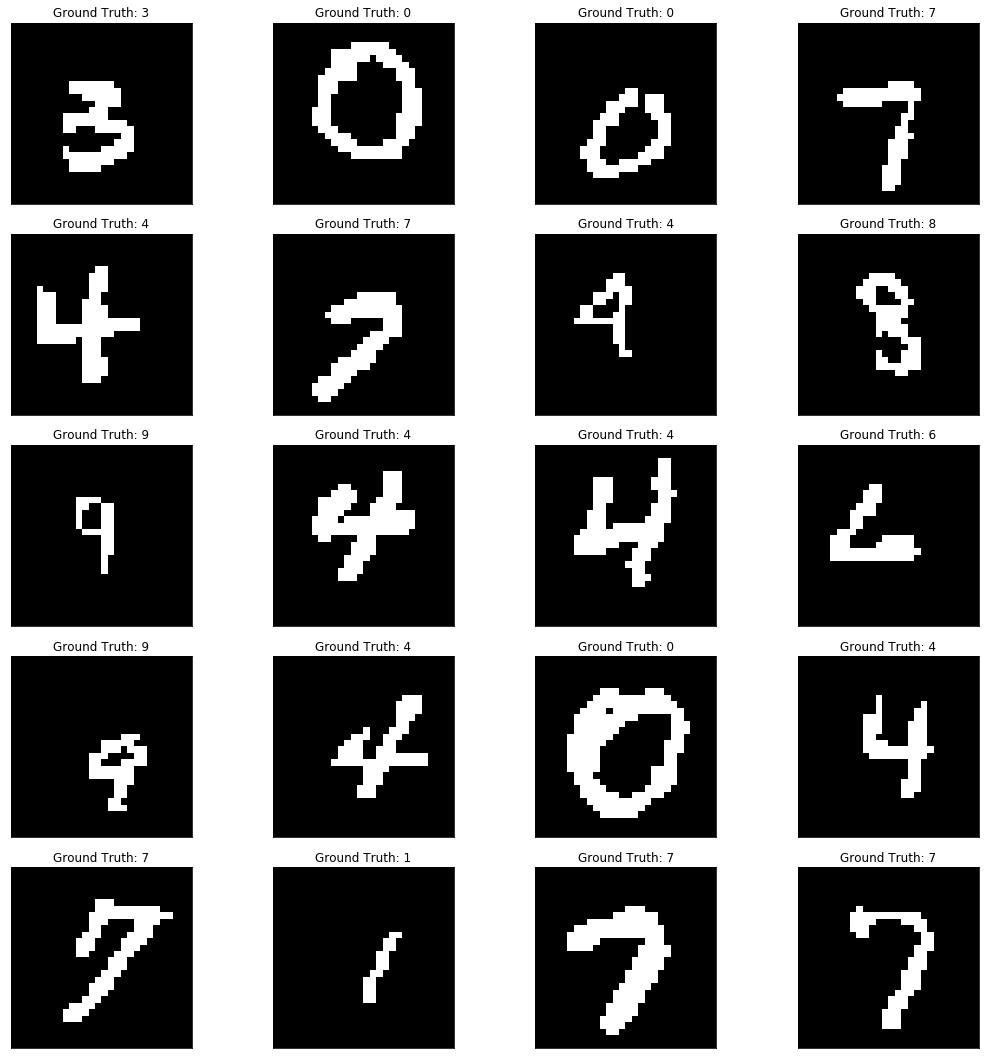

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(15,15))
num_examples_rows = 5
num_examples_cols = 4
for r in range(num_examples_rows):
    for c in range(num_examples_cols):
        idx = r*num_examples_cols + c + 1
        plt.subplot(num_examples_rows, num_examples_cols, idx)
        plt.tight_layout()
        plt.imshow(example_data[idx][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(example_targets[idx]))
        plt.xticks([])
        plt.yticks([])

## Model

Create a neural net with PyTorch's classes. After training, we will pull the weights from each layer and compare the output of the PyTorch model with a "bare-metal" Numpy module.

In [6]:
def build_simple_neural_net(num_hidden_layers=2, hidden_layer_width=100, input_size=28*28, output_size=10):
    modules = []
    
    for hidden_layer in range(num_hidden_layers):
        # Hidden layer
        if hidden_layer == 0: # first layer
            modules.append(nn.Linear(input_size, hidden_layer_width))
        else:
            modules.append(nn.Linear(hidden_layer_width, hidden_layer_width))
        # ReLU
        modules.append(nn.ReLU())
        
    # Output layer
    modules.append(nn.Linear(hidden_layer_width, output_size))
    
    # Softmax
    modules.append(nn.LogSoftmax(dim=1))
    
    return nn.Sequential(*modules)

## Training
Create a model and train it on the preprocessed data.

Function to run 1 training epoch over all training data in the loader:

In [7]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    cumulative_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1) # flatten image into 1D vector
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
    return cumulative_loss / len(train_loader)

Function to run an accuracy test over all data in the loader:

In [8]:
def test(model, test_loader):
    model.eval()
    correct_count, all_count = 0, 0
    for images, labels in test_loader:
        for i in range(len(labels)):
            image = images[i].view(1, 784)
            with torch.no_grad():
                log_probs = model(image)
            probs_tnsr = torch.exp(log_probs)
            probabilities = list(probs_tnsr.numpy()[0])
            pred_label = probabilities.index(max(probabilities))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1
    acc = 100 * correct_count / all_count # model accuracy
    return acc, correct_count, all_count

Construct a model, then train. The model will be saved to a file.

In [9]:
model = build_simple_neural_net(num_hidden_layers=3, hidden_layer_width=100)
num_epochs = 50
model_path = "./data/model.pt"
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

# NOTE: the model instance from above will be overwritten if a model exists at the provided path
try:
    model = torch.load(model_path)
except:
    print("Did not load a model.")

training_results = []
testing_results = []
for epoch in range(1, num_epochs+1):
    print("Epoch %d..." % epoch)
    avg_loss = train(model, optimizer, criterion, train_loader)
    percent_correct_train, num_correct_train, count_train = test(model, train_loader)
    percent_correct_test, num_correct_test, count_test  = test(model, test_loader)
    training_results.append(percent_correct_train)
    testing_results.append(percent_correct_test)
    print("\tTraining Loss: %.4f" % avg_loss)
    print("\tTraining Error: %.2f%% (%d/%d)" % (percent_correct_train, num_correct_train, count_train))
    print("\tTesting Error : %.2f%% (%d/%d)" % (percent_correct_test, num_correct_test, count_test))
    torch.save(model, model_path)

Did not load a model.
Epoch 1...
	Training Loss: 1.8550
	Training Error: 48.80% (29277/60000)
	Testing Error : 48.62% (4862/10000)
Epoch 2...


/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject

	Training Loss: 1.3354
	Training Error: 60.97% (36579/60000)
	Testing Error : 62.09% (6209/10000)
Epoch 3...
	Training Loss: 1.0862
	Training Error: 69.45% (41673/60000)
	Testing Error : 69.20% (6920/10000)
Epoch 4...
	Training Loss: 0.9052
	Training Error: 73.66% (44193/60000)
	Testing Error : 73.92% (7392/10000)
Epoch 5...
	Training Loss: 0.7873
	Training Error: 76.87% (46123/60000)
	Testing Error : 77.29% (7729/10000)
Epoch 6...
	Training Loss: 0.7091
	Training Error: 78.79% (47274/60000)
	Testing Error : 79.29% (7929/10000)
Epoch 7...
	Training Loss: 0.6526
	Training Error: 80.38% (48228/60000)
	Testing Error : 80.27% (8027/10000)
Epoch 8...
	Training Loss: 0.6068
	Training Error: 81.80% (49078/60000)
	Testing Error : 81.89% (8189/10000)
Epoch 9...
	Training Loss: 0.5741
	Training Error: 82.74% (49644/60000)
	Testing Error : 82.95% (8295/10000)
Epoch 10...
	Training Loss: 0.5394
	Training Error: 83.86% (50313/60000)
	Testing Error : 84.23% (8423/10000)
Epoch 11...
	Training Loss: 0

Plot the training/testing results across epochs:

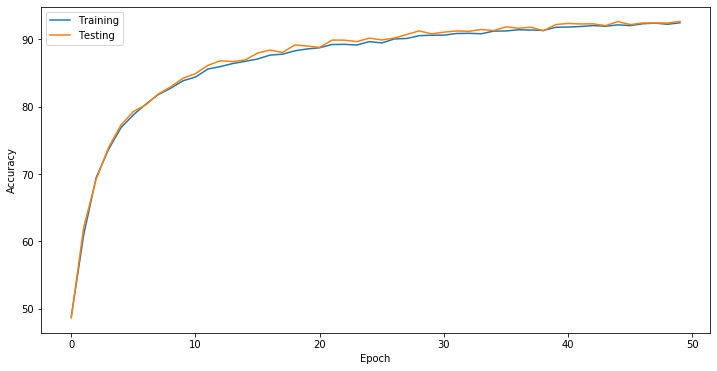

In [10]:
fig = plt.figure(figsize=(12,6))
plt.plot(training_results, label="Training")
plt.plot(testing_results, label="Testing")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#### Below are some model and transform configurations and their accuracy after training:

##### 2-layer, 128 and 64 widths, 90% accuracy:
    torchvision.transforms.RandomAffine((-15,15), translate=(.2,.2)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=True))

##### 2-layer, 200 widths, 94% accuracy:
    torchvision.transforms.RandomAffine((-15,15), translate=(.2,.2)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=True))

##### 3-layer, 100 widths, 92.6% accuracy:
    torchvision.transforms.RandomAffine((-5,5), translate=(.1,.1), scale=(.5,1.)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)), # mean and std. dev. of MNIST dataset
    torchvision.transforms.Lambda(lambda x: preprocess_data(x, noisy=False))

## Numpy Evaluation
Extract the trained weights from the PyTorch model, format them as Numpy arrays, and validate the outputs of Numpy operations with the PyTorch model.

Extract weights as Numpy matrices from PyTorch model.

In [181]:
model_path = "./data/model.pt"
model = torch.load(model_path)


# Hidden layers' weights/biases
hidden_layer_weights = []
hidden_layer_biases = []
num_hidden_layers = 0 # count of hidden layers
# Output layer's weight/bias
output_layer_weight = None
output_layer_bias = None


# Parse PyTorch model
def parse_pytorch_model(mdl):
    global hidden_layer_weights, hidden_layer_biases, num_hidden_layers, output_layer_weight, output_layer_bias
    num_modules = len(mdl)
    i = 0
    while i < num_modules-1:
        module = mdl[i]; i += 1
        next_module = mdl[i]; i += 1

        # Expect a linear module first
        assert isinstance(module, nn.modules.linear.Linear), "Expected Linear module"

        # Make sure following module is ReLU or LogSoftmax
        assert isinstance(next_module, nn.modules.activation.LogSoftmax) or \
                isinstance(next_module, nn.modules.activation.ReLU), "Expected ReLU or LogSoftmax module"

        # Make sure LogSoftmax is only at the end
        if isinstance(next_module, nn.modules.activation.LogSoftmax):
            assert i >= num_modules-1

        # Make sure last model is LogSoftmax
        if i == num_modules-1:
            assert isinstance(next_module, nn.modules.activation.LogSoftmax), "LogSoftmax should be last module."

        # Parse Linear module
        weight = module.weight.detach().numpy()
        bias = module.bias.detach().numpy()
        if isinstance(next_module, nn.modules.activation.ReLU): # is hidden layer
            hidden_layer_weights.append(weight)
            hidden_layer_biases.append(bias)
            num_hidden_layers += 1
        else: # is output layer
            output_layer_weight = weight
            output_layer_bias = bias

In [182]:
parse_pytorch_model(model)

Evaluate neural net with Numpy functions and compare to output of PyTorch neural net model.

In [12]:
def evaluate_numpy_nn(x):
    # Hidden layers
    for h in range(num_hidden_layers):
        x = np.matmul(hidden_layer_weights[h], x) + hidden_layer_biases[h] # H: W*x + b
        x = np.maximum(x, 0) # ReLU
    # Output layer
    x = np.matmul(output_layer_weight, x) + output_layer_bias # Output: W*x + b
    # Log softmax
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [13]:
num_tests = 10

def test_vectors(a, b, rtol=1e-03, too_small=1e-5):
    if np.isnan(a).any() or np.isnan(b).any():
        return False
    for i in range(len(a)):
        if abs(a[i]) < too_small and abs(b[i]) < too_small:
            continue
        if not (a[i]-b[i])/a[i] < rtol:
            print("Failing: a[%d]=%f  b[%d]=%f" % (i, a[i], i, b[i]))
            return False
    return True

for i in range(num_tests):
    fake_image_np = 10*np.random.rand(784)
    fake_image_tnsr = torch.from_numpy(fake_image_np).float().view(1, 784)
    pytorch_output = model(fake_image_tnsr).detach().numpy().squeeze()
    numpy_output = evaluate_numpy_nn(fake_image_np)
    assert test_vectors(pytorch_output, numpy_output, rtol=1e-03), \
            "Test failed for: {} {}".format(pytorch_output, numpy_output)
print("All %d tests passed!" % num_tests)

All 10 tests passed!


## Test Camera Images
Test the model on real images taken from the camera.

There are 10 images, one for each digit 0...9.

Preprocessing, from JPG image to 28x28 downsampled, thresholded image:

In [184]:
def preprocess_camera_image(jpg_path, black_threshold=.20, crop_margin=0.85):
    # Open with PIL
    with Image.open(jpg_path) as img_PIL:
        # Crop (to square, remove timestamp)
        width, height = img_PIL.size 
        target_size = crop_margin * height
        leftright_margin = (width - target_size) / 2
        topbottom_margin = (height - target_size) / 2
        area = (leftright_margin, topbottom_margin, width-leftright_margin, \
                       height-topbottom_margin) # rescale to square and remove time stamp
        img_PIL = img_PIL.crop(area)
        # Convert to Numpy
        img = np.asarray(img_PIL)
    # Grayscale (by averaging channels)
    img_gray = np.mean(img, axis=2)
    # Treshold
    minn = np.min(img_gray)
    maxx = np.max(img_gray)
    rng = maxx-minn
    thresh = black_threshold * rng + minn
    img_thresh = img_gray < thresh
    # Downsample (using max)
    img_small = block_reduce(img_thresh, block_size=(28, 28), func=np.max)[:28,:28]
    return img_small

Let's read in the images, preprocess them, and take a look:

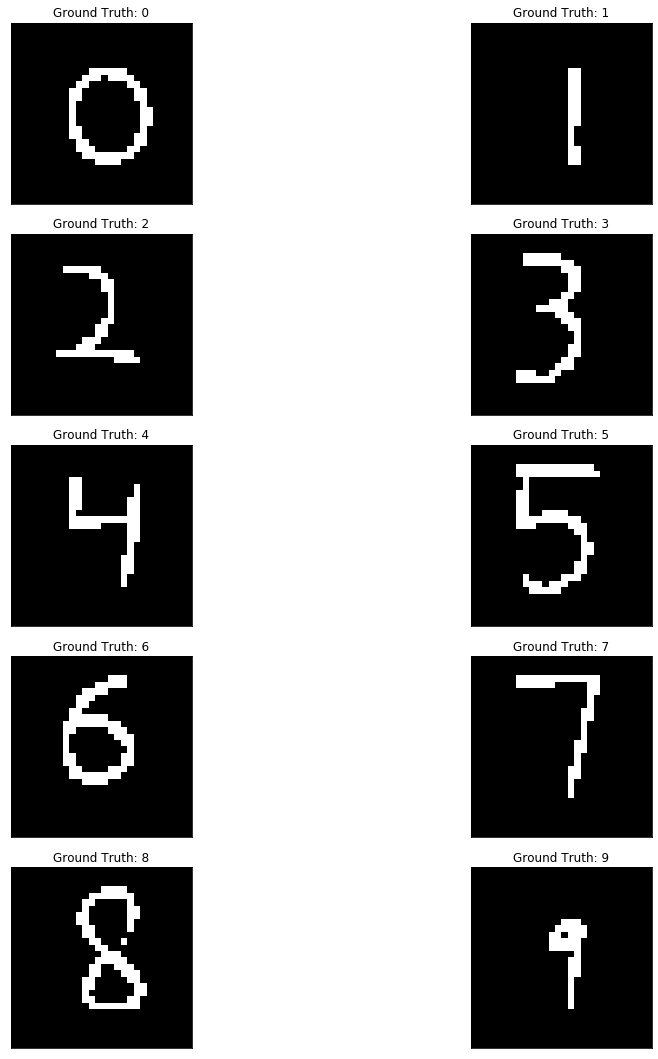

In [15]:
real_images = []
fig = plt.figure(figsize=(15,15))
num_examples_rows = 5
num_examples_cols = 2
for r in range(num_examples_rows):
    for c in range(num_examples_cols):
        # Get image
        digit = r*num_examples_cols + c
        jpg_path = "./data/real_images/test/%d.JPG" % digit
        image = preprocess_camera_image(jpg_path)
        real_images.append(image)
        # Plot
        plt_idx = r*num_examples_cols + c + 1
        plt.subplot(num_examples_rows, num_examples_cols, plt_idx)
        plt.tight_layout()
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(digit))
        plt.xticks([])
        plt.yticks([])

Now, let's see if our model correctly predicts the digits:

In [16]:
for digit in range(10):
    inpt = real_images[digit].flatten()
    probabilities = evaluate_numpy_nn(inpt)
    prediction = np.argmax(probabilities)
    if prediction == digit:
        print("Succeeded predicting digit %d" % digit)
    else:
        print("FAILED    predicting digit %d:  %d" % (digit, prediction))

Succeeded predicting digit 0
Succeeded predicting digit 1
Succeeded predicting digit 2
Succeeded predicting digit 3
Succeeded predicting digit 4
Succeeded predicting digit 5
FAILED    predicting digit 6:  5
Succeeded predicting digit 7
Succeeded predicting digit 8
Succeeded predicting digit 9


## Train on Real Images
Use some real images to train on, then test again.

Create dataset for real images.

In [171]:
from os import listdir
from os.path import isfile, join, basename

class RealImagesDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, transform=None):
        self.filenames = [join(images_dir, f) for f in listdir(images_dir) \
                          if isfile(join(images_dir, f)) and f.endswith(".JPG")]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = preprocess_camera_image(fname)
#         image = torch.tensor(image)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = int(basename(fname)[5])
        return image, label

Use different transforms than above for the new dataset.

In [172]:
transforms = [
#     torchvision.transforms.RandomAffine((-15,15), translate=(.1,.1), scale=(1.,1.)),
    torchvision.transforms.ToTensor()
#     torchvision.transforms.Lambda(lambda x: testtt(x))
]

real_images_loader = torch.utils.data.DataLoader(
                        RealImagesDataset("./data/real_images/dataset/",
                                          transform=torchvision.transforms.Compose(transforms)),
                        batch_size=50, shuffle=True)

Let's look at some of the images:

/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


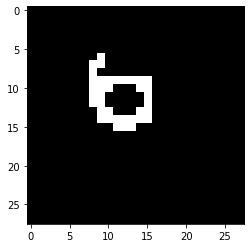

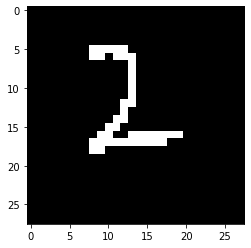

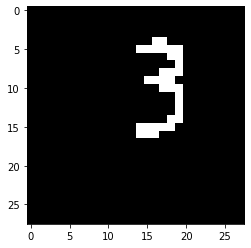

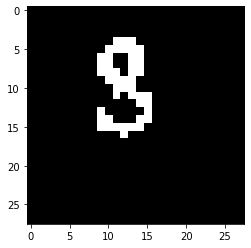

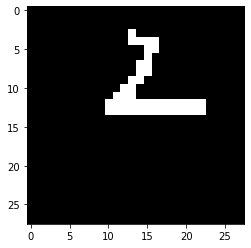

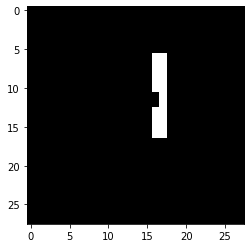

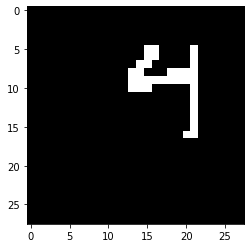

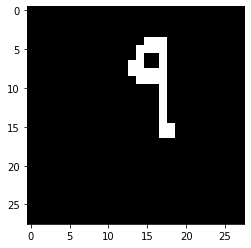

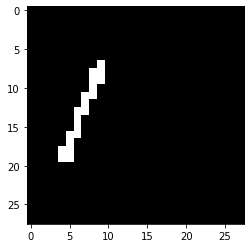

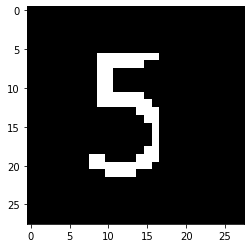

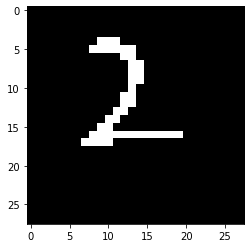

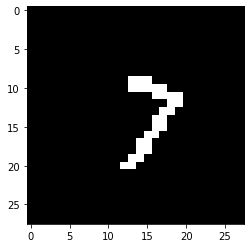

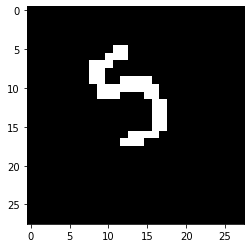

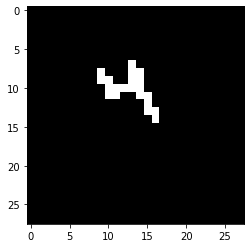

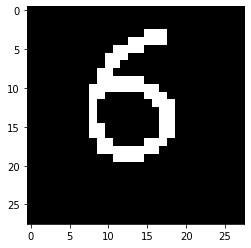

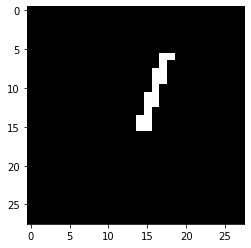

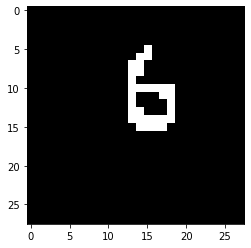

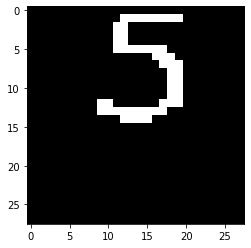

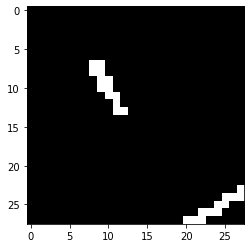

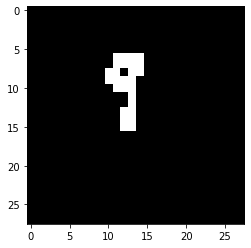

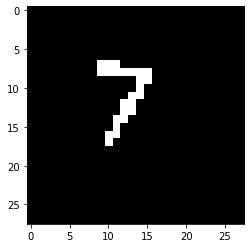

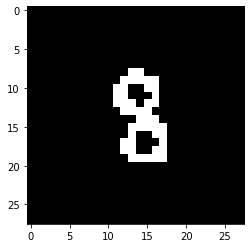

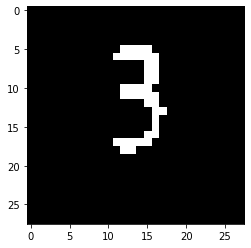

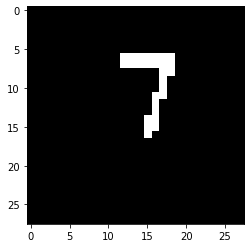

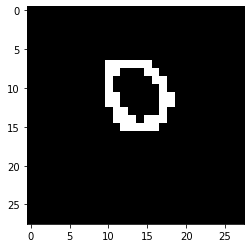

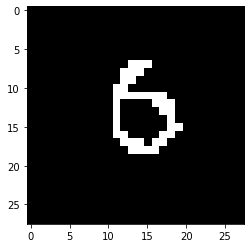

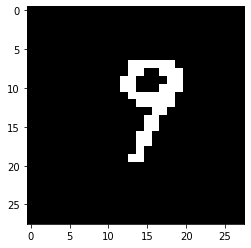

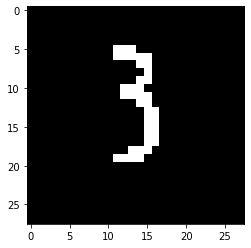

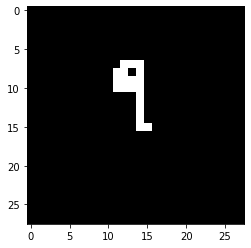

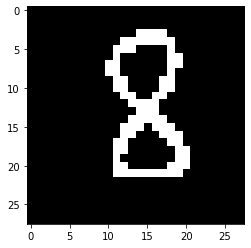

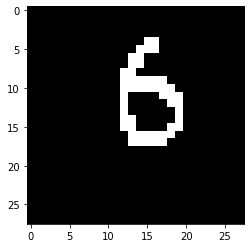

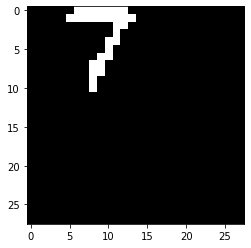

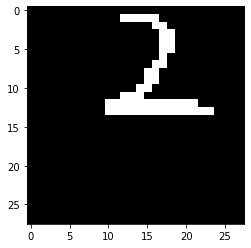

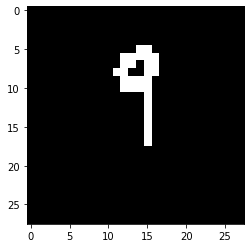

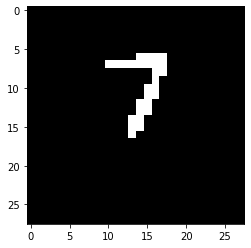

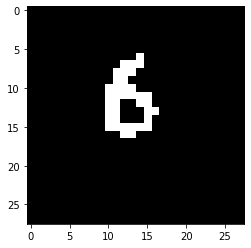

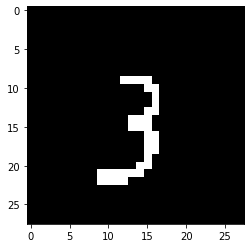

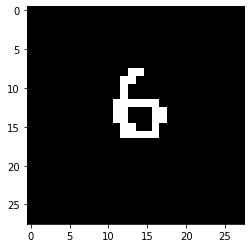

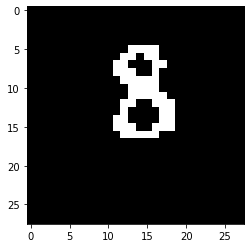

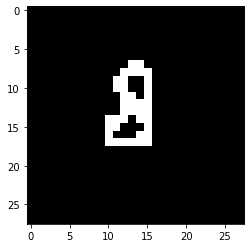

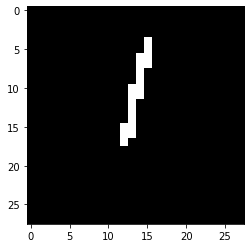

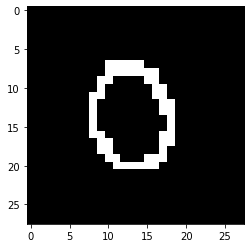

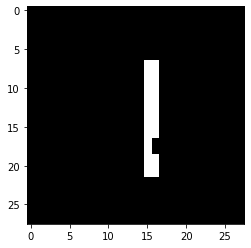

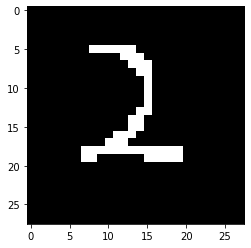

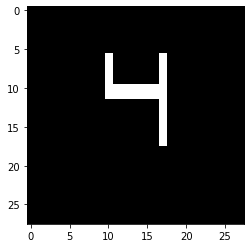

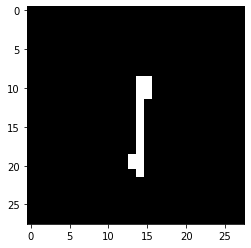

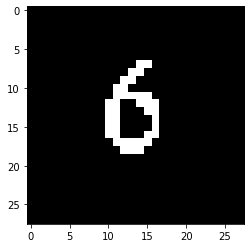

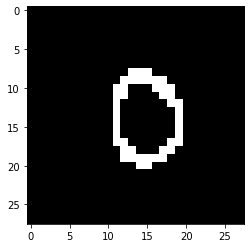

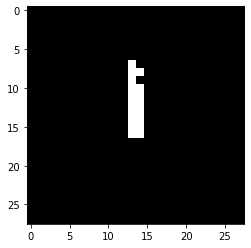

In [173]:
for images, labels in real_images_loader:
    for i in range(images.shape[0]):
        plt.figure()
        plt.imshow(images[i][0], cmap='gray')
    break

Train briefly on the new dataset (careful not to overfit!).

In [174]:
num_epochs = 10
model2_path = "./data/model_real_data.pt"
model2 = torch.load(model2_path)
optimizer = optim.Adam(model2.parameters(), lr=0.0001)
criterion = nn.NLLLoss()


for epoch in range(1, num_epochs+1):
    print("Epoch %d..." % epoch)
    avg_loss = train(model2, optimizer, criterion, real_images_loader)
    percent_correct_real, num_correct_real, count_real = test(model2, real_images_loader)
    percent_correct_mnist, num_correct_mnist, count_mnist  = test(model2, test_loader)
    print("\tTraining Loss: %.4f" % avg_loss)
    print("\tReal Images Testing Error: %.2f%% (%d/%d)" % (percent_correct_real, num_correct_real, count_real))
    print("\tMNIST Testing Error :      %.2f%% (%d/%d)" % (percent_correct_mnist, num_correct_mnist, count_mnist))
    torch.save(model2, model2_path)

Epoch 1...
	Training Loss: 1.4086
	Real Images Testing Error: 71.43% (130/182)
	MNIST Testing Error :      94.54% (9454/10000)
Epoch 2...
	Training Loss: 1.1883
	Real Images Testing Error: 74.18% (135/182)
	MNIST Testing Error :      93.57% (9357/10000)
Epoch 3...
	Training Loss: 1.0783
	Real Images Testing Error: 76.92% (140/182)
	MNIST Testing Error :      92.60% (9260/10000)
Epoch 4...
	Training Loss: 0.9679
	Real Images Testing Error: 79.12% (144/182)
	MNIST Testing Error :      91.76% (9176/10000)
Epoch 5...
	Training Loss: 0.9445
	Real Images Testing Error: 80.22% (146/182)
	MNIST Testing Error :      91.66% (9166/10000)
Epoch 6...
	Training Loss: 0.8674
	Real Images Testing Error: 80.22% (146/182)
	MNIST Testing Error :      92.27% (9227/10000)
Epoch 7...
	Training Loss: 0.8641
	Real Images Testing Error: 82.97% (151/182)
	MNIST Testing Error :      92.41% (9241/10000)
Epoch 8...
	Training Loss: 0.7258
	Real Images Testing Error: 84.07% (153/182)
	MNIST Testing Error :      92.2

Failed on :  ./data/real_images/dataset/Test_6_13.JPG   predicted: 9
Failed on :  ./data/real_images/dataset/Test_4_16.JPG   predicted: 7
Failed on :  ./data/real_images/dataset/Test_4_11.JPG   predicted: 7
Failed on :  ./data/real_images/dataset/Test_2_8.JPG   predicted: 6
Failed on :  ./data/real_images/dataset/Test_8_10.JPG   predicted: 9
Failed on :  ./data/real_images/dataset/Test_4_10.JPG   predicted: 9
Failed on :  ./data/real_images/dataset/Test_6_17.JPG   predicted: 9
Failed on :  ./data/real_images/dataset/Test_7_18.JPG   predicted: 1
Failed on :  ./data/real_images/dataset/Test_0_17.JPG   predicted: 4
Failed on :  ./data/real_images/dataset/Test_5_18.JPG   predicted: 2
Failed on :  ./data/real_images/dataset/Test_9_15.JPG   predicted: 1
Failed on :  ./data/real_images/dataset/Test_0_19.JPG   predicted: 7
Failed on :  ./data/real_images/dataset/Test_7_11.JPG   predicted: 6
Failed on :  ./data/real_images/dataset/Test_1_7.JPG   predicted: 9
Failed on :  ./data/real_images/data

/Users/michaelstecklein/School/AdvancedMCUSystems/finalproject/nn_modelling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Failed on :  ./data/real_images/dataset/Test_1_10.JPG   predicted: 4
Failed on :  ./data/real_images/dataset/Test_4_18.JPG   predicted: 7
Failed on :  ./data/real_images/dataset/Test_8_18.JPG   predicted: 6
Failed on :  ./data/real_images/dataset/Test_8_9.JPG   predicted: 7
Failed on :  ./data/real_images/dataset/Test_6_7.JPG   predicted: 8
Wrong: 26/182


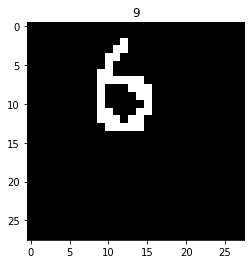

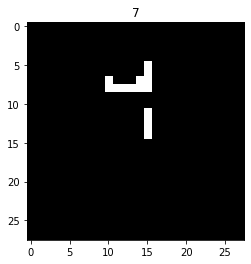

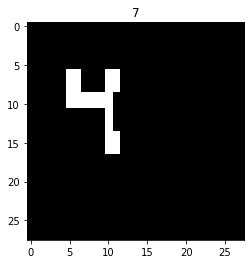

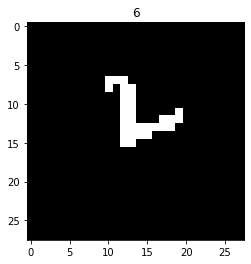

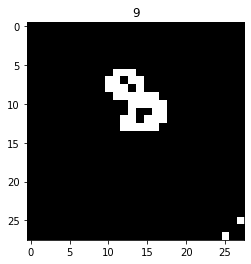

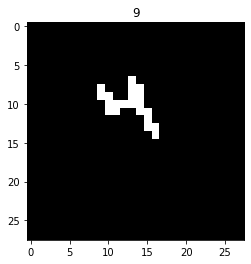

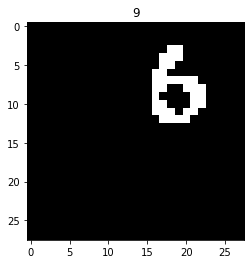

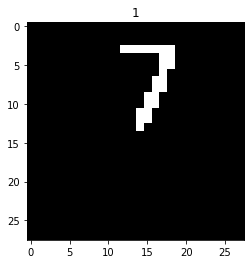

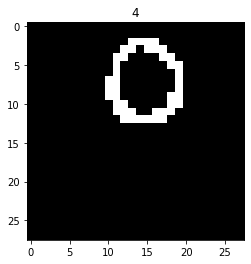

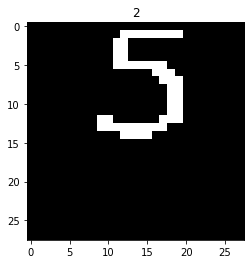

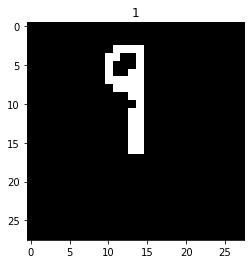

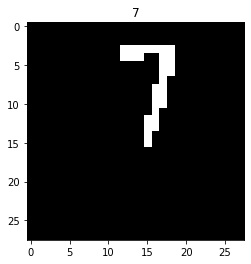

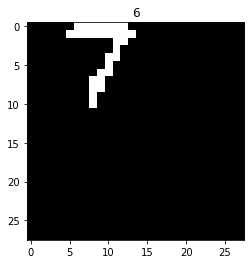

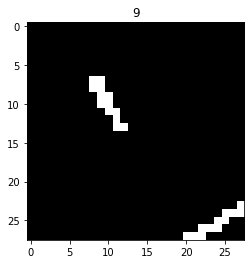

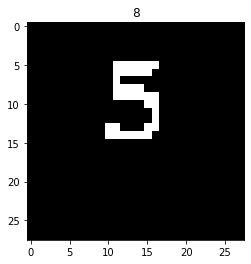

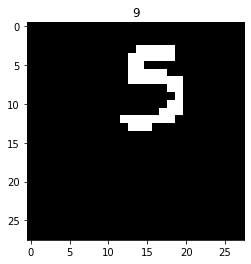

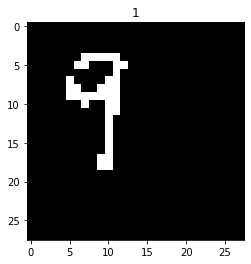

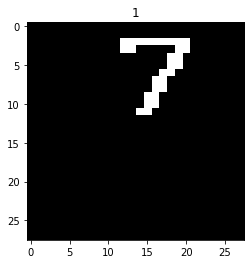

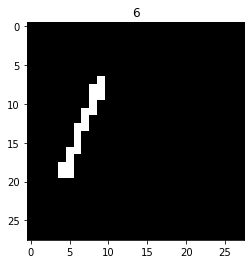

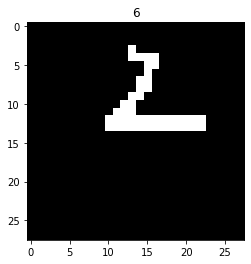

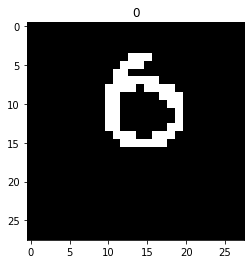

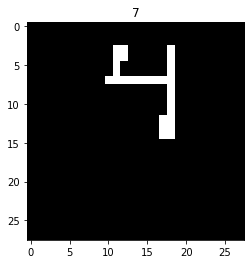

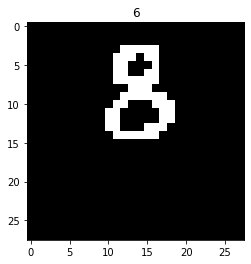

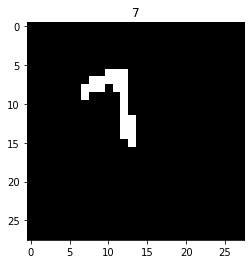

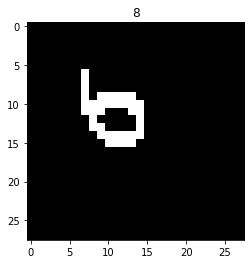

In [175]:
model2.eval()
images_dir = "./data/real_images/dataset/"
filenames = [join(images_dir, f) for f in listdir(images_dir) \
                          if isfile(join(images_dir, f)) and f.endswith(".JPG")]
total_cnt = 0
failed_cnt = 0
for fname in filenames:
    image = preprocess_camera_image(fname)
    image_tnsr = torch.from_numpy(image).float().view(1,784)
    with torch.no_grad():
        log_probs = model2(image_tnsr)
    probs_tnsr = torch.exp(log_probs)
    probabilities = list(probs_tnsr.numpy()[0])
    pred_label = probabilities.index(max(probabilities))
    true_label = int(basename(fname)[5])
    if(true_label != pred_label):
        print("Failed on : ", fname, "  predicted:", pred_label)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.title(str(pred_label))
        failed_cnt += 1
    total_cnt += 1
print("Wrong: %d/%d" % (failed_cnt, total_cnt))

## Print weights
Print out the weights in a format thats nice for C.

In [183]:
parse_pytorch_model(model2)

In [187]:
def print_mat(np_mat):
    for r in range(np_mat.shape[0]):
        for c in range(np_mat.shape[1]):
            print(np_mat[r,c], end=", ")

def print_vec(v):
    for i in range(len(v)):
        print(v[i], end=", ")

print("Num hidden layers:", num_hidden_layers)
for h in range(len(hidden_layer_weights)):
    print("Hidden Layer %d Weight:" % (h+1))
    print_mat(hidden_layer_weights[h])
    print("Hidden Layer %d Bias:" % (h+1))
    print_vec(hidden_layer_biases[h])
print("Output Layer Weight:")
print_mat(output_layer_weight)
print("Output Layer Bias:")
print_vec(output_layer_bias)

Num hidden layers: 5
Hidden Layer 1 Weight


-0.02929995, -1.148507e-05, -0.007463455, 0.010137893, -0.025754265, -0.022181423, 0.009505566, 0.0020035426, -0.011744333, 0.0127099715, -0.034587163, -0.029079743, -0.016633077, -0.022317579, -0.06020525, 0.014164325, -0.010710257, -0.05506427, -0.014178763, -0.020171458, -0.036323465, 0.00689098, 0.014590392, 0.028542472, -0.014987389, 0.032417707, -0.014571561, 0.015756905, -0.03419234, 0.03468897, 0.017923776, -0.008511483, 0.01530974, 0.04561394, -0.007263238, 0.038221814, 0.004719082, 0.01874354, 0.037439972, 0.018589951, -0.025924042, -0.02246388, 0.021465153, 0.022887744, -0.006128181, 0.031153925, -0.012076253, -0.048602715, -0.008324243, 0.008294815, -0.03451431, -0.017430505, -0.032717995, -0.0015861129, 0.019109534, 0.030126486, -0.02232137, 0.012340369, 0.030620018, 0.016800059, 0.018732045, -0.020172933, 0.0046971235, 0.028890358, 0.0039896104, -0.01058472, 0.0012038046, -0.04429089, -0.039342962, -0.013719451, 0.0035111345, -0.019460013, -0.022950856, -0.02393957, -0.02

-0.0039576897, -0.0033083218, -0.019272584, -0.07706098, -0.039895613, -0.033466853, -0.053689647, -0.016381087, -0.019472457, 0.023387987, 0.009696838, 0.010812841, 0.029029097, 0.026333787, 0.027479308, -0.029328488, -0.003709633, -0.05303541, -0.05394487, -0.017748246, -0.0003252428, 0.008454568, -0.0136952195, -0.016493903, -0.0051041744, -0.020879678, 0.030256035, 0.031611226, -0.0066795396, -0.0900049, -0.03817059, -0.047839146, -0.022516388, -0.06420794, 0.01290848, -0.046379846, -0.022121197, 0.00494112, 0.0007352564, 0.033592947, 0.008513298, 0.02938247, -0.0012494333, -0.04930737, -0.027553875, 0.0253685, 0.02204919, 0.007308111, 0.015815362, 0.029488716, -0.0069344076, 0.043502707, -0.011259131, -0.00016394343, -0.017585207, -0.019511674, -0.011503658, -0.002030329, -0.0036465735, -0.008386681, -0.01748939, -0.03328588, -0.016400153, -0.032011934, -0.017042046, 0.003624388, -1.2772109e-05, -0.027723927, 0.00020097078, 0.03272638, 0.0062594214, 0.00032150475, -0.04781967, -0.

, 0.07713766, 0.021405993, 0.055073205, 0.09515958, 0.105027735, 0.06904058, 0.023818633, 0.013126999, 0.017460143, 0.024373842, 0.034802463, 0.027922692, 0.040470283, 0.044856068, 0.029241996, 0.078846976, 0.023951793, 0.050985564, 0.060257334, 0.067361705, 0.023376158, -0.006610124, -0.012870356, 0.030959252, 0.031321146, 0.04603627, 0.032242924, 0.057232097, 0.08517589, 0.09110932, 0.062031172, 0.060730096, 0.0681583, 0.064345315, 0.03399189, 0.01824226, 0.006582184, 0.049957693, 0.058793526, 0.097000375, 0.09636484, 0.060137022, 0.054747887, 0.10356462, 0.065775394, 0.05589398, 0.052304454, 0.051610716, 0.033445098, 0.03573305, -0.02314472, -0.007442608, -0.0014793872, 0.045269646, 0.060125668, 0.018357513, 0.053893972, 0.029473236, 0.08493458, 0.10830787, 0.025133835, 0.07629455, 0.055246625, 0.033506814, 0.07991791, 0.09126026, 0.10608221, 0.08104975, 0.112909876, 0.059228767, 0.054031312, 0.041191857, 0.034931857, 0.017002337, 0.04001804, 0.009171362, 0.010336237, -0.01442313, 0

0.07547012, 0.05522454, 0.07611881, -0.011882758, 0.007285155, 0.02330741, -0.0049084164, -0.014459326, -0.012143086, 0.018138673, 0.047341716, 0.029256893, 0.033027656, 0.0390964, 0.060555566, 0.03117574, 0.014747302, 0.017375506, 0.0045018448, -0.019114047, -0.026920302, -0.0041104094, -0.019990135, 0.00092624116, -0.0026096045, -0.012452992, -0.030455206, 0.029543282, 0.011331007, -0.01064091, 0.0058788266, -0.0026500274, -0.035929285, -0.038319107, 0.027519744, 0.035880618, 0.020938959, -0.0047929683, 0.035559375, 0.0063417153, 0.00094760454, -0.014381018, -0.009277348, -0.006740022, -0.01634401, -0.032435186, -0.05606595, -0.07538765, -0.10500126, -0.10753706, -0.08009599, -0.09594733, -0.07482448, -0.079872385, -0.034730986, -0.078789935, -0.023580277, -0.041452833, -0.11799084, -0.078412384, -0.15827242, -0.07279256, -0.081600524, -0.031347994, 0.012672962, 0.019949444, -0.013738725, -0.018536335, -0.0076328614, -0.057544485, -0.07227772, -0.07948588, -0.09643341, -0.076745726, 

, -0.02065645, -0.031493746, 0.0004183347, -0.02733232, -0.009581032, -0.0038323298, 0.026112366, 0.0075855968, 0.010444065, 0.019285377, 0.034742933, 0.04253131, 0.03520591, 0.0002996762, 0.02533598, 0.014584736, -0.00716603, 0.007192836, 0.047847036, 0.00041606856, 0.0065629515, -0.009142069, 0.016531263, 0.006481722, -0.0022786823, 0.020978747, -0.014670344, 0.0045034457, -0.019593349, -0.025288632, 0.013403289, -0.001124498, -0.012493976, 0.006644386, -0.00033828517, -0.0026040697, 0.02475513, 0.011284847, 0.018498758, 0.01916246, 0.0019022515, 0.009630274, 0.017734399, 0.033409145, 0.010604139, -0.019140104, -0.014494348, -0.008130553, 0.014731901, 0.0023393468, 0.04021971, -0.02421364, -0.0024102551, 0.01924547, 0.0024161877, 0.03663925, -0.0022052936, 0.027374959, -0.021323377, -0.004962399, 0.0038542077, 0.0122913625, 0.010961356, 0.010762337, -0.015580123, 0.017757215, 0.035593405, 0.00073654315, 0.034817915, 0.014790047, 0.00079054834, 0.004014307, -0.0015204522, 0.03533176, 

-0.16632564, -0.11600848, -0.06651595, -0.04378736, -0.003511068, 0.018904114, -0.030776808, -0.055568866, -0.023573654, -0.032306034, -0.07469214, -0.09097275, -0.0875899, -0.053271927, -0.03157618, 0.022994485, 0.012639797, 0.009611696, -0.008266555, -0.0153751625, -0.06662747, -0.07504079, -0.10704112, -0.103890285, -0.12586494, -0.11200039, -0.099843174, -0.10473248, -0.07380839, -0.1157829, -0.0520537, -0.047527127, 0.0027659996, 0.008532916, -0.019409833, 0.020615673, 0.013108014, 0.028033003, 0.015018218, 0.019556833, 0.04664882, 0.064315416, 0.09111347, 0.03544307, 0.041969698, 0.07887907, 0.034750983, 0.013561844, 0.03664264, 2.454699e-07, 0.004482676, 0.03676971, 0.0024866487, -0.020613233, -0.036050472, -0.00222119, -0.053102877, -0.014969084, 0.019699873, -0.006730132, -0.024203336, 0.022545679, -0.020868998, 0.037478194, 0.016054187, 0.1032171, 0.053807266, 0.1079713, 0.10215777, 0.1251172, 0.1206388, 0.11918644, 0.1313949, 0.11713599, 0.16605927, 0.1528039, 0.14544365, 0.

, 0.008754085, 0.0111572705, -0.046191875, -0.038678546, -0.008753431, 0.053536277, 0.049396593, 0.061810736, 0.03493827, 0.054687053, 0.010341372, -0.005039457, -0.032131515, 0.026451193, -0.03900778, -0.029239591, -0.0020945051, 0.010817691, 0.026467241, 0.033482645, 0.016333418, -0.033295147, 0.0076146736, -0.011595132, -0.021359473, -0.019553771, 0.016716551, -0.026143506, -0.00069889624, -0.02504511, -0.011311403, -0.0146585, 0.058815427, 0.057713926, 0.036100704, 0.06100654, 0.044340007, 0.023269549, 0.020541357, 0.002614323, 0.011154874, -0.019282958, -0.045706235, -0.02345104, -0.07020185, 0.031741157, -0.012863057, 0.02172862, 0.037094805, 0.028243242, -0.008057872, 0.027954936, 0.025208598, 0.020034892, 0.03850522, -0.02364603, -0.010621696, -0.01850501, -0.033410326, 0.03406059, 0.062665045, 0.05746176, 0.02016007, 0.009955159, 0.03696772, 0.025646312, 0.040623967, 0.051251043, 0.03970905, -0.01632278, 0.005749928, -0.011221546, 0.004233436, -0.025640355, 0.008647572, -0.017

-0.059891865, 0.022286374, 0.05572406, 0.040852245, 0.023505244, 0.070248984, 0.010556478, 0.02505062, 0.055199444, 0.047217026, 0.022938704, 0.04809382, 0.07641937, 0.08599348, 0.057772208, 0.0726774, 0.057130363, -0.0055414387, -0.031992495, -0.01326266, -0.010164827, -0.05776229, -0.100402825, -0.110689394, -0.053290103, -0.11969368, -0.045689892, -0.061995417, -0.005481531, -0.00823268, 0.03314433, -0.02057776, 0.076659665, 0.02658768, 0.042233653, 0.028414737, -0.0011192375, -0.015216964, 0.022960471, 0.049291138, 0.05500179, 0.07826407, 0.040465474, 0.016930044, 0.02929609, -0.019256204, -0.048836377, -0.03899226, -0.054420494, -0.10168831, -0.09241005, -0.08131094, -0.10731787, -0.07487306, -0.07242052, -0.068840034, -0.032393932, -0.04817239, -0.0061246734, 0.010716581, 0.017168133, 0.028170278, 0.026806895, 0.027341112, 0.026297605, -0.013559717, -0.0008793225, 0.024678363, 0.036578346, 0.059843127, 0.028324503, 0.04830666, 0.057204198, -0.011572864, -0.054584358, -0.0626965, 

, -0.040351246, -0.014280757, 0.03775, 0.039414093, 0.04385994, 0.036397215, 0.0031409, -0.04737474, -0.059714593, -0.04677488, -0.026763685, -0.029419871, -0.01641363, -0.006460796, -0.01666323, -0.029114872, -0.017638605, -0.0030619965, -0.04624246, -0.04260703, -0.031270582, -0.027737856, -0.04215221, -0.027536614, -0.007670053, 0.0539458, 0.0018232648, -0.021173395, -0.06008373, -0.0295941, 0.017072666, 0.008736448, 0.059599932, 0.076640695, 0.0055210465, 0.01171849, -0.053249847, -0.022401676, -0.0061284755, -0.059698872, -0.0475208, 0.016929919, -0.03761896, -0.0251768, 0.018705688, -0.017927155, -0.0046723536, 0.011838395, 0.0092560435, -0.04118185, -0.050955325, -0.06996382, 0.0062749786, 0.08015278, 0.064887434, 0.037224147, -0.016512195, -0.052047953, 0.03940807, 0.046488848, 0.035055157, 0.035553183, 0.041144878, 0.0301007, 0.00518322, -0.0029990927, -0.058254313, 0.007431732, -0.01512504, -0.025002524, 0.0031331386, -0.044725284, 0.0044938726, 0.0048805596, -0.020023348, -0

0.014183593, 0.022399431, 0.0036717043, 0.0036097276, 0.019416258, -0.008355811, -0.051803518, -0.022613747, -0.04271599, -0.06945902, -0.031648636, -0.07596599, -0.042181343, -0.026128283, -0.0059285075, -0.057438865, 0.010073366, -0.014182928, 0.0020901724, -0.060328398, -0.039842565, -0.04650496, -0.08795176, -0.041484505, -0.07383802, -0.03495552, -0.014947151, -0.029230662, 0.050478123, 0.03267177, 0.030621398, 0.030023057, -0.006665082, -0.040966358, -0.06418984, -0.07404649, -0.044552714, -0.076113604, -0.07156139, -0.056671623, -0.018734124, 0.020061627, -0.018446693, -0.04044276, -0.05522471, -0.030699616, -0.04727978, -0.049961645, -0.0033450054, -0.05959639, -0.05796465, -0.06884061, -0.061738823, -0.009219941, -0.05378794, 0.038645506, 0.03019141, 0.04924614, 0.017447714, 0.045721382, 0.021322507, -0.03822084, -0.006765621, -0.062101748, -0.035745267, -0.059960734, -0.059101447, -0.006314571, -0.04173523, -0.01192874, -0.047891025, -0.057635944, -0.017539078, 0.033416692, 0

, -0.026435474, -0.01589006, 0.020131439, 0.021612858, -0.01814145, 0.022095868, 0.020289859, -0.025441447, -0.013939744, -0.0053768517, 0.009522425, 0.0056049684, -0.014558605, 0.02489244, -0.028871147, 0.0008232946, 0.008937745, -0.016752008, -0.010110982, 0.0075787045, -0.007555936, -0.017048664, 0.043409843, 0.109605394, 0.026165478, -0.039618928, -0.024453575, -0.067636445, 0.021305302, -0.019948967, 0.006946226, 0.02277864, -0.0014576584, 0.0083277775, 0.0029447766, -0.015884258, 0.0045232326, -0.029475933, 0.0624792, 0.017139712, 0.015982626, -0.011851441, -0.006054802, 0.024610305, 0.020166801, 0.05418947, 0.012652532, 0.02029582, -0.015243109, -0.0023848703, 0.10639415, 0.13944077, 0.08224702, 0.0065921973, -0.032868322, 0.041964117, 0.04627929, 0.002244205, 0.021228759, 0.026516186, 0.049785685, 0.010847627, 0.00875734, -0.0056335004, 0.032551516, -0.034650564, -0.029082367, -0.018156154, -0.007598797, -0.018464144, -0.039150164, 0.0007136879, 0.022477748, 0.034574226, -0.005

0.008686848, -0.013723067, 0.025931224, 0.020445112, 0.043367267, 0.03253738, 0.05534478, -0.001250386, -0.0121115325, -0.034322813, -0.029717166, -0.023167096, -0.058079563, -0.047223322, 0.032340225, 0.0018542313, 0.014613203, 0.012048435, 0.010670066, 0.054121956, -0.005206285, -0.019747712, -0.0067571686, -0.037622888, 0.031038728, 0.021975886, -0.0052443994, -0.0077541964, 0.043504223, 0.023588419, 0.06158917, 0.051997483, 0.018749919, 0.0791865, 0.026490184, 0.027497217, -0.039850533, -0.023197392, -0.091132455, -0.07798512, -0.06523902, -0.07666097, -0.030337505, -0.0026449268, 0.0057146833, -0.009622029, 0.049910292, 0.015601692, 0.028109448, -0.025856365, 0.019493438, 0.0054022335, 0.026473865, 0.035409883, 0.014049283, 0.03187476, 0.0295133, 0.0334484, 0.09491039, 0.060813524, 0.1279047, 0.03381671, 0.023461392, -0.07134539, -0.07098994, -0.13004635, -0.12459297, -0.16439673, -0.12822694, -0.0771999, -0.06530087, -0.044023983, -0.023442283, -0.004316777, -0.012452353, -0.0054

, 0.010969761, -0.0122943865, -0.027866328, -0.04681387, 0.0047841184, 0.027000392, -0.0016926387, -0.024449877, -0.0120637715, 0.013150565, 0.031551138, 0.0073435022, 0.007289247, 0.05204297, 0.03140739, 0.039335433, 0.0045295334, 0.010113972, -0.0022398913, 0.0205159, 0.031372268, 2.5250154e-05, 0.01302701, 0.0061133085, 0.012110414, 0.0286997, 0.011381686, 0.014159663, 0.031913284, 0.0053898846, -0.046090912, -0.012963772, 0.010501496, -0.004319028, -0.00059957936, -0.034481227, -0.004875779, 0.022280404, 0.015007112, 0.011446366, -0.0038598543, 0.009504022, 0.067820325, 0.0065955897, 0.021547016, 0.061506074, 0.012200876, 0.012931235, 0.0075562294, 0.0368059, 0.012801294, 0.041102298, 0.055487603, 0.06298914, 0.059439186, 0.015539423, -0.0065696687, -0.0038295432, -0.0024960502, -0.017627377, 0.04152818, -0.009466666, -0.00062756985, 0.011034057, 0.0065973774, 0.0015081242, -0.003391277, 0.001386635, 0.024211608, -0.006065314, -0.0040293634, 0.027732331, -0.056380942, -0.04294143, 

0.053320356, 0.09116398, 0.05509859, 0.06360801, 0.08668984, 0.107853256, 0.13387215, 0.0991827, 0.12299206, 0.10468042, 0.09238181, 0.05141459, 0.06542059, 0.070901535, 0.06211214, 0.023618944, 0.030425567, 0.0072664344, -0.02174612, -0.009756939, 0.022588862, -0.010293205, -0.05153588, 0.0030861087, 0.007843133, 0.009659402, 0.024232656, 0.055870507, 0.043353856, 0.039483197, 0.061677888, 0.07326622, 0.04194545, 0.052541304, 0.076377936, 0.106035925, 0.07721583, 0.08309226, 0.06775352, 0.063259244, 0.06428988, 0.025437973, 0.064562164, 0.060006473, 0.016126083, 0.030876292, -0.0041957344, -0.017162474, 0.0027001672, 0.018669294, -0.062063318, 0.003100154, -0.027821155, -0.011629451, 0.0015827047, 0.031820603, 0.063769385, 0.053784605, 0.06890906, 0.056640472, 0.026388492, 0.03147405, 0.062388226, 0.04737907, 0.06987464, 0.055642728, 0.04772394, 0.017334744, 0.02586138, 0.044728722, 0.047188643, -0.02357764, 0.03456535, -0.023045799, -0.031234963, 0.017889103, 0.033756804, -0.01763621

, 0.0382106, -0.015964717, 0.028016, 0.008544296, 0.0068265754, -0.017084885, -0.03502874, -0.045165244, -0.022141544, -0.020071648, -0.03802108, -0.028087469, -0.030105967, -0.038473476, -0.005069192, -0.011923702, -0.017316025, -0.020941224, -0.045713644, -0.026749458, -0.0077294353, -0.002708226, -0.040606614, -0.036379006, -0.015857268, -0.01698568, 0.034518775, -0.013702101, 0.016345551, -0.014859033, 0.0073845442, 0.016567001, -0.015953807, 0.027617568, 0.009821988, 0.008463164, -0.0043906244, -0.017080659, -0.018137991, -0.008181255, -0.023624774, -0.015353319, -0.032643005, -0.026411358, -0.04329696, -0.043245442, -0.0015946096, -0.054590035, -0.047928248, 0.0015623156, 0.020639244, 0.023270698, -0.019836457, 0.0029646275, -0.0065580406, -0.024150804, 0.030002672, -0.0147724245, 0.013115182, -0.008759712, 0.0075090565, 0.0016198027, 0.0001738302, 0.0072974437, -0.017092416, -0.04000249, 0.009022682, -0.029376613, 0.0132668335, -0.0015918122, -0.00039025233, 0.004762769, -0.0442

-0.060645927, -0.019977022, -0.01543741, 0.027354136, 0.026923612, -0.014770769, 0.044477902, 0.00242837, -0.016478606, -0.038571425, 0.030435622, 0.020275049, 0.040291764, 0.08892686, 0.11308751, 0.104362585, 0.091891505, 0.049913622, -0.017713357, -0.13119154, -0.11426672, 0.05255021, 0.12916896, 0.13592967, 0.18427156, 0.14547372, -0.089502126, -0.17939118, -0.13081063, -0.07340639, -0.05043944, 0.01966922, 0.02549302, 0.018395713, 0.0020114074, 0.009552583, 0.022304827, 0.014577902, -0.00885747, 0.05446211, 0.03209626, 0.05036701, 0.081962615, 0.093025416, 0.024651628, -0.036589507, -0.12675713, -0.14595413, -0.059258077, 0.108446695, 0.09864328, 0.15373357, 0.16451871, 0.14639893, -0.06883998, -0.1859036, -0.16537364, -0.10200918, -0.091801316, -0.023151997, 0.0051160413, -0.00086933427, 0.026433902, -0.03220819, -0.0031389084, -0.03401595, 0.014873062, 0.031383622, 0.038083665, 0.03256603, 0.048330434, 0.014759989, -0.034961056, -0.105978824, -0.17000294, -0.11225642, 0.012350399

, -0.08183286, 0.0018306684, 0.009663083, 0.047612417, 0.042941127, 0.06412626, 0.023911266, 0.02422297, 0.029662756, 0.031905934, -0.0078001525, -0.011454171, 0.0007852828, 0.023029635, 0.02652503, 0.031859156, -0.0004969801, -0.0036094699, -0.0010958974, 0.007868819, 0.0018590314, 0.000774699, 0.019102138, -0.052808072, -0.05712416, -0.05371365, -0.025470657, -0.047688257, -0.016941639, -0.036438063, -0.01607907, 0.019189285, 0.009502418, 0.069915496, 0.079928644, 0.042791143, 0.023089496, 0.017073274, 0.0357684, 0.012740725, 0.0111637255, 0.019738061, -0.009871085, -0.00023578486, 0.01663585, 0.02612503, 0.030831732, 0.057054523, 0.022038762, 0.056106478, 0.034873337, -0.02326174, -0.043955654, -0.012793947, -0.025011247, -0.07969262, -0.008718406, -0.013438948, -0.028689079, 0.009281247, 0.037648045, 0.03141736, 0.039966248, 0.050521143, 0.027317591, 0.038101736, -0.0060322327, -0.01753344, 0.01997469, 0.037906855, 0.006364223, 0.050906487, 0.025627341, 0.056527767, 0.054099962, 0.

0.00893425, -0.016601376, 0.031717453, 0.026499696, -8.032139e-05, -0.029673075, -0.026105367, -0.024203505, -0.0045290445, -0.04749445, 0.007962681, 0.0015241128, -0.013745236, -0.018279934, -0.045836136, -0.0030004135, -0.015391247, -0.053413615, -0.05966853, -0.06374979, -0.034030654, -0.011594624, -0.0505375, -0.01625638, -0.002928703, 0.006120223, -0.020845952, -0.01043166, 0.0017241512, 0.04314819, 0.049514335, 0.011322904, -0.004392371, -0.011332372, -0.02836178, -0.049342006, -0.036881637, 0.0057257065, -0.021697015, 0.002245553, -0.038998924, -0.04069351, -0.020324385, 0.021086631, 0.013079648, -0.0828321, -0.09605505, -0.05931985, -0.039781574, -0.0402996, -0.0026074857, -0.04361075, -0.0663638, -0.04148006, 0.035521008, 0.03609274, 0.083835594, 0.069495514, 0.056282677, 0.04763114, 0.04289108, 0.02786051, 0.01583587, 0.0015273611, -0.028361712, -0.004438005, 0.015839165, 0.014840675, 0.0075669456, 0.008879422, 0.0035421231, 0.024403956, -0.04520765, -0.051233426, -0.04221898

, 0.010719151, -0.014993423, -0.02756096, -0.018306466, -0.017820437, -0.051774736, -0.038403828, -0.051549483, -0.026090609, -0.067198485, 0.0026614005, 0.041464634, 0.046609744, 0.09202964, 0.094685525, 0.09448699, 0.091228455, 0.07870892, 0.042230893, 0.056676652, 0.05348722, 0.07529849, 0.11145899, 0.06332038, 0.06859531, 0.049569465, 0.06078489, -0.021054799, -0.0017948865, -0.011556045, -0.018710157, -0.05565543, -0.025621574, 0.0003568751, -0.05147262, -0.009876298, -0.02182534, -0.018806601, 0.014007694, 0.03444999, 0.06083979, 0.092852905, 0.12561084, 0.13092527, 0.1139543, 0.08535604, 0.1021722, 0.07766833, 0.080581225, 0.038740303, 0.10689848, 0.09708623, 0.056176256, 0.048283197, 0.0078828335, 0.008360378, 0.027316058, 0.0065400717, 0.018836983, -0.005283894, -0.049644165, -0.033498283, 0.010443835, -0.009689759, -0.051388953, 0.005577209, 0.008268745, 0.043655664, 0.029555295, 0.005423364, 0.04468312, 0.06968211, 0.0633881, 0.069338135, 0.06735056, 0.03753063, 0.029809633,

0.013307786, 0.018205928, -0.008809952, 0.029135792, 0.073211715, 0.027565002, 0.055865522, 0.072241046, 0.027726943, 0.05864802, 0.02742142, -0.018866967, -0.0106212, -0.025639331, -0.008156611, -0.045524463, -0.023197751, -0.058377977, -0.036565144, -0.04644339, -0.052893057, -0.030578183, -0.05075653, -0.043051105, -0.04615972, 0.011529453, 0.03498306, 0.014656734, 0.012048247, 0.008781901, 0.03040735, 0.03688533, 0.037951756, 0.051558953, 0.075543255, 0.07378879, 0.06855374, 0.03920129, 0.037886575, -0.034760635, 0.006890985, -0.027778793, -0.014450264, 0.013706257, 0.009257104, -0.010724821, -0.047784578, -0.033637896, 0.000848428, -0.03955244, -0.018923942, -0.034178637, -0.05588044, -0.036953043, 0.009363309, 0.009268834, 0.022067172, 0.04844683, 0.03131073, 0.0410897, 0.074677624, 0.043143786, 0.060540345, 0.039428692, 0.041261736, -0.002696219, -0.01709709, -0.0012824325, -0.026855862, -0.05043076, -0.007821077, -0.008605297, 0.018181324, -0.04791426, -0.055996772, -0.01349096

, -0.022098554, -0.024634989, 0.016044531, 0.01744801, 0.0022546323, -0.016318256, 0.0026858419, 0.022438388, 0.038793754, 0.03669226, -0.009263359, 0.03149362, -0.0051382976, 0.0060026087, 0.006158373, -0.018031713, -0.029463572, -0.006029022, 0.011117571, -0.0112091545, 0.02602697, 0.03098964, 0.03952644, 0.03384923, -0.0067938897, 0.018307423, -0.010038266, -0.011285422, 0.020312496, 0.006802045, 0.04831079, 0.043789893, 0.04949169, 0.04644049, 0.036738656, 0.015728148, 0.028980946, 0.0354206, 0.00786261, 0.00823587, -0.02033189, 0.009764123, 0.009252601, -0.014028304, 0.008297799, 0.0013985303, -0.03525608, 0.025193073, -0.018401485, -0.0031602087, -0.005895199, -0.024687193, 0.041608237, -0.02316222, 0.029532824, 0.036430206, 0.0031279468, 0.0578141, 0.012837921, 0.019874783, 0.017664233, 0.023537949, 0.025419248, 0.032873746, 0.0040190034, 0.0030774479, 0.0048597907, -0.0028157942, 0.0055431807, -0.0030040822, -0.032843526, -0.0069132275, -0.0130213015, -0.028619299, 0.018885083,

-0.108159, -0.084996626, -0.11141975, -0.06854208, -0.101507515, -0.061839536, -0.033928584, -0.043736793, -0.038175467, 0.0077003273, 0.005200473, 0.006365809, -0.03015986, -0.09257018, -0.11138017, -0.074514955, -0.122406565, -0.18308243, -0.17147267, -0.20518859, -0.22808829, -0.20720449, -0.29275286, -0.2387745, -0.24247248, -0.23826289, -0.20412157, -0.20252538, -0.20612526, -0.14149456, -0.1527374, -0.12761441, -0.08668409, -0.07205064, -0.057395592, 0.010172874, 0.01569711, 0.026298273, 0.008728094, -0.029022262, 0.01643722, -0.02663328, -0.046051018, -0.093040965, -0.084909916, -0.12203314, -0.13637151, -0.107912384, -0.12836832, -0.12767117, -0.12992042, -0.13082522, -0.11470961, -0.13355856, -0.1154657, -0.11834773, -0.12776043, -0.072800495, -0.06425366, -0.102227084, -0.08541305, -0.051293068, -0.0040634535, -0.01899244, 0.011007691, 0.01757177, 0.0013033721, 0.03077545, 0.02655637, -0.020648671, 0.0061332635, -0.018318465, 0.0153196305, -0.019260487, -0.054233216, -0.03200

, -0.02902885, -0.038883537, -0.033272795, -0.059246358, -0.045820385, -0.07030269, -0.037720434, 0.003090544, -0.006251363, -0.04725744, -0.06374935, -0.037985027, -0.02575114, 0.0069860807, -0.02170432, -0.027062913, -0.0012195403, -0.02802789, 0.01640501, -0.015125285, 0.014195523, 0.036508337, 0.055439223, 0.096758835, 0.08531761, 0.10423909, 0.051740956, 0.011458422, -0.024173921, -0.0728496, -0.07291668, -0.038254708, -0.029185256, -0.07190654, -0.073982105, -0.05032469, -0.04374502, -0.07244333, -0.060513176, -0.05316082, -0.02788968, -0.0072989566, -0.013747224, -0.0038440474, -0.016263124, -0.005403645, -0.032376003, -0.022847202, 0.0031380856, 0.057408042, 0.042350844, 0.10797449, 0.11712294, 0.10255229, 0.062459942, 0.030712457, -0.011079468, -0.04897915, -0.062329765, -0.07835454, -0.07356074, -0.06547028, -0.088279836, -0.059989348, -0.06941945, -0.044856448, -0.036105096, -0.028774943, -0.027156675, -0.03954685, -0.06797821, 0.020820573, 0.020935955, -0.052811537, -0.0273

0.015364349, -0.0063595874, -0.018593172, -0.01684588, -0.021777, -0.02730656, -0.028824601, -0.07531123, -0.11820207, -0.1210717, -0.10267577, -0.04955014, -0.08211314, -0.056039073, -0.028411234, -0.062060125, -0.07829187, -0.0358004, -0.01871159, -0.026637355, -0.0010013875, -0.007703453, 0.040254783, -0.019114008, 0.013579621, 0.10369737, 0.078479506, 0.033962134, 0.0017794835, -0.022818401, 0.010692148, -0.021377055, 0.005500892, -0.0699803, -0.05752567, -0.11224235, -0.12850714, -0.14290968, -0.13951555, -0.044112407, -0.040592153, -0.040925317, -0.0066470383, -0.07377877, -0.07502657, -0.028322235, -0.021329457, -0.022058163, 0.017563632, 0.002237194, 0.035870694, -0.011773654, 0.01996341, 0.03849183, 0.06781257, 0.05209925, -0.0065838387, 0.009200597, 0.02364189, -0.03162354, -0.07332358, -0.07341289, -0.08347644, -0.1025932, -0.19752872, -0.16415964, -0.11652034, -0.04281168, -0.04181478, -0.014060236, -0.033849183, 0.01622792, -0.0013964131, 0.0054963743, 0.05623218, -0.01466

-0.043379813, -0.04807908, 0.025348717, 0.054037496, 0.003975622, 0.015129904, 0.0018602599, 0.049539827, 0.015987827, 0.016182113, -0.011600928, -0.027424771, 0.008871421, 0.012484841, -0.0269699, 0.011819666, 0.020422475, 0.0048663504, -0.014562853, -0.06679756, -0.02348701, -0.053528804, -0.09736465, -0.028399717, -0.038886942, -0.063528284, -0.008784117, -0.009163332, -0.040908318, -0.0042538675, 0.009655152, -0.0063250265, 0.021096813, 0.038261667, -0.020325504, -0.014556123, -0.014024364, 0.0014347027, -0.00070831174, -0.010072671, 0.016668472, 0.0040643886, 0.005633267, 0.025869064, -0.014892713, -0.04713953, -0.06460024, -0.09739832, -0.13973036, -0.14202863, -0.13908286, -0.06676597, -0.06328802, 0.004261779, 0.003717835, 0.0045635942, -0.01114712, -0.0038759802, 0.009148245, -0.03213452, -0.02456826, 0.0077360407, -0.0034798146, -0.01607969, -0.0044253776, -0.015952388, -0.021658437, -0.007683661, -0.0096962415, 0.006241815, 0.012037045, 0.00022665135, 0.017929336, -0.0537103

0.058671393, 0.023247566, 0.042186845, 0.080600396, 0.043698713, 0.054957837, 0.055521213, 0.019103568, 0.04737309, -0.013495577, 0.016849216, 0.008008509, 0.0028521342, 0.008572157, -0.034131113, 0.033767805, 0.012385155, 0.007980824, -0.044109277, -0.014422133, 0.0033554332, 0.0047302265, -0.042354427, -0.029993214, -0.01923064, -0.0006297453, 0.008707129, 0.056099612, 0.043513656, 0.039113346, 0.049746774, 0.012021091, 0.048417702, 0.014464187, 0.024371771, 0.02770159, -0.0068061794, -0.006702588, -0.0053158444, 0.01323136, -0.026946003, 0.018766629, -0.024628565, -0.03314574, -0.041533068, 0.0031431185, -0.035582777, -0.044164583, -0.02918737, -0.041885093, -0.03910184, -0.0241732, -0.025636796, -0.026709924, 0.014226547, 0.009042396, -0.003900296, 0.018868204, 0.0026256482, 0.03240919, 0.04413178, 0.03655234, -0.005648802, 0.01362473, 0.0028956528, 0.000420969, 0.017803293, 0.03776463, 0.031849816, 0.040554047, -0.01011393, -0.040227246, -0.030579006, -0.023297021, -0.06635923, -0

, -0.035659328, -0.022411807, -0.014480572, -0.023909668, -0.014975853, 0.01713862, -0.040622134, -0.007535175, -0.013345626, -0.019397555, -0.012722265, 0.04104225, -0.043739792, -0.027908945, -0.022440262, -0.027360734, -0.014240219, 0.0071150125, -0.047516383, -0.0698708, -0.038078755, -0.075816214, -0.07229102, -0.08990574, -0.07270146, -0.0519902, -0.06176421, -0.054383364, -0.002278133, -0.004473218, 0.015621373, -0.012618941, -0.005864892, -0.01323888, 0.021169256, -0.023082463, -0.0012101954, -0.017418297, 0.054496642, -0.017750133, -0.030308692, 0.00789077, 0.023058489, -0.0038356816, 0.03295756, 0.013206416, 0.016386922, -0.01625635, -0.013731243, 0.015439217, -0.0010240567, 0.035605475, 0.026251841, 0.0065541314, 0.020681968, 0.04135825, 0.021819, -0.008814547, -0.02199208, -0.023121638, -0.0053761313, -0.005639042, 0.013494231, 0.015836423, 0.013379238, 0.049431637, 0.059176683, 0.03618268, 0.019164229, 0.025793688, 0.023225566, -0.0005937059, 0.046499718, 0.023993574, 0.03

-0.0030175587, 0.00876807, -0.012390245, 0.04884714, 0.005722328, -0.025271982, 0.01844413, -0.06132746, -0.0141509, -0.024442468, -0.030274976, -0.03110723, -0.050744787, -0.016750598, -0.011240327, -0.0791997, -0.090922214, -0.009698817, -0.0127821285, 0.008154663, -0.046633992, -0.04568419, -0.038220618, -0.002189466, -0.012038672, -0.022883095, -0.042382702, -0.023973482, -0.034225207, -0.023685679, 0.04621078, 0.047437087, 0.002513391, -0.0015205351, 0.010221338, -0.010400955, -0.03526839, -0.011626984, -0.0041271322, -0.0032141425, 0.01295846, 0.02392959, -0.010145097, -0.042224076, -0.024724847, 0.0062610917, 0.04752809, 0.043147042, 0.044729184, -0.0014068544, 0.053431183, 0.041036926, 0.0008455226, 0.043838304, 0.02371684, 0.026345592, -0.0036159754, -0.025363296, -0.029618295, 0.025039403, -0.00034998218, -0.0044005997, 0.013661274, -0.02446256, -0.030277245, -0.0039416477, -0.01233075, -0.03036512, 0.051443625, 0.005159389, -0.00062579237, -0.06029644, -0.01763783, 0.0766706

, 0.04320973, 0.07504362, 0.00084870687, -0.00408561, -0.005812974, 0.02678381, 0.07665844, 0.07408494, 0.10516236, 0.118909135, 0.10026081, 0.09420992, 0.040351115, -0.014194594, -0.020536002, 0.0017197202, -0.037920434, -0.04922199, 0.0036004798, 0.030873835, 0.08681951, 0.08026298, 0.07037928, 0.07490983, 0.07667384, 0.062775165, 0.09058841, 0.09859997, 0.04960629, 0.027156476, 0.024395475, 0.0130576175, 0.021153972, 0.051808774, 0.103443705, 0.10375006, 0.07105884, 0.12840672, 0.09718829, 0.12877366, 0.07029891, 0.013530635, -0.013268225, -0.003358194, 0.00034594, 0.039208047, 0.04269878, 0.075606, 0.059488952, 0.075308, 0.07257934, 0.075402796, 0.041259956, 0.02768681, 0.023812046, 0.10050134, 0.042753074, 0.037650615, -0.020050041, -0.015645495, -0.00478889, 0.031333387, 0.07478649, 0.088713184, 0.10083145, 0.050236803, 0.06763449, 0.07441515, 0.027309157, 0.011637488, -0.06005145, -0.023583675, 0.051506527, 0.04153141, 0.023618912, 0.110528514, 0.05676432, 0.09339476, 0.05961188

0.06033604, -0.005329174, -0.02292618, -0.039206196, -0.0037516032, 0.0253059, 0.037819594, 0.074948184, 0.103510596, 0.08700984, 0.08641246, 0.1066519, 0.1133788, 0.113873586, 0.11232526, 0.108868614, 0.05636648, 0.07347472, 0.0439007, -0.017289648, 0.02749219, -0.0005952382, 0.00082331116, -0.03043292, -0.021881467, 0.0073114475, -0.015535611, 0.020959502, 9.0681795e-05, 0.004974585, -0.018526442, -0.014373797, 0.00070537487, 0.035349753, 0.07573453, 0.12566666, 0.1457616, 0.11292967, 0.07810429, 0.05863494, 0.049786698, 0.08784152, 0.07118184, 0.066546366, 0.06997822, 0.07739535, -0.0004200986, -0.037897512, 0.026300287, 0.022114605, -0.032446794, -0.07691677, -0.047033105, -0.06197788, 0.019768128, 0.041557647, 0.017330712, 0.047956046, 0.007898489, -0.050971124, -0.07888715, -0.08784239, -0.08432759, 0.035753578, 0.10418227, 0.0543636, 0.07185888, 0.02205485, 0.057829253, 0.04632268, 0.026631672, 0.016943451, 0.065859236, 0.014240332, -0.0041376655, 0.021537133, -0.018051846, -0.0

-0.0418431, -0.0201764, 0.008277054, 0.0063333237, 0.011716, -0.0038012806, -0.048144422, 0.0042669456, -0.03427183, -0.014058707, -0.021100292, -0.023605157, 0.0328914, 0.0006510662, 0.025553059, -0.0016188032, -0.029324932, -0.046187785, -0.047020465, -0.061505817, -0.07152724, -0.09369351, -0.16746293, -0.17545906, -0.19569214, -0.13884786, -0.10760874, -0.064866535, -0.05728114, -0.00670542, 0.0060262405, -0.0082771275, -0.0016731, -0.03210084, -0.0006187236, -0.0062200725, -0.021754138, 0.030011136, -0.025135169, 0.022845518, 0.0015810742, 0.05310878, 0.040502623, -0.020426994, 0.019285705, -0.0374913, -0.10193299, -0.076716945, -0.12181686, -0.13071768, -0.1394303, -0.11343054, -0.07987359, -0.03334817, -0.019884037, -0.021345079, -0.018987145, -0.01100244, -0.005031073, -0.008475211, 0.0045743403, -0.00392308, -0.0012525773, -0.039645396, -0.049859185, -0.030133508, -0.02108797, -0.0013497974, -0.010815251, -0.0107761165, -0.01884275, -0.047157787, -0.04982653, -0.046193108, -0.

, -0.13494997, -0.12162964, -0.070466235, -0.051285177, 0.03210312, 0.065182194, 0.0719137, 0.07237453, 0.08233618, 0.05490513, 0.013456912, -0.04358191, -0.10373059, -0.08672368, -0.04421624, -0.031758614, -0.05804111, 0.026833765, -0.030059816, -0.13792543, -0.10591896, -0.13640268, -0.14096908, -0.13935359, -0.097062096, -0.113016635, -0.05890433, -0.037805337, -0.031541135, -0.07522311, -0.06931219, -0.07451579, -0.045629144, 0.00037359857, 0.015939442, 0.05025779, 0.061239403, 0.048959535, 0.03875294, -0.03510717, -0.06481358, -0.068589434, -0.06586133, -0.06609144, -0.015374144, -0.017007004, -0.039085917, -0.11794678, -0.122545734, -0.08969072, -0.08333623, -0.060914468, -0.009636191, 0.044883765, 0.03435777, 0.043007016, 0.021345902, 0.013002624, -0.041336324, -0.062093683, -0.0737317, -0.04016454, -0.01964483, 0.006581424, 0.024247149, 0.056967773, 0.012146422, -0.027003784, -0.043347955, -0.031319924, -0.031587858, -0.015800351, -0.05655684, -0.009972122, -0.0159854, -0.07037

0.023424042, -0.0047673285, 0.005916892, 0.042001244, 0.028083753, 0.0057832925, 0.043709148, 0.020782923, 0.03700807, 0.06793962, 0.051132057, 0.044788778, 0.043183263, 0.041843254, -0.0122832805, -0.082901575, -0.13503824, -0.14264752, -0.11498013, -0.07729381, -0.039881796, -0.028477795, -0.0046673706, 0.010676237, -0.01211236, -0.0012346356, 0.019156432, 0.002590375, 0.007792619, 0.02117232, -0.020281006, 0.035785154, -0.011643701, 0.030013148, 0.051136807, 0.07057546, 0.07613756, 0.053128745, 0.09211771, 0.100043744, 0.10325352, 0.09193404, 0.098832704, 0.02653471, -0.010008075, -0.070888825, -0.05014208, -0.04043964, -0.020474052, 0.016066074, 0.013691619, 0.044292666, 0.023080187, 0.013831296, 0.01704516, -0.0050078635, -0.016687429, 0.0106339855, 0.023713008, 0.012063187, -0.016350174, 0.016297184, 0.021844313, 0.031000055, 0.06600187, 0.054006193, 0.05926625, 0.11942555, 0.11296913, 0.12055042, 0.13635969, 0.18305987, 0.15236934, 0.13502073, 0.08034123, 0.079007864, 0.0648415,

, -0.02923823, 0.02028855, -0.0015433473, -0.039403874, 0.011087043, -0.0060969596, 0.012632746, -0.020892637, -0.029986573, -0.042506635, -0.05353478, -0.062401865, -0.06513654, -0.047952116, 0.042170517, 0.03829825, 0.021316838, 0.03053576, 0.035878588, 0.035167996, 0.039562102, 0.033537537, 0.012573115, -0.005068683, -0.0030711365, 0.0034757631, -0.023766648, -0.02190635, -0.050231665, -0.025430588, 0.0020838769, -0.0057738586, 0.035766516, 0.014985317, -0.03946441, -0.035946097, -0.0004804002, -0.042431213, -0.046716426, -0.043544617, -0.02101735, 0.014914007, 0.046246547, 0.04391653, -0.006114226, 0.019384315, 0.02622337, 0.0033764828, -0.01885585, 0.032230888, 0.07280853, 0.033193726, 0.039545607, -0.009102768, -0.014555433, -0.018526364, -0.0309359, 0.041348934, 0.00025313237, -0.032796845, -0.024250561, 0.021278339, -0.024713578, -0.033958476, -0.06175868, -0.046077553, -0.08285424, -0.05097499, 0.029172918, 0.051408794, 0.052250322, 0.03981707, -0.0008694355, -0.012179632, -0.

0.0026687954, -0.06643469, -0.060977846, -0.066957034, -0.075264655, -0.06072868, -0.07821087, -0.09123152, -0.056102596, -0.13358675, -0.08626717, -0.05213411, -0.042762443, 0.010168856, -0.037454233, -0.03170428, -0.0053592655, 0.010135759, 0.013139579, -0.061381135, 0.0033820048, -0.04324305, -0.018805372, -0.021763109, -0.037441492, -0.014486245, 0.047283832, 0.03319319, -0.033467494, -0.07997398, -0.05352457, -0.06329447, -0.055501033, -0.06715277, -0.08330529, -0.0743726, -0.11585153, -0.12003584, -0.0611337, -0.04912628, 0.034964614, 0.0052021057, -0.0129531035, -0.027300933, 0.0023662662, -0.016257005, -0.026041498, -0.021734575, 0.004075856, -0.012138026, 0.020882893, 0.007087667, 0.0013485721, 0.032391906, 0.029734012, 0.011451851, -0.031953074, -0.05136245, -0.0044637066, -0.022902992, -0.044635404, -0.044252902, -0.038291052, -0.04067407, -0.06039615, -0.0865761, -0.08231228, 0.012800114, -0.019753583, -0.0450847, -0.037323598, 0.015504449, -0.0014394231, -0.037892967, -0.0

0.00920057, 0.013727991, -0.005932908, -0.06664643, -0.03575509, 0.021721102, 0.06862481, 0.12802827, 0.084938504, 0.07553419, 0.05997309, 0.031076971, 0.023021288, 0.0655091, 0.054222032, -0.00043503073, -0.022005515, -0.026948469, -0.03965894, -0.05518205, 0.015047562, -0.034905974, -0.00889672, -0.060525306, -0.028855344, -0.062850006, 0.019126052, 0.04422286, -0.004500687, -0.018289892, -0.032960363, -0.011411255, 0.013174157, 0.1117937, 0.13752057, 0.1368367, 0.11456249, 0.056636944, 0.015968466, 0.026160857, 0.049751606, 0.054270893, 0.02386017, -0.046015237, -0.010238851, -0.045480933, -0.006304486, -0.03389006, -0.02772052, 0.024399687, 0.0009961509, -0.052421365, -0.03705596, -0.014738431, -0.040062547, 0.0325368, 0.00886762, -0.016125843, -0.04890249, -0.039361656, -0.022619618, 0.061225586, 0.14046142, 0.09558256, 0.05746708, -0.013635671, -0.015566748, 0.025279224, 0.050039344, 0.0037270205, -0.038700324, -0.029359754, -0.07675554, -0.018008318, -0.021126954, -0.04115806, -

, -0.21376362, -0.1960542, -0.15457326, -0.16896647, -0.11506547, -0.09761948, -0.039710283, -0.032158084, -0.0679051, 0.0008209467, -0.049444243, -0.05572802, -0.029246472, -0.03793886, -0.024272963, -0.011019637, -0.028707085, -0.053364538, -0.039423667, 0.0065592085, 0.014015194, 0.03344518, 0.057601575, 0.09141535, -0.07056343, -0.08539744, -0.1321579, -0.19706486, -0.23751685, -0.20303859, -0.14771192, -0.10162919, -0.13666096, -0.07926468, -0.055794094, -0.033002146, -0.03900067, 0.005980475, -0.032781072, -0.050319918, -0.0767042, -0.0723435, -0.055702813, -0.02104341, -0.04893278, 0.00068053283, 0.023022568, 0.051992655, 0.045390785, 0.09116141, 0.07497468, 0.06048672, -0.07151539, -0.04959519, -0.045320366, -0.11139429, -0.17219682, -0.20758164, -0.19997697, -0.17007737, -0.0503154, -0.09025628, -0.062498197, -0.045402437, -0.058184296, -0.0043505915, -0.052528903, -0.078849174, -0.009834269, -0.060876653, -0.0140886, 0.015620446, 0.02246545, 0.043194976, 0.03467948, 0.0222556

, 0.01561641, 0.03573459, 0.0151855005, 0.06407772, 0.080973834, 0.13541074, 0.07980603, -0.09181827, -0.13547611, -0.066339605, -0.077075265, -0.032205347, -0.027491884, -0.044669412, -0.0061634607, -0.006311317, -0.048428845, -0.014747289, -0.008931493, 0.004807093, 0.008195976, -0.027961416, -0.014388248, -0.052586097, -0.051362168, -0.06356056, -0.04488519, 0.0023197075, 0.004620482, -0.0005228828, 0.020730838, 0.061238155, 0.11298426, 0.11755742, -0.030224625, -0.12730077, -0.11424065, -0.102246925, -0.071455225, -0.081826404, -0.04874259, -0.028882192, -0.006256757, 0.0021647653, -0.012391986, 0.025193792, 0.041973773, -0.0006863556, 0.0088813035, -0.031374454, -0.010645904, -0.033459254, -0.014920132, -0.046777498, 0.020051967, 0.019458361, 0.030109672, 0.052536838, 0.056182906, 0.098195635, 0.12330732, 0.011444341, -0.06837481, -0.13615108, -0.112742834, -0.09637588, -0.060604766, -0.07120093, -0.082175486, -0.027863532, -0.04754203, -0.0010765467, -0.05232237, -0.040186573, -0

, 0.006427538, -0.022926155, 0.01536023, -0.0053949957, 0.019810067, -0.0142877, -0.00956475, 0.020006906, -0.06942706, -0.057968758, -0.059109125, -0.08083671, -0.0641435, -0.01913199, -0.004425055, -0.0144748315, 0.007608225, -0.022931386, 0.007637548, -0.029816031, -0.01964596, -0.017134108, 0.025238892, 0.015612686, -0.010872036, -0.009753745, 0.009723135, -0.0005449488, 0.008069534, 0.0035349762, -0.0050795563, 0.023299806, -0.0054200096, 0.024642712, 0.045437068, 0.050636135, -0.042050485, -0.043416686, -0.058803264, -0.05270216, -0.06133834, 0.02124203, -0.030502766, 0.025064364, -0.002448749, -0.013789048, 0.005952321, 0.011249819, 0.018056551, -0.022240384, 0.018422674, -0.0051748976, 0.00403092, -0.006451241, 0.02145541, -0.0013621495, -0.0070715705, -0.024427194, -0.0053991773, -0.013718576, 0.012892013, -0.021615462, 0.00051972526, 0.005163705, -0.022856249, -0.023468232, -0.034408744, -0.042399604, -0.035295885, -0.02008189, 0.003184421, -0.007556559, -0.013676656, 0.00673

, -0.06451677, -0.0419146, -0.045559656, -0.046670586, -0.014472543, 0.034299165, 0.03662158, 0.083537854, 0.044664193, 0.09245212, 0.06684742, 0.06555124, -0.021567505, 0.026971959, 0.04475884, -5.4983353e-05, -0.013984494, -0.029193942, -0.03239777, -0.06663875, -0.042536654, -0.00620781, -0.01120225, -0.020829527, -0.0529976, -0.03194901, -0.055417128, -0.055719584, -0.056235302, -0.05174613, -0.0471383, -0.04636673, -0.00717056, 0.026782248, 0.07564842, 0.07610573, 0.0561013, 0.049796913, 0.04035223, 0.030025512, 0.045131005, 0.05515648, 0.008454413, 0.009868408, -0.0028698267, 0.006404098, -0.05104553, -0.08356347, -0.03544569, -0.04175829, -0.05665256, -0.06253911, -0.055423733, -0.0845403, -0.09289306, -0.0724927, -0.053947072, -0.061584674, 0.006760814, -0.0031274771, 0.029292552, 0.059666198, 0.05176451, 0.048488326, 0.027640602, 0.0112593975, -0.014597779, 0.056795806, 0.002243969, 0.015675308, 0.048299532, 0.06718366, -0.0011849878, 0.026325801, -0.039067704, -0.01040826, -0

-0.036516406, 0.018117148, -0.031161377, -0.021493254, -0.0027545544, 0.026912695, 0.019957049, 0.0009795799, -0.037320383, -0.026271299, 0.022514068, 0.014660948, 0.04026178, -0.013318974, -0.009552776, -0.0063426886, -0.004305822, 0.019390803, -0.024773251, 0.025498763, 0.05991295, 0.010011667, -0.031831495, -0.014239018, 0.024321742, -0.0122494595, -0.030054232, -0.022963349, -0.023507219, 0.0030168444, -0.019946484, -0.018750753, -0.0015409368, 0.04262342, 0.033481307, 0.012222797, -0.018696463, -0.006209469, -0.010333151, -0.0034847162, -0.009688426, 0.031087447, 0.004493475, 0.01226639, -0.010826771, -0.012776636, 0.042872373, 0.0067604245, 0.030214857, 0.03432531, 0.007874873, 0.01945595, -0.037866566, -0.026130337, -0.025043227, 0.0145231495, -0.03571139, -0.02298884, -0.03537383, 0.032544304, 0.03879269, 0.019161483, 0.023182327, 0.018838724, -0.00069986534, -0.037796427, 0.0105780875, 0.015934845, -0.004095339, -0.003917403, 0.016482359, 0.034002114, -0.029090434, -0.01751035

, -0.062220193, -0.05959223, -0.09961199, -0.10921049, -0.123366565, -0.12853494, -0.12809648, -0.037604075, -0.00860527, 0.027288597, -0.042721927, -0.042334907, -0.03250674, 0.009212507, 0.0017385279, -0.0038377645, 0.0037360664, 0.069434494, 0.021471728, 0.01953565, 0.022069313, -0.018658103, -0.015744574, 0.015111148, -0.023266783, 0.00085913873, 0.016459845, -0.046581153, -0.091545224, -0.089111604, -0.1426289, -0.14927648, -0.1091269, -0.110964485, -0.049969945, -0.024343485, 0.016343016, -0.024728553, -0.043513972, -0.037363075, -0.06667731, -0.07552677, -0.03392822, 0.0009630494, 0.015972499, 0.028287776, 0.030030055, -0.005275781, -0.04000772, -0.002407255, -0.02681652, 0.019022929, -0.0040881583, -0.022103038, -0.006146293, -0.030893296, -0.094321504, -0.11276056, -0.17460723, -0.12562436, -0.084870346, -0.0720004, -0.064109184, -0.06680093, 0.02518953, -0.021145195, 0.0012330505, -0.06502716, -0.0637413, -0.035383463, -0.052366503, -0.055103436, -0.016067965, 0.0030293434, -

-0.012408083, 0.017315619, 0.035627503, 0.008559712, 0.0031819222, 0.0015057278, -0.020786002, -0.05200133, -0.036847107, -0.0062760958, -0.005281665, -0.022719411, -0.030031465, -0.027884882, 0.021974195, -0.0009789323, -0.005746082, 0.007876032, 0.023043506, -0.003486235, 0.00042157303, -0.0007838813, -0.018661896, -0.01040315, -0.017799195, -0.009609299, -0.037459336, -0.005973672, -0.039755408, 0.032870773, -0.00032389464, 0.0037255671, 0.025409594, 0.0072238515, -0.011516548, -0.009909555, -0.002711553, -0.0021098398, -0.00042592868, 0.006439676, -0.00010413598, -0.0025403933, -0.02371412, 0.0084302155, 0.008592163, -0.00608596, -0.0063061356, 0.04189456, 0.031611554, 0.05059488, 0.025776144, 0.03572538, -0.009866535, -0.021127408, -0.052526895, 0.00816916, 0.01907988, -0.0016285335, 0.023499722, 0.055182908, 0.044848707, 0.020111138, -0.002864429, 0.010194498, -0.015570005, -0.00670109, 0.025590168, -0.004431088, -0.0035174238, 0.006423803, -0.0077363146, -0.03243963, -0.00777356

7.129673e-05, 0.058430485, 0.009576674, 0.03167128, -0.01346982, -0.011069901, -0.006490463, -0.03194222, -0.0050221914, -0.07560916, -0.011764416, -0.02033373, -0.016924268, -0.06844148, 0.0076783504, 0.021116117, 0.06769642, 0.05023844, -0.015655199, -0.027312528, 2.0594165e-05, 0.010453386, 0.019626802, 0.0065186652, 0.028156102, 0.038104583, -0.012437496, 0.05352531, -0.0055083483, -0.0061056754, -0.007159509, -0.033504438, -0.00093693443, 0.0024558732, -0.01881488, -0.09067796, 0.011943735, -0.049708687, -0.041503012, -0.006851447, -0.053681485, -0.060209546, -0.006918824, 0.018515194, 0.008952995, 0.0006242514, -0.0054272637, -0.0057627703, -0.014185862, 0.024433816, 0.019076265, 0.002801236, 0.010726185, 0.012115749, 0.026261602, 0.008679325, 0.011828579, -0.008391851, -0.0085963, -0.023677893, -0.020716988, 0.0015549553, -0.008622023, -0.00021984222, 0.05151522, 0.0067655607, -0.022951053, -0.029760456, -0.034390528, -0.0030129496, -0.014968375, -0.03238064, -0.027192665, -0.03

0.0034294955, 0.0033921069, 0.006406266, -0.022699393, 0.02751683, 0.06988771, 0.065380804, 0.03465864, 0.038603384, 0.0756452, 0.046010934, 0.0813803, 0.07002869, 0.0587927, 0.073921464, 0.080372885, 0.044014815, 0.041085932, 0.055888742, 0.052404087, 0.058905765, 0.03864753, 0.07153394, 0.08579151, 0.085397914, 0.096768476, 0.050527375, 0.051329024, 0.10850655, 0.032661036, -0.039988346, -0.014261905, 0.02509948, -2.3440061e-06, 0.018182643, 0.02109896, 0.0777902, 0.061321404, 0.036190398, 0.03850019, 0.01970888, -0.0038216624, 0.020439096, -0.024679095, -0.0025797174, 0.00508228, 0.026149279, 0.034797374, 0.0005977849, 0.023715468, 0.053036377, -0.008358806, 0.019372545, 0.067540474, 0.067924365, 0.021031806, 0.038283795, 0.0077469824, 0.041838724, 0.0414754, 0.0407158, 0.059744786, 0.031386428, 0.07716, 0.0032810767, -0.0006826951, 0.0056131002, 0.005234269, 0.035881948, 0.008944357, 0.00986194, 0.01062761, 0.022662602, 0.03520163, 0.057510883, 0.0041784937, 0.005978376, -0.0313068

, 0.0279338, 0.03557154, -0.003398462, -0.00010544286, 0.03361022, 0.0039919103, 0.031203413, 0.03559934, 0.04188038, 0.007992739, 0.01758769, 0.012622431, 0.014954308, -0.025624553, -0.022743968, -0.00016970302, 0.019576412, 0.03735004, 0.009537836, 0.034014106, 0.013733287, -0.003223099, 0.05512054, 0.027111884, 0.056702442, 0.04203476, 0.015169553, -0.007620606, 0.019830711, 0.0365497, 0.005278559, 0.013059661, 0.026849251, 0.03620505, 0.056582768, 0.05251204, 0.01566553, 0.03789854, 0.006313622, 0.028161952, -0.014274486, -0.02374127, -0.0063209324, 0.011295057, 0.019906465, 0.02653503, 0.030946685, 0.02184408, 0.031485166, 0.039746404, 0.0068588704, 0.01861555, -0.0041968864, -0.027316421, 0.03245193, 0.00043030578, 0.011193345, 0.04566264, 0.0023732842, 0.02454732, 0.038661357, 0.0127648115, 0.06023533, 0.029019674, 0.021284869, 0.028551703, 0.0263415, 0.025278572, 0.015952233, 0.0035612993, -0.015100951, 0.015419636, 0.046237282, 0.027670268, 0.03872201, 0.031963386, 0.02642986,

-0.05088564, 0.016710714, 0.03838258, 0.0110793365, 0.002734309, 0.038716193, 0.034498345, 0.031007798, 0.072281, 0.086663894, 0.06953928, 0.063334115, 0.008584032, 0.02133967, -0.0024460582, -0.03595322, -0.045926876, -0.045311935, -0.06305432, -0.07874936, -0.07221962, -0.036960326, -0.04842542, -0.09947708, -0.046528973, -0.07618642, -0.047012176, -0.014424546, 0.01073282, -0.0024410791, -0.019801108, 0.022349738, 0.035764594, 0.030786611, 0.031097716, 0.06496653, 0.029567169, 0.05083913, -0.014795046, -0.021911707, -0.018081319, -0.060029596, -0.09847661, -0.08886811, -0.07899062, -0.07605047, -0.10695525, -0.06169634, -0.10420871, -0.0916889, -0.06072643, -0.07404398, -0.025390752, -0.014851978, -0.033908192, 0.030864228, 0.035685226, -0.030382873, 0.0071167033, -0.01825392, 0.018550854, 0.02500312, 0.048058156, 0.014756029, 0.018447312, 0.0072018914, -0.04138094, -0.05131904, -0.052366506, -0.08436747, -0.10419876, -0.09258856, -0.112853415, -0.103666216, -0.08012393, -0.08346422

, 0.009262923, -0.03558334, 0.002009136, -0.04125825, -0.010140491, -0.00013681086, 0.0069756047, 0.00422775, -0.016632983, 0.021550471, -0.021053737, -0.032861635, 0.0060720243, 0.014799057, -0.026058096, 0.021859268, 0.01782617, -0.014990111, -0.024670038, -0.0017339714, -0.05079121, -0.021885496, -0.03479695, -0.07669034, -0.09412814, -0.06472978, -0.051676717, -0.036624704, -0.026523702, 0.0039729476, -0.030639984, -0.03136359, -0.04412804, -0.031946268, -0.041761756, 0.0035427862, -0.020661289, 0.0042189234, 0.0074402066, -0.025942918, 0.029036028, -0.0036761812, 0.0016413003, 0.016725484, -0.01232509, -0.058828384, -0.060563646, -0.055422213, -0.06643342, -0.081907466, -0.10153356, -0.06621158, -0.08969461, -0.09512357, -0.059306517, 0.0057994556, -0.024203395, -0.045307394, -0.05331241, -0.049234863, -0.0061602313, -0.009785245, -0.026800307, 0.0016126323, -0.018023472, 0.010177051, 0.011804534, 0.02296382, -0.012672483, -0.024797466, -0.06539167, -0.058782373, -0.08798798, -0.0

-0.012248649, -0.0028695888, 0.00763724, 0.017356768, -0.008974371, 0.004882543, -0.006168923, 0.030663116, 0.03209716, 0.006059231, 0.024698844, 0.029311828, 0.002017002, 0.010183305, 0.02591364, 0.02494411, 0.009446395, -0.013481127, -0.08083741, -0.09394623, -0.062448293, 0.018171236, 0.029874511, -0.047333173, -0.0047492855, -0.035327204, -0.020291984, -0.015002033, 0.016708605, 0.023822978, -0.00054874644, 0.033956837, 0.022655036, -0.03058107, 0.03321737, 0.0024407909, -0.022594923, -0.007987583, -0.0199751, -0.018618288, -0.09089303, -0.048424426, -0.027310213, -0.061243366, -0.038355038, 0.008619286, -0.01869788, -0.024576768, -0.032413557, -0.0021926542, -0.025901893, -0.062094778, -0.026733741, -0.013563052, -0.029730283, -0.011959661, -0.0336686, -0.035097074, 0.03111085, 0.023608398, -0.0040562605, -0.03273543, -0.034754913, -0.03076169, -0.039874032, -0.038647432, -0.057239592, -0.034783185, -0.041858427, -0.0779286, -0.031339325, -0.07736473, -0.021911371, -0.021285508, 0

, -0.0061723758, -0.022443103, 0.015211676, -0.0077214898, -0.031215863, 0.025557727, -0.04373354, -0.057487115, -0.05954655, -0.051056657, -0.023568414, -0.017151717, -0.015753232, -0.0069181067, -0.039883945, -0.07585559, -0.036816802, -0.02329974, 0.0029746508, 0.011444, -0.039921347, 0.007145798, 0.01811768, -0.025565252, 0.0096066175, -0.0001707077, -0.002157677, 0.0039239265, 0.023794914, -0.014868263, -0.03381234, -0.038660098, -0.01689558, -0.051437914, -0.06440993, -0.059187446, -0.06931004, -0.047522996, -0.004436309, -0.034396496, -0.0027183327, -0.08026952, -0.030808004, -0.08486046, -0.046252828, -0.010458045, -0.0146535225, -0.07350213, -0.050845813, -0.022475664, 0.018654555, -0.009075691, 0.016805781, -0.011293806, -0.011360437, 0.016604628, 0.01208298, -0.029097172, -0.019580098, 0.0031529036, -0.0032171295, -0.05217639, -0.0192263, -0.008633273, -0.044442046, -0.06533878, -0.032719523, -0.013356259, -0.101239875, -0.0954375, -0.13289313, -0.09784741, -0.077322416, -0.

0.095548436, 0.057117127, 0.07508465, -0.01495011, 0.026233014, 0.0618735, 0.128682, -0.10536501, -0.05697878, 0.12278002, -0.030982146, 0.021256806, -0.11474495, 0.03751396, 0.004152814, 0.19314724, -0.028227411, 0.023278067, 0.012186726, 0.06715232, 0.043518826, -0.03237171, 0.12851188, -0.13053975, -0.12325802, 0.037238136, -0.22019064, 0.1017732, 0.052004684, -0.12224599, 0.0785174, 0.23720321, -0.004882606, 0.02923117, -0.03157385, 0.05449312, 0.037789315, -0.27977654, 0.10415955, -0.08232035, 0.024280192, -0.035682097, 0.019895798, 0.18664776, 0.1499276, 0.13345909, -0.036981937, -0.08016772, -0.16380107, 0.064084366, 0.040722873, -0.03915069, 0.092505746, -0.013801289, 0.05957349, -0.017220464, -0.117143534, 0.13380578, 0.050378215, 0.1916084, 0.031628255, -0.032348838, 0.099699564, 0.0035358244, -0.0036871822, -0.10223697, -0.005184907, 0.07011915, -0.10662974, 0.11794713, -0.046587862, 0.21544757, 0.09684408, 0.09311464, 0.046933122, 0.20218377, -0.28812468, 0.036306355, -0.01

, 0.13785398, -0.056743905, -0.099792756, -0.069075964, -0.0044617946, 0.053594526, -0.19931234, 0.04434384, 0.100495525, 0.07085226, -0.26779193, 0.0802885, 0.11451261, -0.11788286, 0.04112944, -0.19018218, -0.05545973, 0.119928114, -0.033835035, 0.050249353, 0.015502446, -0.07767333, 0.039259315, 0.025270594, 0.06724991, -0.07914362, -0.0854571, 0.05270934, -0.0888121, -0.02332477, 0.01383278, 0.06190279, 0.0578088, -0.0087367175, 0.11920108, 0.09104855, -0.03643113, 0.13541594, -0.0016283225, -0.025095554, -0.14601573, -0.07730271, 0.2062956, -0.013099432, 0.022399561, 0.19553816, -0.10103762, 0.04070537, 0.05524162, 0.026823891, 0.13089474, 0.06981444, 0.04449415, -0.09221606, -0.11570495, -0.03208131, -0.021942617, -0.08355265, 0.14656433, -0.031854447, 0.019656492, 0.14848813, 0.10403986, 0.08003686, 0.0781997, 0.18612953, 0.060756765, 0.03852539, -0.016647939, -0.07480952, 0.124636225, -0.20952366, 0.095417574, 0.04337431, 0.13369925, -0.09013518, 0.08018477, 0.041710954, -0.108

0.0351004, 0.095912814, 0.081581354, -0.2590734, -0.051716354, -0.068160996, 0.05911181, 0.099703, -0.103567034, -0.033039518, -0.018619742, 0.050775886, 0.04755732, 0.0745251, -0.07429039, -0.20700607, -0.0043804157, 0.033301514, 0.019260649, 0.074483015, 0.011544761, 0.02743277, 0.059342764, -0.14280112, -0.21610475, -0.08790082, 0.0034301053, -0.15645711, 0.0047823046, 0.0411335, -0.14139047, -0.033457834, -0.011636877, 0.12159797, 0.12290205, -0.020212019, -0.123474, 0.031563133, 0.060953982, -0.07850498, 0.016459122, 0.2646926, -0.16378933, 0.014041372, 0.15105477, -0.4309459, -0.020552797, 0.01237833, 0.07821403, -0.06867218, 0.07920783, -0.06863342, 0.006403421, 0.12214757, 0.14688037, 0.2009199, -0.057472877, 0.12178323, -0.17971258, -0.061765797, 0.08100177, 0.022055598, 0.020400694, 0.068793915, -0.00053894235, 0.036866575, 0.032934144, -0.037529856, -0.08286194, -0.2231792, 0.047287375, -0.028143516, 0.054892134, 0.12583145, -0.19636448, -0.04466729, 0.08321518, -0.06300206,

0.007304058, -0.034220204, -0.010269752, 0.0946513, -0.10356223, -0.10115657, -0.061731443, -0.046101913, 0.07756494, -0.041559607, 0.029565359, 0.21629311, 0.12753567, -0.09351966, -0.070271865, 0.29379925, -0.1550565, -0.09276605, -0.02266481, 0.12239831, -0.034882598, -0.196668, -0.22791389, 0.04365692, -0.083624355, 0.05571656, 0.046336494, -0.10545106, -0.0634161, 0.06597758, -0.068309784, 0.06253967, -0.063286155, -0.0744586, 0.09286822, -0.19445254, 0.06761896, -0.05261284, 0.04005175, -0.10643809, -0.0077797375, -0.16021222, -0.046344157, 0.09490197, -0.035660077, -0.04900852, 0.08988017, 0.036905803, 0.12843832, 0.09331974, -0.110597946, 0.15727462, -0.01130533, -0.014106041, -0.06822717, -0.047533456, 0.11255604, -0.08857941, -0.005653645, -0.044708967, 0.037872344, -0.106127925, -0.06407835, 0.08851788, -0.05650675, 0.053404886, 0.028712107, 0.096057594, 0.11074002, -0.027042909, -0.03565796, -0.070823476, -0.07213128, -0.00820196, 0.07759235, 0.043023653, -0.010887394, -0.0

, 0.008380967, -0.07061489, 0.07984103, 0.004094517, -0.088902675, 0.006769171, 0.027259683, -0.034289315, 0.06573254, 0.08611111, -0.0049565258, 0.03578963, 0.030069761, 0.09167662, -0.01576509, -0.16997051, -0.06695396, 0.058367535, 0.053165846, -0.020493608, -0.01376183, 0.052148834, -0.010476026, -0.011218992, 0.07231864, 0.16354032, -0.085068, -0.038279377, 0.17025097, -0.0007181965, 0.11612207, 0.06229106, 0.13752076, 0.13606958, -0.06416275, 0.049482144, 0.06652345, 0.0016610366, 0.033312716, 0.015733153, 0.10647026, 0.042362645, 0.040013056, 0.01689043, 0.03215565, 0.141075, 0.15839933, 0.14938854, 0.051816788, -0.1372449, -0.017902458, -0.0139226, -0.024293179, -0.050164893, 0.05221466, -0.038641606, 0.04241933, 0.086307585, -0.19580966, 0.011251455, 0.019314328, -0.02754862, 0.17404619, 0.119152874, -0.06541234, 0.028361812, -0.2667851, 0.032657497, 0.07478615, -0.009944093, -0.118504375, 0.031589814, 0.0018951015, 0.0499656, 0.20057186, 0.08173219, 0.11072389, -0.24187279, 0

-0.06726754, -0.085310414, 0.04962981, -0.17010002, 0.09099133, -0.02019281, 0.046501055, -0.059496272, -0.09292936, -0.026841376, 0.14083779, 0.17494263, -0.27938828, 0.07316904, 0.22752213, 0.12391329, 0.14625081, 0.06740659, 0.08163284, -0.018133005, 0.030042572, 0.036313873, 0.03224557, 0.1443812, 0.113736026, 0.097991444, -0.063228846, 0.10037648, 0.09350336, -0.00058740634, 0.13971457, -0.3490317, 0.099533394, -0.09524235, 0.16098776, 0.044417165, 0.09781319, 0.0028448254, 0.002564103, 0.0037365672, -0.07847411, -0.034669317, 0.07194349, -0.0021504431, 0.1518194, -0.03444222, -0.1735491, -0.022754153, 0.04832289, 0.085020944, -0.15342116, 0.18861449, 0.051029403, -0.19086114, -0.055321045, -0.05015291, 0.028877696, -0.06992422, -0.079515, -0.022382779, 0.02162251, 0.12192561, -0.098974206, 0.07573209, 0.18991594, -0.24034551, -0.08100186, 0.12939483, -0.2570345, 0.08063979, 0.0926154, 0.056593917, -0.07310051, 0.1259377, 0.03274184, 0.052995183, 0.012193784, 0.118964836, 0.400947

-0.034987886, 0.065312535, 0.03228565, 0.38227883, 0.12620066, -0.36333582, 0.23261783, -0.14550659, -0.03465428, 0.013726892, -0.1768484, -0.084954396, 0.06412993, 0.12737721, 0.34305927, -0.11223372, -0.036889356, -0.024200538, 0.07651539, 0.10354589, 0.067804284, 0.01566082, -0.08737275, 0.20946476, 0.067312144, 0.1113079, -0.33647278, -0.11119575, 0.07598925, 0.010134654, -0.09910098, -0.065064915, 0.0796536, 0.053889137, 0.038910188, 0.19263707, 0.111971185, 0.14824441, -0.1187243, -0.0075654215, 0.11467627, 0.07655573, 0.2418053, 0.34756288, -0.091933824, -0.0076261926, 0.088874355, 0.10419496, 0.031436823, -0.1251227, 0.023101047, -0.08721953, 0.14131334, 0.007936588, -0.070541866, 0.083543055, -0.003771744, 0.41998258, 0.13374059, -0.0803262, -0.08211121, -0.06335687, -0.06535271, 0.23710302, 0.10738079, -0.062549315, -0.025883112, -0.110752, 0.08021094, 0.13776402, -0.1433884, 0.23271643, -0.122003205, 0.2421937, 0.03299924, 0.037842564, 0.4816985, 0.012505907, 0.08014616, 0.1

0.120860934, -0.05274187, -0.092372425, 0.021125661, 0.033135094, 0.09986521, 0.015329222, 0.07438904, -0.015245502, 0.012618213, -0.07896671, 0.068004295, 0.026080227, 0.05447213, 0.13449094, 0.16446047, 0.05604251, -0.023333494, -0.08404216, 0.0949629, 0.028286144, 0.05877652, 0.03984372, -0.0891494, 0.020810543, -0.03357512, 0.043260135, -0.06783915, 0.025767978, 0.14177786, 0.08650019, 0.20509607, 0.12939316, 0.047656275, 0.06611889, 0.046609677, 0.18594795, 0.027010301, 0.059196487, 0.22916758, 0.04196482, 0.10415422, 0.08390419, 0.02140646, -0.046266753, -0.04537786, -0.0686377, -0.017627072, 0.21898252, 0.060508106, -0.08199351, -0.06303778, 0.035827737, -0.05588901, 0.3564868, -0.107285276, 0.0764828, -0.09283204, -0.07762337, 0.0344902, 0.15632652, -0.16624278, 0.044728752, -0.0384122, 0.004571653, 0.027513519, -0.1157397, -0.044671107, 0.07879761, -0.04917876, 0.06836661, -0.03347029, -0.22922522, -0.013826934, -0.061139476, 0.0033672194, -0.11667014, 0.11747342, -0.11066651,

, 0.06553692, 0.048673097, 0.074889645, 0.016181245, 0.013199716, 0.046501447, 0.013110253, -0.10082607, -0.052883904, -0.094840735, 0.04021864, 0.06289053, -0.042219408, -0.100934066, -0.032132182, -0.024431814, 0.09701018, 0.043404423, 0.020221017, -0.083387464, -0.08270394, 0.011758149, -0.03896199, 0.06614954, -0.09929478, -0.02481848, -0.04244248, -0.044127814, 0.06305757, 0.061144, 0.023511657, 0.0543038, 0.056380395, 0.016714511, 0.09294111, -0.004078608, 0.029335476, -0.021287847, 0.02484824, 0.0042322557, -0.0829561, -0.0918228, 0.004521191, -0.04234624, 0.070921056, -0.10157933, -0.01550992, 0.058431692, 0.0110892905, -0.040179152, -0.018864846, 0.003950221, 0.0020529055, 0.010329086, -0.047713082, 6.738486e-05, -0.0128255095, 0.06448168, -0.031348236, 0.02528098, 0.082435615, -0.023535397, -0.0033909043, -0.00024550874, -0.03698544, -0.07716855, -0.05685833, -0.043391306, -0.05348253, -0.07411189, -0.1005104, -0.041710347, -0.055893175, 0.08139626, 0.010315301, 0.07063973, -

-0.038664456, 0.183082, 0.04827823, -0.105853625, -0.04066399, -0.20149118, 0.29359004, 0.07792263, 0.067139275, -0.060458884, 0.027404683, 0.26857105, -0.11678689, 0.07403974, -0.032983754, 0.22862737, -0.13612117, -0.048541404, 0.27101684, -0.042299416, -0.02676185, -0.053638753, 0.08765867, -0.027543161, -0.057525095, -0.02378788, 0.1201896, -0.088158354, 0.0735612, 0.22023314, 0.11229697, 0.008682257, 0.31860417, 0.104465455, -0.07188304, 0.082315266, 0.06398872, 0.10097926, -0.04772543, 0.08111314, 0.23961116, -0.099878155, -0.017038971, -0.022306126, 0.025380496, 0.17864619, -0.078200944, -0.05596309, 0.01447082, 0.23770688, 0.012326119, -0.11402294, -0.02455748, 0.12615113, -0.0057793143, 0.15255956, 0.14890593, -0.003152422, 0.06826641, -0.10292176, 0.11870385, -0.23604168, -0.02735292, 0.38774398, -0.12514853, 0.13860509, 0.15055284, 0.022404958, 0.47493857, -0.12792988, 0.049238935, 0.09960792, -0.04063596, -0.14943917, -0.025808726, 0.018836247, 0.13141218, -0.08035233, 0.00

, -0.095464334, 0.09601073, 0.19822754, -0.11025081, 0.0862154, -0.06937404, 0.42970285, -0.072283775, -0.13329296, -0.17661753, -0.22068673, 0.20431504, -0.21320646, 0.03235816, 0.06467876, -0.021534422, -0.049600534, 0.08381042, 0.094700485, 0.004168138, -0.11835399, 0.015011043, -0.118735604, -0.2380536, 0.14552398, -0.11278078, 0.044438303, 0.0819328, 0.013841001, -0.029337185, 0.14773694, 0.04549925, 0.15880032, -0.0017074739, 0.12452194, 0.11353263, 0.08987983, 0.1875654, -0.11990561, -0.026151441, 0.36554322, -0.025472876, -0.03251526, 0.098647855, 0.08074183, -0.15972434, -0.109546214, 0.15470229, -0.0364952, 0.34648377, -0.017450467, -0.025805524, 0.021282434, -0.11335935, 0.103524335, 0.20833404, 0.08971098, 0.12874739, -0.028885035, -0.121138, 0.008586299, -0.089537784, -0.27645048, 0.3508075, -0.19539, 0.10317291, 0.011315446, 0.054162137, 0.13953176, -0.06493973, 0.034790136, 0.2523065, -0.0017133573, -0.45464215, -0.031607933, -0.15981904, 0.024666335, 0.16302754, 0.00996

-0.039231606, -0.040215954, 0.14649254, 0.19346541, -0.02569184, -0.031695712, -0.09138177, -0.08490921, 0.11527856, 0.019459495, -0.012864905, -0.11605734, -0.21889256, 0.05737414, -0.040591367, 0.076358914, -0.10363728, 0.09911954, -0.42555484, -0.09004604, 0.104599096, -0.034648858, 0.07585509, -0.04624702, -0.0751912, 0.18378116, -0.06652782, 0.08359116, -0.16179688, 0.021448495, 0.0091923075, 0.11961025, -0.0863866, 0.10086659, -0.005880382, 0.020904139, -0.0011704804, 0.17782205, -0.04698151, -0.0035325685, -0.072319664, -0.008461845, -0.072596245, 0.17726292, -0.115788594, -0.003310726, 0.0319956, -0.00091647933, 0.1467091, -0.0014832645, 0.2792265, -0.030083114, 0.096388444, -0.035021007, 0.102072395, 0.060828242, -0.12239889, -0.21224247, 0.008906076, -0.07811456, 0.018117802, -0.23837702, -0.4097074, -0.20577388, 0.22327605, -0.027795756, 0.054792926, 0.17288165, 0.009375514, 0.43165016, -0.04468488, 0.14845535, -0.10434012, 0.10598657, -0.258016, 0.03766433, 0.092536196, 0.0

, 0.20439158, -0.07111238, 0.006536224, -0.01575448, -0.051056717, 0.09962729, -0.12836844, 0.47793287, -0.008910662, 0.01052131, -0.08075493, 0.014526693, 0.25023893, -0.1808753, 0.07816906, 0.0891215, 0.12577747, 0.038205557, 0.047585323, 0.16038823, -0.067727074, 0.07229208, 0.07501077, -0.0452981, -0.2204762, -0.0045148507, 0.09763828, 0.0351423, -0.0434258, 0.19755617, 0.027363835, 0.025692781, 0.053365987, 0.24186042, 0.08553967, 0.11249921, 0.06742303, 0.03725142, 0.214002, 0.029279547, -0.12026501, 0.22368601, -0.1757113, -0.06923092, 0.036125626, 0.11123343, 0.11855853, 0.009801227, 0.0081871, -0.011920846, 0.36358967, 0.0802559, -0.119766235, 0.03310637, -0.021503704, 0.02668169, 0.39823517, 0.13250452, 0.020278672, 0.055055965, -0.08041334, 0.08737078, -0.16993278, -0.024355285, 0.34130827, -0.112492345, 0.18452701, -0.038973562, 0.0039318525, 0.14598958, -0.09575517, 0.013381171, 0.10241128, -0.038794253, -0.29768673, 0.032156326, -0.09328667, 0.077240735, 0.26522037, -0.04

-0.032867864, -0.015226638, 0.015798572, -0.02054654, -0.009816743, -0.00438689, 0.0015420077, 0.044910993, 0.030549377, 0.031916454, 0.020381333, 0.051837657, 0.012350714, 0.03997858, -0.014166861, 0.011479997, -0.00905118, 0.043576576, 0.02232405, 0.0014236808, 0.023880541, 0.015615442, 0.05183668, 0.056422938, 0.0027570983, 0.021351498, -0.029005853, 0.0049316324, -0.02596249, 0.03195331, -0.038832653, -0.013555452, 0.01641262, -0.016642064, 0.043232843, 0.0039311834, 0.060676567, -0.0015449995, 0.02466478, -0.00880947, -0.03340991, -0.039728157, -0.023793777, -0.015227003, 0.011372034, -0.045476276, 0.009885662, -0.045906883, -0.022396624, 0.03115761, 0.01666519, 0.012131747, 0.0024522296, 0.043496337, 0.017373078, -0.021789096, -0.019729245, 0.028960368, 0.008773625, -0.012729377, 0.018355086, 0.029150223, 0.013347094, 0.009016749, 0.020229317, 0.019201165, -0.02280979, -0.048382953, -0.060563464, -0.060695507, -0.051465146, -0.07521005, -0.03241183, -0.049590915, -0.05094427, -0.

, -0.067153625, -0.021571932, 0.01841317, -0.013415462, 0.002948957, 0.0027410286, -0.03243561, 0.0011030915, -0.027171228, -0.048252776, -0.0046468885, -0.04318595, -0.012881366, 0.006374325, -0.0031888536, 0.041960295, 0.027582988, -0.036619503, -0.005791178, 0.011566276, -0.024541046, -0.0153608015, -0.004313678, 0.03963174, -0.030669525, -0.0055212555, -0.035057057, -0.026598843, -0.03458022, -0.035761263, -0.06232647, 0.0073470986, -0.031915545, -0.019884827, -0.038852572, -0.016846357, 0.036269896, 0.034309663, 0.0060255057, 0.00613835, 0.015937004, -0.023433821, 0.017323652, 0.0038059535, -0.0064926594, 0.035037618, 0.019133145, -0.016240414, 0.014982715, 0.0066300854, -0.024514992, 0.006251987, -0.009489957, -0.042301923, -0.006802685, -0.031031357, -0.033681355, -0.027696732, -0.008420593, 0.000989242, -0.0019444793, 0.00809233, -0.05483588, -0.030744655, -0.038903162, -0.07226912, -0.018589506, -0.0660312, 0.0013756626, -0.0001921371, -0.010732823, 0.0020574166, -0.010681068,

-0.00090062467, 0.037475366, 0.08704518, 0.08276329, 0.08813036, 0.1026774, 0.12067853, 0.11189993, 0.07493499, 0.08785115, 0.05765331, 0.058281563, 0.05200393, 0.0521698, 0.067490146, 0.018634928, -0.005750007, -0.0076241014, 0.057670992, 0.043617792, 0.010974327, -0.017839018, 0.015005953, -0.021553084, 0.024300529, 0.024273686, 0.019019112, 0.038347125, 0.03116962, 0.05569039, 0.061879143, 0.04911342, 0.076934464, 0.05785734, 0.05530572, 0.06307551, 0.052346148, 0.07877905, 0.012508489, 0.057916578, 0.05818151, 0.011120238, 0.020596491, 0.04140409, 0.0063615376, 0.019283641, 0.010098963, 0.022662958, 0.01102759, 0.03636457, -0.030263755, -0.013477049, 0.010329415, 0.023335738, 0.013911701, 0.01159323, 0.04156595, 0.062673375, 0.015142072, 0.055048995, 0.06880877, 0.09641243, 0.036720317, 0.031060435, 0.06726489, 0.03162828, 0.022403326, 0.0442852, 0.0142104365, -0.012932949, -0.044527397, -0.004421076, 0.0232077, 0.005858168, -0.021674212, -0.017435927, 0.0004946786, -0.011395004, 0

, -0.03306873, -0.0318528, 0.02807076, 0.03273012, 0.024228033, 0.026189186, -0.044726208, 0.001775082, -0.0074619213, -0.003791822, -0.0263068, -0.02773022, -0.02339348, -0.055018716, -0.03798723, -0.04518024, 0.0018039158, -0.034223758, -0.04392262, -0.030077923, -0.008729854, -0.054250937, -0.033177663, 0.027694609, -0.00045542995, 0.0006895527, 0.020652272, -0.015950613, -0.020445906, 0.00980996, -0.03606947, 0.032495826, 0.03608437, 0.0034059435, -0.055814262, -0.022158584, 0.00033504935, -0.007889256, -0.0135146845, -0.037994668, -0.08328491, -0.030360103, -0.08642685, -0.08760195, -0.030989787, -0.058943357, -0.022538137, -0.0132246595, -0.04087741, 0.003445778, -0.0019111923, -0.01224485, 0.019474603, -0.04513714, 0.013307723, 3.5369685e-05, 0.0073848856, 0.03366285, 0.018080402, 0.005033125, 0.012872252, -0.0021405541, -0.015485164, 0.0065256446, 0.012818966, -0.0073141237, -0.048172977, -0.07695526, -0.036574434, -0.106686935, -0.073691905, -0.08308321, -0.03716023, -0.015319

-0.013007757, -0.075125754, -0.05636974, -0.056088943, -0.0013448474, 0.011804623, 0.02020321, -0.016320402, 0.007147219, 0.0360513, 0.03612415, -0.0137973, -0.030001752, 0.007588161, 0.06253636, 0.019894069, 0.07412834, 0.0060689244, -0.0041151843, 0.02036733, 0.0023558594, -0.055993367, -0.017193122, -0.049015593, -0.076913, -0.02424197, -0.06939945, -0.06727147, -0.026976477, -0.054070007, -0.055348683, -0.031692937, -0.062897414, -0.0031311696, -0.015967472, 0.02907865, -0.005222034, 0.013259936, 0.05132633, 0.019049438, -0.026080752, -0.009983962, 0.047694024, 0.0776027, 0.071727484, 0.055105276, 0.02725542, 0.009720909, -0.008493885, 0.0051542167, 0.03300477, -0.025179412, -0.014506758, -0.018137485, 0.013415087, 0.0044989847, -0.013103374, 0.004321719, -0.010297714, 0.02933343, -0.0115565965, -0.0035690407, 0.0042438954, 0.02726759, -0.011086467, 0.038541388, 0.05005344, 0.031781454, 0.0012780702, 0.058796916, 0.0716694, 0.072784945, 0.03886057, 0.01950868, 0.042852957, 0.061503

, -0.008004536, 0.021114705, -0.017123315, 0.031856142, 0.022321606, 0.054214906, 0.013596619, 0.033920433, 0.052370884, 0.06692012, 0.030069536, 0.07333985, 0.0514635, 0.023274042, 0.044476647, 0.005453207, 0.04437394, -0.003535542, -0.036661215, 0.027485365, 0.016558351, -0.06623491, -0.07620837, -0.05915848, 0.052259244, 0.006352081, -0.012441967, 0.05136617, -0.0062559396, 0.014380635, 0.0259325, -0.015778627, -0.02043321, 0.022561658, 0.035762936, 0.029916048, 0.0353826, 0.05712374, 0.08133594, 0.06700448, 0.06201106, 0.02751965, 0.0063347593, -0.004725108, 0.025359157, 0.017509036, -0.04232084, -0.04891172, -0.03174889, -0.013812265, -0.065422274, -0.012884054, -0.033124782, 0.03083774, 0.0025120196, -0.0014325908, -0.042686876, 0.003190069, 0.018633487, 0.051882498, 0.00794689, 0.035680138, 0.067251705, 0.04714705, 0.037462145, 0.06950533, 0.046050128, 0.06273349, 0.033236437, 0.07950752, 0.016277976, 0.029214922, -0.0006881628, -0.05331858, -0.030270033, -0.045236453, -0.100873

, 0.0140313115, 0.001967803, 0.035475742, -0.0020457727, -0.0022944387, -0.019971024, 0.020108411, 0.011153423, 0.029707102, 0.042733256, 0.03837329, 0.015746621, -0.031007094, 0.025584137, 0.0035851859, -0.027663432, 0.016258905, 0.018328162, 0.025962656, 0.029575825, 0.03877426, 0.060588524, 0.007107467, -0.0072816615, 0.029087763, 0.021917665, 0.025100207, -0.008693615, -0.0063300864, 0.027804485, 0.0019014283, 0.021360423, 0.03327972, 0.032666594, 0.06233597, 0.021276914, 0.05579175, 0.045534074, 0.03856156, 0.0470617, 0.015730789, -0.027615542, 0.01783395, -0.034951106, -0.0071601197, -0.00056526065, -0.02866224, -0.013482563, 0.020825047, 0.020956483, -0.0060583246, -0.0013724024, -0.024720326, 0.002500172, -0.02083195, -0.008625818, -0.030347155, 0.029761465, 0.0018731634, 0.025734121, -0.009915302, 0.031523485, 0.030840205, -0.037141927, -0.0004955817, -0.014580451, -0.004392963, -0.035452787, 0.020561423, 0.021669004, -0.024931598, -0.022536896, 0.010203984, 0.0019356087, -0.0

, 0.009320669, 0.037936583, 0.0059424574, 0.017817741, 0.027493281, -0.055559292, -0.048839618, -0.0053771688, -0.049135152, -0.02203728, 0.004225203, 0.0032018449, -0.01571454, 0.019613056, 0.019538332, 0.00864373, -0.011499511, 0.034541547, 0.015517975, -0.016740335, 0.023834737, -0.008101842, 0.005780494, 0.01893997, -0.024052346, -0.012857005, -0.0134391915, -0.0019786197, 0.0029665178, -0.008753672, 0.053556804, -0.003963559, 0.004558685, 0.018901225, -0.021100657, -0.032485973, -0.020705728, 0.016817773, -0.027539495, -0.008280896, 0.005625895, 0.014953676, 0.008844395, 0.0006558984, -0.008169921, 0.020317357, 0.032905594, -0.014477517, 0.02939078, -0.002141689, 0.048799302, 0.047125787, -0.0037261131, 0.014550512, 0.031101743, 0.006352667, -0.0025377416, -0.013018872, 0.018655898, -0.00058313354, 0.01481118, -0.005639146, 0.01985154, -0.009265697, -0.05031382, -0.032249067, 0.006986198, 0.00073248777, 0.015594222, -0.021562591, -0.024062999, 0.058843162, 0.047500584, 0.028469771

-0.028110161, -0.0023438171, -0.05015963, -0.045535605, -0.0007555738, -0.0019313127, -0.013428209, 0.018797027, -0.010389775, -0.050816376, -0.06943425, -0.041614424, -0.011993032, -0.08503167, -0.06661592, -0.0067574815, -0.03792912, -0.010656325, -0.0498712, -0.034603093, -0.02370945, -0.008626228, -0.052226078, -0.04145418, -0.023664387, -0.010731383, 0.01609697, -0.046455886, -0.04593705, -0.048196103, -0.040258676, -0.018193735, -0.027906002, -0.019495152, 0.022776322, -0.03765788, -0.024125269, -0.010021773, -0.056411155, -0.07500525, -0.074990496, -0.04794362, -0.046387866, 0.004956562, -0.037003417, -0.016114796, -0.017599054, -0.033294663, -0.03758752, -0.019806596, -0.030177677, -0.039896227, -0.024602696, -0.049130354, -0.036926005, -0.009835546, -0.03938088, -0.039332345, -0.010404759, 0.004973574, -0.015732002, -0.02198943, 0.010316494, 0.0030628727, -0.021538192, 0.0005170702, 0.0004928303, -0.05230339, -0.04950542, -0.03178194, -0.04738198, 0.0091022, -0.030257486, -0.0

0.044419356, 0.016952684, 0.049301587, 0.007415976, 0.05098954, 0.05514195, 0.06948164, 0.06769967, 0.09663928, 0.022127045, 0.036172163, -0.0066279336, 0.033172376, -0.01919073, 0.013296074, 0.0374465, 0.035715614, 0.027890151, 0.019581674, 0.038156506, 0.03318553, 0.039456543, 0.029674191, 0.031789534, 0.022772068, 0.018580597, 0.033099853, 0.01674083, 0.00904871, 0.012709314, -0.0011294925, 0.030993287, -0.006005416, 0.08342648, 0.09739234, 0.049555223, 0.022018593, -0.04233952, -0.023583796, -0.042423017, -0.0906531, -0.043529406, -0.045463894, -0.040575605, -0.047220305, -0.0680234, -0.0075022806, 0.0057149427, 0.04040559, 0.022759138, 0.039449934, 0.049556416, 0.044156395, 0.0298585, 0.059459962, 0.02425255, 0.01734676, 0.02953469, 0.01753752, 0.0069003883, 0.04161682, 0.020340579, 0.02077442, 0.0150493, 0.013021687, -0.0005403714, -0.070138395, -0.09614598, -0.061654393, -0.03561362, -0.036610488, -0.03637819, -0.067287885, -0.03620874, -0.04091524, -0.035063133, -0.029466959, -

, 0.04675169, 0.0607731, 0.04288307, -0.0021409877, -0.065986566, -0.102320835, -0.1386111, -0.089840785, 0.08874598, 0.07801724, 0.08594502, 0.026309121, 0.044143487, 0.055918932, 0.057752397, 0.023386016, 0.013591075, 0.018837335, 0.04393708, 0.022255309, 0.056745373, -0.020378854, -0.025062216, -0.039681137, -0.012105092, -0.014487734, 0.025112944, 0.045474086, 0.052599546, 0.024522008, 0.020672485, -0.054971408, -0.06684525, -0.06879669, -0.0959844, -0.027900646, 0.07300954, 0.080198295, 0.046341468, 0.042172763, 0.07640789, 0.033487827, 0.05432136, 0.07000082, 0.07217652, 0.059266705, 0.009617685, -0.0056197527, -0.030390833, -0.012036471, -0.058359366, -0.04263114, -0.040776882, -0.052761603, -0.059528407, 0.0070907096, 0.019085146, -0.0019074237, -0.052817002, -0.032347262, -0.037686393, -0.07284962, -0.051190257, 0.022620859, 0.095372505, 0.047822174, 0.04022956, 0.032615114, 0.05868016, 0.069394335, 0.06887104, 0.077888645, 0.06740973, 0.07689517, 0.039735567, -0.008076637, -0

, 0.043059193, 0.023892937, 0.024207084, -0.012113599, 0.009722565, -0.033890374, -0.0325898, 0.023318248, 0.07178326, 0.054783367, 0.071496114, 0.061977424, 0.04987007, 0.03751546, 0.017260408, 0.016608328, 0.0023539145, -0.015743425, -0.04439336, -0.06291833, -0.049121805, -0.033244006, 0.0042315735, 0.0058314092, -0.010687828, -0.005837004, 0.033481598, 0.0042242575, 0.0357092, 0.029776998, 0.010525864, 0.025618834, -0.009377556, -0.029917134, -0.016209181, 0.030165935, 0.04430152, 0.06651905, 0.026954161, 0.05231358, 0.08461444, 0.065361135, 0.10459428, 0.08198745, 0.09249617, 0.05785062, 0.055960793, 0.025214868, 0.016237877, 0.03492598, -0.026927622, 0.037289973, 0.05088782, 0.09425143, 0.057368938, 0.052901145, 0.089587756, 0.05584195, 0.031342912, 0.0061137, 0.056506474, -0.011633014, -0.058486503, -0.01857959, 0.036680575, 0.042373717, -0.0041843127, 0.027669368, 0.07482087, 0.022925649, 0.09775824, 0.081995435, 0.06754704, 0.07200806, 0.08945495, 0.05521068, 0.052080393, -0.0

, 0.0022207734, -0.0054804315, -0.036748428, -0.03009731, 0.023328321, 0.020350229, -0.0018600683, 0.010205078, -0.038078494, -0.060150422, -0.00686848, -0.05280962, -0.04092603, -0.032899894, 0.0018236588, -0.005533001, -0.029696308, -0.018511636, -0.00964927, -0.0069019245, 0.005847854, -0.02645402, -0.057643082, -0.041482244, 0.00084392156, -0.0059988652, -0.053766828, -0.03809691, -0.028917214, 0.0007008585, -0.013640974, 0.013134346, 0.064847186, 0.080433026, 0.029551353, -0.022785153, -0.074864864, -0.10743018, -0.08963333, -0.059080098, 0.02244236, -0.006335812, 0.01087785, -0.02342436, -0.0108285025, 0.0011501368, 0.025402939, 0.043028597, 0.030262308, -0.022741796, -0.044209216, -0.0027203094, 0.009925546, 0.0059551494, -0.033333864, -0.027491624, -0.000606085, -0.008091507, 0.040493906, 0.07116059, 0.06712319, 0.03158542, 0.027177552, -0.06768572, -0.101221345, -0.1035212, -0.05203741, -0.018073179, 0.060637057, 0.048211396, 0.021127928, 0.022152333, -0.03424543, 0.03991104, 

, 0.034895662, -0.021429267, 0.007842426, 0.014068684, 0.034711573, 0.052638445, 0.01617399, 0.06772926, 0.014915406, 0.05879127, 0.0146515295, 0.044499896, 0.02604069, -0.014493621, -0.01669416, -0.068500414, -0.07417507, -0.03310899, -0.06950181, -0.0048488635, -0.010688777, 0.011974944, 0.00012157471, 0.0069505502, 0.04188938, -0.0007955176, 0.04460592, 0.002739053, -0.044772185, -0.05461745, -0.02832164, 0.016358955, -0.025184104, -0.0024968782, -0.017184995, 0.0233675, -0.019125203, 0.0273774, -0.0004075544, 0.039549254, -0.0035423255, 0.012919875, -0.05766126, -0.014725457, -0.0749427, -0.07659903, -0.02104101, -0.0007178003, 0.028113933, -0.018819958, -0.027160266, 0.008757835, 0.028042581, -0.032096047, 0.00044683367, -0.0058804997, -0.02643606, -0.029771505, 0.009546508, 0.006722272, -0.043637082, -0.024660992, -0.0044750846, 0.006717964, 0.02964354, -0.00012448986, 0.019714272, -0.003309781, 0.018103434, 0.0010387681, -0.022739144, -0.023992756, 0.0066260067, -0.035598118, -0

0.04519472, 0.045093443, 0.030401235, 0.06127022, 0.07976727, 0.006825, -0.06910348, -0.05646339, -0.01921264, 0.032856956, 0.006144636, -0.03216273, 0.020364692, 0.005242687, 0.00861086, -0.017596269, 0.0044957353, 0.02708603, -0.001286944, 0.005511458, -0.06659846, -0.053368907, -0.0062306137, -0.020162674, -0.024263348, -0.00739322, 0.048532445, 0.038797848, 0.06864156, 0.0843928, 0.10914211, 0.083514445, 0.072789304, -0.037401136, -0.06334879, -0.064887576, -0.0023481674, 0.030172255, 0.023266686, 0.03580846, 0.021451196, -0.010253364, -0.047348898, -0.0004550521, 0.01690287, 0.0062694717, 0.04858784, -0.004073319, -0.06685007, -0.051695418, -0.045820795, -0.020485781, 0.009008128, 0.045107212, 0.021011962, 0.057288315, 0.07347836, 0.11182768, 0.09252968, 0.11079105, 0.024141617, -0.055271953, -0.09359673, -0.052778233, -0.0238042, 0.013211205, 0.01572574, -0.04638464, 0.0109415045, -0.0040500616, -0.03430289, -0.04167138, -0.010062059, 0.03388377, -0.011833962, -0.00822814, -0.041

0.1157114, 0.028788257, 0.06690489, 0.027263409, 0.06618376, 0.051795803, 0.05848293, 0.050504338, 0.031038059, 0.013538515, -0.033046477, 0.018628458, 0.04208017, 0.029015806, 0.042298075, 0.04520215, 0.020591907, 0.056314535, 0.02039586, 0.07323588, 0.0828604, 0.037036724, 0.04854616, 0.037342668, 0.009482146, 0.04149617, 0.06438145, 0.075406946, 0.05437704, 0.052222226, 0.00091017835, 0.06298553, 0.025987312, 0.019680422, -0.012278949, 0.002589723, -0.011253209, 0.043638397, 0.03436941, 0.026581721, 0.03192992, 0.021801053, 0.011769639, 0.04109867, 0.003297321, 0.058328465, 0.023088824, 0.08431964, 0.046715997, 0.050743498, 0.0131447585, 0.06435986, 0.028478935, 0.032089334, 0.027363522, 0.0569317, 0.06699348, 0.024816405, 0.03710939, 0.036076806, -0.0020790899, -0.002203068, 0.028905014, 0.056677673, 0.002713366, 0.06399482, 0.056319658, 0.017854061, 0.020455692, -0.032053538, 0.0041951914, 0.031305958, 0.047841106, 0.04243337, 0.04801697, 0.03810409, 0.07973311, 0.037969094, 0.020

, 0.07251579, 0.064990126, 0.06795128, 0.037267223, 0.014076293, 0.005343946, 0.024181396, -0.06776676, -0.057240404, 0.028362472, 0.0115793655, -0.0041723317, 0.035759754, -0.007110616, -0.0014529268, -0.0050687348, -0.037035726, -0.011220489, -0.03246822, -0.016799677, -0.02895677, -0.007444072, 0.0024621307, 0.007908817, 0.0024717327, 0.005589408, 0.0024539256, -0.0023628888, 0.04311258, 0.06455484, 0.03388865, 0.023368958, 0.0150087485, 0.034321055, 0.0033178073, -0.023423547, -0.046823427, 0.037720826, 0.015606317, -0.015396476, -0.0021389434, -0.04284019, -0.028977033, 0.007145356, -0.046173844, -0.0054851766, -0.04059947, -0.010463292, -0.036090408, 0.003924957, -0.014689031, -0.022435473, -0.03335358, -0.023488592, -0.045886766, -0.017934078, 0.020939188, 0.04026003, 0.025386535, 0.027099052, 0.06961523, 0.01674005, -0.0033586137, -0.04786438, -0.06650095, 0.027426945, -0.013760425, -0.021327028, 0.0003672432, -0.001379576, 0.01837867, 0.0007688976, -0.0071848165, 0.034686875, 

, 0.051166963, 0.026870677, -0.017390179, 0.024877083, -0.0063590524, -0.021734217, 0.0022710855, -0.034943394, 0.03602736, 0.0064989463, -0.027474118, -0.028788002, 0.034364477, -0.011798632, 0.044027206, -0.0016272643, 0.0102797495, -0.034451086, 0.005710349, 0.022651892, -0.02423615, 0.021866739, 0.0017544283, -0.028262548, 0.007458273, 0.011103007, 0.05083096, -0.012722584, 0.021053787, 0.01213131, 0.026425812, -0.0066094324, -0.0074212775, 0.013943715, 0.011557337, -0.013924197, -0.02100079, 0.033887025, -0.01748418, 0.031438224, -0.00901183, 0.035104062, 0.030664053, -0.00039489163, -0.012003771, -0.029544974, -0.03798783, 0.024862062, -0.023490619, 0.0033763547, 0.0036901475, -0.024969986, 0.024466258, -0.010395008, -0.009138523, 0.036329012, 0.021549504, -0.0155023895, 0.0004973677, -0.02649408, 0.023973243, 0.02498982, 0.011471201, 0.0035026423, -0.024703983, -0.0334546, 0.00085759204, 0.009114967, -0.027941681, 0.0007876585, -0.0097425785, -0.030987779, -0.053202577, 0.004637

, 0.021507604, 0.0133820595, 0.05126535, 0.027751282, -0.018365845, -0.027275074, -0.022690201, -0.010083379, -0.01210098, -0.0037908792, 0.021230422, 0.041625474, -0.0019101895, -0.008278845, 0.029704267, 0.0217244, -0.035767335, -0.045999087, -0.024524217, 0.0028928912, 0.049182124, 0.04042466, -0.0030289744, 0.058459386, 0.0071872994, -0.013800966, 0.024102163, 0.017670074, 0.049636014, 0.025415618, 0.01749811, 0.06377955, 0.051804606, -0.006518684, -0.023618858, 0.030543812, -0.009294424, 0.023355454, 0.012963752, 0.024519378, 0.013376214, -0.0016760669, -0.01344846, 0.03169934, 0.015342237, -0.0051976647, 0.024041718, 0.009618564, 0.03987994, 0.0041785026, 0.024350047, 0.049591456, 0.0042188596, 0.043894716, 0.05961152, 0.00960159, 0.026127595, 0.05477877, 0.020133017, 0.029057385, 0.043966908, 0.030890327, -0.0012097302, -0.015074808, -0.02281629, 0.0091119725, 0.028859895, -0.020745894, -0.0046045, -0.0059732497, 0.02692866, -0.034096997, -0.014211303, 0.0074505135, -0.024448503

0.08889805, 0.053650927, 0.056693222, 0.052139636, 0.031631436, 0.046093192, -0.022332728, -0.024185017, 0.0043149637, 0.024101375, -0.0042079138, 0.065001756, 0.02705143, 0.07146147, 0.0783194, 0.04480018, 0.021414278, 0.03486594, 0.042257152, 0.040016077, 0.06733112, 0.023497343, 0.07726273, 0.07537189, 0.0570917, 0.048048932, 0.038788334, 0.09823167, 0.08978715, 0.040855743, 0.090900116, 0.083284795, 0.06340367, 0.0065712705, 0.012766003, -0.034250814, 0.008447101, -0.01799189, 0.050079353, 0.06096662, 0.008123346, 0.052152075, 0.03201154, 0.058252376, 0.07156564, 0.03372275, 0.048438847, 0.060455352, 0.09198614, 0.04208516, 0.00375322, 0.03778447, 0.01625621, 0.03856567, 0.07058018, 0.059653286, 0.044772413, 0.037457656, 0.024231052, 0.032280136, 0.02037785, 0.008722987, 0.021929929, 0.013866276, 0.038393255, -0.004832769, 0.03797404, -0.0066230544, 0.015664045, 0.08150398, 0.030175406, -0.00031375408, 0.026702585, 0.0105696535, 0.03617461, 0.051425923, 0.008603824, 0.053161524, 0.

-0.069894426, -0.014207492, -0.026268696, -0.018692644, -0.019081451, 0.013043064, 0.01616641, 0.013484402, 0.032913793, -0.0062344754, -0.006980617, -0.07286919, -0.039433867, -0.06073665, -0.06940309, -0.03464228, -0.0531355, -0.035571486, -0.009284149, 0.018318065, -0.027177494, 0.025576137, 0.009794487, 0.004382926, -0.037987545, -0.017146237, -0.044858586, -0.05609746, -0.051181532, 0.010633356, -0.002554798, 0.017563906, 0.033875342, -0.00868383, -0.035237722, 0.0044721738, -0.028250827, -0.0347872, -0.04707091, -0.0439218, -0.116196685, -0.073021926, -0.10975939, -0.03890473, -0.0106358435, -0.015828125, 0.027119145, 0.0094963275, -0.032717664, -0.0010769296, -0.019247089, -0.033285085, -0.06732881, -0.06734815, -0.04882452, -0.007292328, -0.0073359967, -0.055425048, -0.019004196, -0.017157067, 0.025619486, -0.0026360522, 0.041910574, 0.033420462, -0.0005764919, -0.021402456, -0.027005605, -0.05341342, -0.051109347, -0.080090605, -0.08246272, -0.028298592, -0.025122272, 0.018065

0.04981759, 0.019701105, 0.07233544, 0.043276787, 0.008700836, -0.06616697, 0.024830477, -0.005308579, -0.024115646, 0.03097293, -0.0027750253, -0.0025454473, -0.0034959621, 0.012820191, 0.035795912, 0.020530364, 0.022412708, 0.01989741, 0.016311232, 0.011847631, -0.0026972517, -0.007173232, 0.031629704, 0.009092828, 0.032111038, 0.047364105, 0.029268453, 0.035543337, -0.0029252735, 0.034509465, 0.026499677, 0.022175882, -0.008818077, -0.05086299, 0.00061303977, 0.0032728089, 0.044526618, -0.007309279, 0.00049105956, 0.00615074, 0.039361663, 0.0112527935, 0.0100544635, 0.005718277, 0.017255176, 0.04976877, 0.02806267, 0.053479232, 0.06439823, 0.029954212, 0.03128306, 0.045250565, -0.012716056, 0.021903174, 0.05285812, 0.04649201, 0.0016094306, 0.019940425, -0.015270532, 0.013841573, -0.024229344, 0.012424237, -0.037533056, 0.019587219, 0.009972183, -0.016889844, 0.047872953, 0.0347253, 0.027548026, 0.050872985, 0.013535358, 0.045312762, 0.012210613, -0.0025928495, 0.0037538987, 0.03761

0.035786916, 0.013033426, 0.009172433, 0.02404665, 0.040622927, 0.022814002, -0.017737463, 0.006380482, 0.0365, -0.012215233, 0.04718777, 0.026376761, 0.024442926, 0.022719461, 0.023447992, 0.01787433, -0.0012587564, 0.005639289, 0.016388437, 0.0015814367, 0.0038570068, 0.014734975, 0.024292909, 0.02367713, 0.032160155, 0.014822633, 0.017383946, 0.009467747, 0.04746576, -0.009748443, -0.019471223, 0.021459267, 0.027955865, 0.004178192, -0.010414649, 0.02916628, -0.009796956, 0.01644246, 0.06027742, 0.0076884357, 0.044804063, 0.049902078, 0.023686616, 0.025751624, 0.0034535332, 0.013225484, 0.006959291, 0.044983104, 0.014976786, 0.0419561, 0.019198738, 0.023974184, 0.02645504, 0.015938057, -0.006174747, 0.0235003, -0.0212946, 0.0052435882, -0.00013571804, -0.018833557, -0.022001896, -0.004638487, 0.036811918, 0.05317037, -0.00756844, 0.018620197, 0.022631241, 0.018294934, 0.04743236, 0.019325988, 0.041594405, 0.047210284, 0.019167861, -0.0046172426, -0.01789937, -0.0027091734, 0.0388723

-0.0067049693, 0.013267553, 0.003962194, 0.005542041, -0.04828429, 0.016526887, -0.0140880225, -0.022047183, 0.014125552, -0.00743706, -0.01667304, -0.011397811, -0.027170368, 0.04723204, 0.041715108, 0.011548853, 0.00801835, 0.04154854, 0.013957331, 0.01710286, 0.04090703, -0.011419056, 0.01195822, -0.031022733, -0.0042942325, -0.0063070217, -0.01888732, 0.028690353, 0.028078109, 0.03223556, -0.018539961, -0.027271654, -0.069326065, -0.010103092, 0.008206242, 0.0051552462, -0.023879413, 0.021387862, -0.0019328926, 0.05195603, -0.008333904, 0.041221514, -0.009161345, 0.033344973, 0.020371241, 0.01056617, 0.031788543, -0.003834301, 0.018598236, -0.010274163, -0.0566953, -0.027928835, 0.015126473, -0.011141265, 0.015401444, 0.030234423, 0.013871936, -0.009013332, 0.008597227, -0.04147538, -0.037967112, -0.015564455, -0.030988792, 0.0163886, 0.034962557, 0.0033724662, -0.022385988, 0.041335285, 0.01821606, 0.017599095, 0.018490884, 0.03436362, 0.04848059, -0.011773957, 0.014183863, 0.0591

0.017918907, 0.044326596, 0.056117505, 0.002377215, -0.014476508, 0.024455406, -0.0005721752, 0.023032058, 0.046682388, 0.10232282, 0.10175105, 0.03531548, 0.019920712, 0.010680321, 0.008205286, 0.0043962016, 0.0017056927, 0.018637393, -0.055162318, -0.018490369, 0.0058413977, -0.024219444, 0.060051326, 0.063900895, 0.043667696, -0.012638961, -0.031812605, 0.012556223, 0.048043508, 0.09226064, 0.052171014, 0.06298241, 0.041513566, 0.06916633, 0.05127391, 0.06981649, 0.06449903, 0.052631795, 0.07942735, 0.049957406, 0.044378474, -0.006524192, 0.0103399, 0.036246356, 0.013623351, -0.026360221, 0.0019439271, -0.003579901, -0.036565904, 0.038533162, 0.016009772, 0.06310653, 0.03566965, 0.011824908, -0.002296512, 0.028390635, 0.024963088, 0.044576056, 0.03147544, 0.024373367, 0.021927249, 0.067033865, 0.046391413, 0.04202917, 0.023243729, 0.0470296, 0.037736434, 0.07497891, 0.036269154, 0.01030127, 0.007780442, 0.009883453, 0.018195745, 0.034720633, -0.023268348, 0.02382589, 0.017322155, 0.

, -0.030671937, -0.017328857, 0.026938109, 0.027452165, 0.04424942, 0.030367987, 0.076388724, 0.064418845, 0.123404495, 0.11207146, 0.12989162, 0.032876268, -0.036388833, -0.087273926, -0.0049929526, -0.026351865, -0.0502049, -0.057219364, -0.04790879, -0.020755287, 0.0013641507, 0.007908174, -0.033044662, -0.01884916, 0.0018895272, 0.015017926, 0.02917758, -0.00806335, 0.025913334, 0.026905393, 0.03663007, 0.045360364, 0.06950923, 0.032738384, 0.06305308, 0.10254136, 0.103457324, 0.08249974, 0.05674675, -0.04526734, -0.14029747, -0.096386455, -0.032873817, -0.049061093, -0.04783042, -0.029262226, -0.012584208, 0.026448239, -0.00015391443, -0.0017488314, 0.0045924657, 0.006244164, 0.010237683, -0.019905206, -0.031441983, 0.00785797, 0.012567027, 0.012643541, -0.0031868848, 0.05760617, 0.06553407, 0.057634722, 0.05711188, 0.09998608, 0.0625587, 0.04608696, -0.026066823, -0.103876255, -0.12913135, -0.10171855, -0.053680338, -0.05203591, -0.020835835, 0.012165129, 0.0096754925, 0.00950254

, 0.0156219965, 0.025646333, 0.02405831, 0.04063957, 0.0021877682, 0.05346574, 0.023259865, -0.00071066176, 0.017197873, 0.019832099, 0.0040150336, 0.013359734, -0.008058437, 0.0043900893, 0.015973575, -0.025876215, -0.005058282, 0.002426154, -0.024088824, 0.00801717, 0.028144354, 0.0386483, 0.015541016, 0.034851093, 0.0684675, 0.024931896, 0.04427024, 0.062064644, 0.04399595, 0.031663924, 0.017262533, 0.008387046, 0.034894448, 0.023896215, 0.012881984, 0.030528607, -0.002144045, 0.033453386, -0.04550464, -0.0059278775, -0.0004945607, 0.04293844, 0.032408398, -0.015200041, -0.02489056, 0.00434422, -0.023852998, 0.03300757, -0.0050517647, -0.008311995, 0.061472137, 0.037968278, 0.04190416, 0.030747628, 0.04482157, -0.0044189515, 0.0054849545, 0.012174706, 0.031427864, 0.03538761, 0.051217902, -0.012760565, 0.0021607603, 0.0065422235, 0.027416646, -0.0018672249, -0.014805958, 0.007502574, -0.009475995, -0.032399096, 0.015911777, -0.0031677445, 0.00067902583, -0.03442847, -0.009922782, -0

, -0.04657463, -0.011882942, -0.03465876, 0.0023632303, 0.0017174362, 0.016347917, 0.033352, 0.010680357, 0.054582022, 0.0006373259, 0.0035251244, 0.026494933, 0.019681616, -0.023062756, -0.004466749, -0.009285067, -0.008999519, 0.039878126, -0.0007950102, 0.042192604, 0.07822722, 0.12506391, 0.08214737, 0.089231804, 0.1006771, 0.04891983, -0.0053096754, -0.056942996, -0.054282848, -0.056796808, -0.048044983, -0.01284893, -0.008321439, 0.008242359, 0.016887033, 0.011568434, 0.016019212, -0.045064993, -0.048536956, -0.03511797, -0.043495525, -0.056860037, -0.03143519, -0.011550975, 0.0075448025, -0.042202108, 0.0009353993, 0.011511371, 0.021622842, 0.092555635, 0.13669813, 0.14966914, 0.1670953, 0.1591036, 0.12675224, 0.073789135, 0.026840484, 0.0191069, 0.0063835024, -0.017988088, -0.022202976, -0.012235583, -0.004949363, -0.021128295, -0.065548286, -0.028941281, -0.07139728, -0.08644704, -0.084277816, -0.07495018, -0.0075648124, 0.015730062, -0.030756822, -0.055967145, -0.03412222, -0

, -0.005881817, 0.054654047, -0.044525884, -0.021915426, 0.010600769, -0.00680947, -9.50835e-05, -0.0137457615, -0.020908045, -0.020311039, -0.012475785, -0.013577538, -0.012578092, -0.004968736, 0.029277755, -0.034535855, 0.026727797, 0.012292893, -0.028952705, -0.054692518, -0.10258376, -0.03740842, -0.030177115, -0.011236285, 0.00942287, 0.007748762, -0.0048902202, -0.037435737, 0.05591549, 0.035951827, 0.006044954, -0.0008961003, -0.025774416, 0.005847901, -0.021891868, -0.04822414, 0.016194325, -0.025580602, 0.02685322, 0.026284846, 0.0059117386, 0.020807214, -0.060339835, 0.031687368, 0.005848528, -0.012362848, -0.013526852, -0.017280841, -0.094138086, -0.063890226, -0.062102076, -0.027412087, -0.028187793, 0.012254668, -0.023860015, -0.013338925, 0.066311315, 0.07598831, -0.0053724144, -0.016048988, 0.011375776, 0.0068372763, -0.006221788, 0.012714772, 0.027318466, 0.031563234, 0.014480256, 0.053319234, 0.05459911, 0.036068708, 0.0032518494, -0.020193055, 0.026245603, -0.0087996

, 0.03725332, 0.019457765, -0.0069225575, 0.037566233, 0.016909359, 0.040948182, 0.068373986, 0.04477846, 0.067507215, 0.0074938554, -0.050053187, 0.014831158, 0.009909404, -0.03756158, -0.009027358, -0.050708152, -0.032844797, 0.0017178864, 0.029067326, -0.031724118, -0.020359864, -0.033474147, 0.0120783355, -0.039548263, -0.011130079, 0.0128401695, 0.011797463, 0.026471408, 0.016562704, 0.0460626, 0.027185963, 0.072252534, 0.043218397, 0.06409997, 0.033836145, 0.049381774, 0.049948707, 0.01695739, -0.0037028065, 0.0014117328, 0.002625159, 0.023701776, 0.013363734, -0.0200846, 0.025254691, 0.0042494554, 0.008682994, -0.027032632, 0.023033617, 0.033310376, 0.037619557, -0.019413024, 0.022475883, -0.007387823, 0.01231938, 0.012877543, 0.023077752, 0.01008769, -0.025538716, 0.0023108653, 0.018844172, 0.024890099, 0.028245512, -0.015574627, 0.008763528, 0.00062473497, 0.011689449, 0.031576786, 0.006591582, 0.0006533984, 0.06336853, 0.027815226, 0.014860161, 0.052625958, 0.037443854, -0.00

-0.0032674258, -0.021433445, -0.07885183, -0.049594615, -0.055533733, -0.0931195, -0.09179687, -0.0938031, -0.04379442, -0.038007922, -0.04528907, -0.05534458, -0.014990272, 0.025626862, -0.026655257, 0.024351051, -0.019575534, 0.018723743, -0.01605767, 0.021658193, -0.0081990585, 0.010173242, -0.021805836, -0.012625378, -0.04265218, -0.026993025, -0.06422972, -0.07357346, -0.043162078, -0.056984093, -0.064049065, -0.08745108, -0.094689935, -0.02582038, -0.06292952, -0.07981262, -0.026050702, -0.07028754, -0.06740497, -0.075719476, -0.024502723, -0.03119832, -0.004945024, 0.047297705, 0.027228097, 0.03791454, -0.0077594817, -0.008616123, 0.0076757963, 0.022491641, -0.050481603, -0.02643902, -0.050822902, -0.099286824, -0.101191506, -0.1458694, -0.09510939, -0.07985386, -0.060829274, -0.057996266, -0.05041827, -0.014214005, -0.001445916, -0.04716986, -0.06662759, -0.046940323, -0.056999855, 0.0056181746, -0.013362145, 0.004752954, 0.042388402, 0.061875466, 0.009979705, -0.00736343, -0.0

, -0.1536864, -0.13967435, -0.13358483, -0.10888746, -0.10656051, -0.13660759, -0.12907654, -0.16504692, -0.12329652, -0.11618375, -0.06552018, -0.0975426, -0.06290511, 0.006418755, -0.020626266, 0.015054716, 0.010155393, 0.05545699, -0.0009494323, -0.008539649, -0.054888584, -0.028127814, -0.07244219, -0.04213505, -0.026922008, -0.02351398, -0.010964478, -0.012330675, 0.014043773, 0.038415696, 0.05712348, 0.013926172, 0.028433071, 0.012677433, -0.017030995, -0.0044424403, -0.06341723, 0.0009052472, -0.0071391677, 0.00853301, 0.020351626, 0.007167643, 0.026431104, 0.037340626, 0.012391994, -0.0017017089, 0.015515748, 0.041677546, -0.012543685, 0.013204615, 0.016810939, 0.021515274, 0.01770508, 0.067799866, 0.043609258, 0.045873895, 0.041002013, 0.0043685106, -0.004721166, 0.024569176, 0.022659551, 0.009188775, 0.004360151, 0.020759266, 0.037752386, 0.0329848, 0.05276343, 0.009553103, 0.045868605, 0.054814592, 0.047369137, 0.024662076, -0.010062648, 0.03944196, 0.020327734, -0.010531951

0.0035364737, -0.011070095, -0.049447022, 0.012576823, -0.023645451, 0.0127267195, -0.0015100949, 0.019732874, 0.027593303, 0.025979765, 0.012335743, 0.0147655625, -0.02211304, 0.019421898, 0.016773243, 0.039975084, 0.058896285, 0.06695794, 0.0491851, 0.061692547, 0.052130625, 0.09230174, 0.13826452, 0.08977214, 0.013607789, 0.01602935, -0.027957251, -0.020572277, -0.0152325835, -0.023005493, -0.010491451, -0.02969996, -0.03505504, 0.0014157919, -0.000116866955, 0.041140754, 0.018799203, 0.027129607, 0.028467877, 0.009440454, -8.902199e-06, -0.011148646, 0.05499836, 0.06822155, 0.07166021, 0.036625672, 0.07491684, 0.060756598, 0.053340316, 0.102901116, 0.05805664, -0.06167629, -0.09566829, -0.0639866, -0.08104029, -0.054062646, -0.07410096, -0.012396897, -0.013069912, 0.0017286643, -0.021042844, -0.0014327313, -0.030586896, -0.020981204, 0.025327906, -0.013642972, 0.0122296, 0.015272546, 0.04921767, 0.017684497, 0.012354379, 0.073325686, 0.04697276, 0.079657935, 0.09442031, 0.046906434

-0.2239115, -0.02211519, 0.044747587, 0.059867855, 0.0043674945, -0.0027750258, 0.049354456, 0.024269592, 0.055757422, 0.084449194, 0.05849375, 0.02276574, 0.06678925, 0.015730437, 0.030118357, 0.027881281, -0.029518992, -0.024385849, -0.075721286, -0.004347629, 0.0048324442, 0.048027325, 0.065093376, 0.0449566, 0.060886003, -0.010235138, -0.11578362, -0.21434447, -0.12715234, 0.11208309, 0.0959316, 0.07313291, 0.04386106, 0.021131432, 0.032674182, 0.018167948, 0.060824003, 0.026016248, 0.048799947, 0.061601922, -0.0026606692, 0.05650599, -0.00052939233, 0.030518549, -0.020321794, -0.01593007, -0.05364898, -0.046618316, 0.03311917, -0.043789428, -0.03249318, -0.013262002, -0.03515382, -0.09146109, -0.1799668, -0.18965657, 0.049617223, 0.17222218, 0.10258237, 0.03727588, 0.05751502, 0.042727683, 0.033487566, 0.030737208, -0.022435904, 0.0014926573, 0.00452574, 0.037200604, 0.05441733, -0.010525161, 0.029407462, -0.026335707, 0.020389576, -0.06931105, -0.03217222, -0.029200075, -0.065741

, -0.011208195, -0.030550648, 0.014562179, 0.034504484, 0.044925805, 0.0042695217, -0.02117586, -0.012191693, -0.044961933, -0.07000347, -0.030742167, -0.064783536, -0.023185942, -0.025732368, -0.015963988, -0.039226122, 0.016317932, -0.010071353, -0.027645847, -0.06673355, -0.021642948, 0.023429992, 0.009681959, -0.0069397693, 9.7507e-05, 0.014294973, 0.025198009, -0.0029212048, 0.004161996, -0.0022643432, 0.01433173, 0.029570177, 0.04129773, 0.0057518044, 0.004799165, -0.058504645, -0.036882658, -0.07314516, -0.016253958, 0.01684088, 0.050462447, 0.024422009, 0.00318458, 0.021207687, -0.0026490581, 0.0052979058, -0.021220788, -0.025208633, -0.029379029, 0.036453694, 0.035043042, 0.052481115, 0.0093235, -0.01491347, 0.027858546, 0.02014965, 0.024472179, -0.056602377, 0.03844474, -0.008366312, 0.01785257, 0.026753353, -0.03138868, -0.01378176, -0.03315513, -0.025739796, 0.04449306, 0.004760966, 0.06034981, 0.0383011, 0.048512906, 0.068976134, 0.04592249, 0.006044289, 0.049140822, 0.045

, 0.06949464, 0.051254645, 0.048524767, 0.00447583, 0.015846007, 0.0110991765, -0.007462979, -0.036028888, -0.0049716863, -0.019477034, -0.012440444, 0.051002823, 0.0626012, 0.01595621, -0.009594035, 0.03159327, 0.020639649, 0.0138322385, -0.014450495, -0.01664838, 0.011885225, 0.032803055, 0.016681675, -0.023080079, 0.029788386, 0.0063222907, 0.05366461, 0.024091361, 0.021586293, 0.008373262, -0.0010297694, 0.008512515, 0.009936262, -0.071479924, -0.0028079199, -0.0051246625, 0.016785773, 0.013741934, 0.00085774966, 0.048297364, 0.01093976, 0.025774255, 0.0020613633, 0.018877478, 0.0057636355, 0.0073976777, 0.004683004, 0.015328436, -0.028870767, 0.008263104, 0.014391039, 0.02123955, -0.013235729, 0.025746072, 0.018412998, 0.023211839, 0.051047757, -0.0032516173, 0.040412914, 0.00938099, 0.008731294, -0.0055365, 0.012586329, 0.02153298, 0.03091212, 0.0042369254, 0.019320542, 0.04928814, 0.07958699, 0.030633377, 0.025593385, 0.041940596, 0.050528, 0.0076189684, 0.0386817, 0.01906553, 0

, -0.0041880067, 0.011032545, 0.0009518221, 0.026565636, -0.0059923087, -0.046527803, -0.016660204, -0.056483604, -0.027688924, -0.07633573, -0.050025586, -0.00037394935, 0.013374294, 0.017162379, -0.014021746, 0.02567463, -0.06517437, -0.06979969, -0.07836327, -0.05644834, -0.042719156, 0.010774596, -0.027512914, 1.9983783e-05, -0.0017935818, 0.033750877, 0.035150517, 0.011789062, -0.020151567, -0.004681537, -0.011462421, 0.024367593, 0.0359704, -0.021579508, 0.00064296054, 0.009581268, -0.026974957, -0.00017319885, 0.027475262, 0.016454259, 0.033064254, 0.012926518, 0.027663896, -0.03046206, 0.0029781107, -0.043402843, -0.07326374, -0.049975697, -0.065493, 0.009059771, -0.020873088, 0.0031376483, -0.02604213, 0.027379593, 0.021335123, 0.02375391, 0.023089927, 0.032940116, 0.049189277, -0.0039454424, -0.008272448, 0.022662213, -0.0042012935, -0.012489558, 0.038152874, 0.046313092, 0.010554213, 0.03559783, 0.041419163, -0.011406755, 0.030304786, -0.051034, -0.007367671, -0.038948774, -

0.010875505, -0.01081759, -0.02414508, 0.0032484785, 0.004285257, 0.012287218, -0.018545207, 0.010314948, -0.00025792303, -0.004959588, -0.000790324, 0.0001590229, 0.023500815, -0.004926573, 0.026174227, -0.0027825707, -0.03157131, -0.023312632, -0.01159095, -0.015393325, 0.03246812, -0.027907021, -0.010832223, -0.0027256126, -0.025573561, 0.022912694, 0.019772397, -0.014317364, 0.019458152, -0.0052956357, -0.013297917, -0.0032689893, -0.011659627, 0.020175045, 0.003076871, -0.013561783, 0.0024085583, -0.02412902, 0.012246471, -0.017245453, 0.00751884, 0.048203785, 0.020632548, -0.0020814503, 0.010707924, 0.0046296185, -0.0016434841, -0.020963352, -0.031299062, 0.00043172485, 0.0033979656, -0.009810633, -0.0010263326, -0.010016401, 0.017968992, -0.004915621, 0.0058103525, -0.0043213177, -0.031923518, 0.0023021586, -0.024998734, -0.025986642, -0.0021120138, 0.018311558, -0.0066020903, 0.012312636, 0.007982965, 0.01198146, 0.0053838016, -0.0103437165, 0.013377949, -0.015554073, 0.0330416

-0.015033962, 0.010684153, -0.0019603693, -0.040405296, -0.024766868, -0.017235173, 0.025345737, -0.015210184, -0.061783783, -0.008639554, 0.0022019048, -0.02941503, 0.013769075, -0.004212939, 0.018195992, 0.05055808, -0.008448362, 0.024183832, -0.031129723, 0.009200279, -0.02036405, -0.040154696, -0.03285728, -0.04842486, -0.05945317, -0.0011275003, -0.031132687, -0.009611471, -0.019199416, -0.040428434, -0.011083279, 0.009090513, 0.030050145, 0.034858495, -0.023416601, 0.019251697, -0.041840546, -0.016802307, -0.016775152, -0.013367483, 0.0040413374, 0.039470084, 0.064319804, 0.101959966, 0.029307913, 0.009201001, 0.0053665605, 0.03291623, -0.021312099, -0.0720561, -0.03284703, -0.025532091, -0.045238595, -0.032641176, -0.040023275, -0.021301638, -0.06396154, -0.025411148, -0.02749277, -0.0085608745, 0.01289435, -0.038343962, -0.0028200445, -0.028867815, 0.013666161, -0.019796183, -0.03106244, 0.003711423, 0.00507107, 0.008228379, 0.03160222, 0.039682154, 0.05115862, 0.0030000582, -0

, -0.022086933, -0.05921553, -0.026437515, -0.08269859, -0.016181458, -0.044937994, -0.02007762, -0.030897405, 0.002989932, -0.0331002, 0.014173149, 0.033677544, 0.025055174, 0.0118123, 0.011671134, -0.028279673, -0.05735167, -0.10462674, -0.19128522, -0.14874268, -0.14813459, -0.12590387, -0.07038129, -0.06629514, 0.0052214894, 0.013833637, -0.048016332, -0.028100366, -0.031138044, -0.07465362, -0.024246702, -0.017903494, -0.04315378, -0.007116424, -0.023249118, -0.013668856, 0.019031517, 0.050628398, -0.010838961, -0.008295113, 0.045641813, 0.046093084, -0.030545792, -0.0069094, -0.102893054, -0.15548621, -0.1448671, -0.15777752, -0.09121639, -0.060141608, -0.10606122, -0.064289756, -0.005207119, 0.055562455, -0.0112738535, -0.026080322, -0.031581253, 0.0011209674, -0.017634965, -0.050064176, -0.042171177, -0.06924504, -0.00019388854, 0.047856394, 0.0011194318, 0.021744037, 0.06799016, 0.044705026, 0.0236098, -0.040503047, -0.035521556, -0.07925934, -0.067971535, -0.1230394, -0.15229

-0.03977188, 0.016873017, -0.0043337834, 0.0103041865, 0.023085177, -0.018667608, -0.013056718, -0.011865893, 0.0061265146, -0.03426581, -0.021897541, 0.004469497, -0.0050357156, 0.022425117, -0.008647903, -0.057880837, -3.055375e-05, 0.0045612906, -0.038027078, -0.0017820856, -0.015024919, -0.023410931, -0.055925537, 0.00034805687, -0.021221776, 0.020193832, 0.015843363, 0.0015202991, 0.019779008, 0.03014961, -0.03040773, -0.025593843, 0.026168436, 0.0023709717, 0.017139688, -0.019044613, 0.009691708, -0.021324579, 0.018066626, -0.004344642, -0.028659884, -0.027158743, 0.015971119, 0.001289621, -0.027272915, 0.0222495, 0.02605436, 0.018302154, 0.0027013058, 0.006419286, -0.0011982209, -0.042519156, -0.028261088, -0.029263278, 0.010937344, -0.03083709, 0.007377088, 0.022306357, 0.023602473, 0.0029098503, 0.022168454, -0.003434297, -0.0017400741, -0.020538624, 0.027699286, 0.0012289928, -0.02768764, 0.013822443, -0.006666109, 0.017398903, -0.025701078, 0.011646234, 0.002325135, 0.019494

, -0.0011030838, -0.002026853, 0.011494826, 0.0034879989, -0.01773084, 0.022113044, -0.012420379, 0.0031507504, 0.026135763, 0.011839826, -0.023865918, -0.031742692, -0.017399441, 0.0048304554, 0.026049329, -0.010279717, 0.018226676, 0.0025018863, 0.019340262, -0.011096343, -0.007330712, -0.015423857, -0.012302397, -0.03796779, -0.020657154, -0.019246805, 0.0040199086, 0.050499484, 0.024961026, -0.01353723, -0.04167182, -0.03096616, -0.03187586, 0.029663805, 0.02028174, -0.0027611367, -0.042186562, 0.015615011, -0.015345639, 0.030466385, 0.0022921297, -0.0070156576, 0.023466086, 0.023247061, 0.0057899095, -0.03503387, 0.02720463, -0.016438862, 0.02146774, -0.008653814, -0.03597833, 0.020301046, -0.002545655, -0.0123354485, -0.03664346, -0.027907763, -0.0544314, -0.02477964, -0.028436935, -0.009060505, -0.03291029, -0.027527785, -0.050298914, 0.0072585656, 0.024460042, -0.024836294, -0.028425777, 0.0036946626, 0.023142183, 0.016918167, 0.010865991, -0.015871653, -0.032618433, 0.03513170

-0.03155634, -0.02303435, -0.005591216, -0.029583756, -0.0041587637, -0.0030103936, -0.042259984, -0.018464176, -0.03235137, 0.011140194, 0.016848898, -0.036506746, 0.007101612, 0.048189953, 0.049630374, 0.0049659726, -0.006262643, 0.026605073, -0.015143408, -0.04346444, 0.01815214, -0.019117171, -0.012368293, -0.018544553, -0.018074822, 0.011573599, 0.021589803, 0.008689473, 0.022241693, -0.0168463, -0.03484863, 0.025174553, -0.043200698, -0.05343064, -0.01527203, -0.04285577, 0.001000665, -0.018025931, -0.051766567, -0.0042974195, 0.018307304, 0.0049148123, 0.022543348, 0.014017809, -0.008593328, -0.037013635, -0.060414482, -0.03700636, -0.0028447695, -0.043549858, 0.005345465, -0.044233304, -0.020838238, -0.03971647, 0.017574752, -0.005696744, 0.019745851, -0.028375046, -0.014835233, -0.0016411914, 0.0036217226, -0.006605006, -2.328102e-05, -0.05409231, -0.064825736, -0.009063482, 0.004925255, -0.014561573, -0.012352135, 0.011684221, -0.0035612886, -0.048918568, -0.048450265, -0.040

, 0.010121301, -0.042252596, -0.005440533, -0.041638527, -0.042380728, -0.026217526, -0.047362752, 0.0020494806, -0.008609738, -0.006740354, -0.033445273, -0.010533703, 0.018110596, 0.051046334, -0.018069427, -0.0025681532, 0.009220643, -0.022574129, 0.001568195, -0.00544011, 0.0036641634, 0.020532336, -0.0019088149, 0.0141189555, -0.015738929, -0.011957137, -0.024872592, 0.0021884057, -0.005377036, -0.017904028, -0.02771842, 0.014641712, 0.0069243554, -0.026237072, 0.018406149, -0.0243691, -0.0018124599, 0.02466952, -0.02548215, 0.018664327, -0.010364196, -0.021869525, 0.011217862, -0.03702666, -0.009838169, 0.016015911, 0.021979803, 0.028997812, 0.008906459, 0.02999349, -0.0026816814, 0.0033092122, -0.002932022, -0.01279804, -0.04802235, 0.02982657, -0.0006821646, 0.0111729195, -0.009693223, 0.039312955, -0.003206309, -0.036610506, -0.0005600546, -0.0034411005, -0.024010358, 0.010822734, 0.0265963, 0.010218635, 0.03381927, 0.018347517, -0.021714235, -0.003854889, 0.015084649, 0.03487

0.06376083, 0.0010892431, 0.034483586, 0.0043650847, 0.01536704, 0.04178457, 0.011658671, -0.010364101, -0.034529947, -0.0634697, -0.050516013, -0.032450765, -0.010145486, -0.02534584, -0.019597726, -0.08385302, -0.020491892, 0.009489147, 0.0026497599, 0.01951773, 0.028125945, 0.020233335, 0.057707388, 0.0664801, 0.024311842, 0.033121396, 0.021332135, 0.03882115, 0.0381219, -0.015316109, 0.0021355427, 0.029265344, 0.07223845, 0.02009293, -0.01103296, -0.01897744, -0.06462025, -0.00017255204, -0.017101133, -0.028622512, -0.024381138, -0.0060388404, -0.018555162, -0.04626744, -0.010140143, -0.03421221, 0.010342904, -0.0033004708, 0.044193223, 0.058574293, 0.026590617, 0.023094464, 0.063159965, 0.041955907, -0.00072999904, -0.031362794, -0.00806322, 0.0071182456, -0.0032024311, 0.041598, -0.005728635, 0.025766142, 0.0072687357, 0.009665422, -0.045566197, -0.052875534, 0.0010233065, 0.0064271693, -0.025357798, -0.03682656, -0.041889906, -0.0126003055, -0.056626953, -0.006309833, 0.02290094

, 0.015646186, -0.01727336, -0.039761208, 0.010090255, 0.012822157, 0.019054439, -0.010115241, -0.034628455, 0.007740739, -0.05240344, -0.023891227, -0.009321914, -0.0013020287, 0.024250602, -0.011034641, 0.017341137, 0.014689104, 0.011413993, 0.0073114047, -0.008515384, 0.009108508, -0.0193385, -0.0006759603, -0.11555381, -0.084605664, -0.0264387, 0.030940432, 0.021972736, -0.031367056, 0.0033854574, -0.008962977, -0.02312213, -0.0051462315, 0.03224662, -0.00866349, -0.05972148, -0.023411516, -0.04521283, -0.019811418, -0.04457268, 0.005652149, -0.009185097, -0.062003277, -0.020796979, 0.010457481, 0.018984482, 0.0075633223, 0.009044107, -0.026577031, 0.019771216, -0.035019938, -0.059201445, -0.102549724, -0.026421785, 0.022952469, 0.018679576, 0.0071284752, -0.009071153, -0.0003511621, 0.03901474, 0.005471953, 0.0157753, -0.061740745, -0.068673424, -0.09813979, -0.06870832, -0.03466207, -0.039383437, -0.012659375, -0.06734477, 0.0076777395, -0.027296921, -0.032470323, -0.0499437, -0.

, -0.0739209, -0.01774507, -0.034686185, -0.027230943, -0.012198233, 0.020614445, 0.033861246, 0.039341256, 0.028928516, 0.08719729, 0.06878515, 0.057692662, 0.06557847, 0.025867239, 0.012486408, -0.015807834, 0.008506433, 0.032879736, 0.022151252, 0.009438936, 0.057760768, 0.01841582, 0.031977214, 0.026774822, 0.005302424, 0.021737818, -0.026867017, -0.037964236, 0.0069617913, -0.002412007, 0.015476742, 0.02105541, 0.059571262, 0.057403892, 0.10099125, 0.077744596, 0.059084404, 0.027946662, 0.060791302, 0.036019124, 0.007933751, 0.00052337704, 0.00095684006, 0.009343084, 0.022417685, 0.016026936, -0.015970552, 0.0058461023, 0.028763454, -0.012274506, 0.01365522, 0.0033487582, 0.04570215, -0.002998831, -0.018420713, -0.009664574, 0.008909876, 0.027673539, 0.015223907, 0.048577264, 0.08266835, 0.08028709, 0.051727623, 0.019092912, -0.017030505, -0.0008568649, 0.0034841413, 0.031759486, 0.013337625, -0.003650966, 0.0027767825, -0.012865566, -0.0144420415, -0.008512673, -0.018624749, 0.00

, 0.038607523, 0.050613828, 0.08217776, 0.024582485, 0.0074045486, -0.0102403965, -0.013202813, -0.0026548726, -0.04632941, -0.06603136, -0.11625993, -0.08536527, -0.06840857, -0.09826324, -0.13200909, -0.086355954, -0.084434874, -0.070266046, -0.06745295, -0.06094841, -0.06869921, -0.067262635, -0.06151391, -0.066243656, -0.080271445, -0.028535217, 0.0043217787, 0.01972834, 0.052915446, 0.05426232, 0.030634055, -0.015178304, 0.008167288, -0.024749778, -0.013577294, -0.037780024, -0.049242586, -0.087331414, -0.031101795, -0.06786779, -0.09882912, -0.06316684, -0.083660804, -0.045565, -0.023815265, 0.025868703, 0.01075332, 0.03742454, 0.01580495, -0.024764135, -0.05699447, -0.06371605, -0.0482721, -0.035072718, -0.026163789, -0.018611012, 0.00452343, -0.0073158112, 0.033379793, 0.03193048, -0.017157769, -0.022024693, -0.002182444, 0.025662635, -0.029371884, -0.050977122, -0.085470736, -0.07746486, -0.029834457, -0.01997973, -0.003884842, 0.061703112, 0.049093887, 0.06114042, 0.049295615

-0.02613682, -0.0070559825, -0.044780765, 0.003849321, 0.038696453, -0.002645713, 0.017267736, -0.016689388, -0.014705066, -0.05473866, -0.04904057, -0.018585525, -0.04329518, -0.035248734, -0.013976296, -0.048455812, -0.03993963, -0.025807872, 0.06886517, 0.05704272, -0.0054074954, -0.018396175, 0.034856826, -0.0055816914, 0.0039726202, 0.022739084, -0.02758135, -0.052349817, -0.013703367, -0.020514019, -0.0500828, 0.01115006, 0.0072091604, 0.024785057, 0.010238653, -0.01624207, -0.039156698, -0.033018257, 0.004702352, 0.0011504986, -0.026143296, 0.015952943, -0.016571945, -0.046085395, -0.0063321665, 0.04141964, 0.0148795135, 0.0075373007, 0.006519882, 0.02416245, 0.038781766, 0.016648129, 0.052860998, 0.0056384658, -0.005989261, -0.04156997, 0.0006800192, -0.061881326, -0.029952813, 0.026957612, 0.060580492, 0.025728785, 0.046260186, -0.022628, -0.03760104, -0.026967198, 0.011454447, -0.03798549, -0.047000308, 0.013562533, -0.0088194385, 0.011419673, 0.059132166, 0.00013466533, 0.04

, -0.0661396, -0.059505217, 0.0046925703, -0.033225633, 0.018507512, 0.039085407, -0.021258434, -0.020626504, 0.013211582, 0.025683114, 0.015023063, 0.0671899, 0.055612348, 0.0902861, 0.07684651, 0.084459834, 0.08274476, 0.120525114, 0.059333432, 0.086206295, 0.028410664, -0.023268564, -0.10294259, -0.1697395, -0.25408313, -0.25222564, -0.23694773, -0.14696123, -0.14130159, -0.12085554, -0.010563159, -0.035300177, -0.007735354, 0.021638423, -0.025210235, 0.014398569, 0.026439402, 0.041232605, 0.07885459, 0.10523198, 0.09598602, 0.092137, 0.1010896, 0.08528393, 0.07150408, 0.10361861, 0.11887015, 0.09773923, 0.042864818, 0.05597486, -0.016855545, -0.10350428, -0.17245197, -0.26490352, -0.23463978, -0.1975065, -0.13904524, -0.059935562, -0.085348174, -0.05485707, 0.0477668, 0.010665863, 0.019865682, 0.03787144, 0.016038476, 0.060515743, 0.06708946, 0.034457628, 0.022968829, 0.019385695, 0.008134457, 0.022799479, 0.066255495, 0.09168483, 0.09678112, 0.087908775, 0.08538214, 0.060156785, 0

0.03142669, 0.013314221, 0.011822946, -0.023863498, -0.07564833, -0.0252984, -0.03594863, -0.03877351, -0.06886466, -0.01736761, -0.051708456, -0.042369608, -0.044824038, -0.044849414, -0.010507649, -0.0049361913, 0.01704447, 0.024636421, -0.0055849603, 0.030252676, 0.0065201134, 0.055330742, 0.02849682, 0.05616864, 0.036608852, 0.020390492, 0.045043778, 0.01676502, 0.0014838264, 0.038014837, -0.009353333, -0.03850592, -0.025023043, -0.069756, -0.080233246, -0.085893735, -0.07099223, -0.03806837, -0.063585535, -0.07134254, -0.050452217, -0.02772785, -0.028751694, -0.039811794, 0.0021155276, 0.029477708, -0.01922676, -0.0011006896, 0.05916636, 0.081267565, 0.052218795, 0.04483313, 0.07169601, 0.025431087, 0.030430447, 0.051855028, 0.009922687, 0.013889991, 0.0016635805, -0.026979122, -0.06378108, -0.029342057, -0.065303914, -0.049866617, -0.021240296, -0.039684188, -0.060163863, -0.070814624, -0.07807351, -0.038294353, -0.066711165, -0.003159245, -0.00041252878, -0.010139308, -0.0148664

, 0.011428013, -0.0072143413, 0.016633578, 0.019721434, 0.011523791, 0.00020472975, -0.033211533, 0.0077419514, -0.03247281, -0.06836419, -0.09783116, -0.021634145, -0.032468904, -0.04142433, -0.021845546, -0.03043662, -0.058452494, -0.012573565, -0.087081015, -0.06346759, -0.041714758, -0.059890486, -0.049381945, -0.011855468, -0.039475992, -0.038307857, -0.011385244, -0.00956769, -0.003867827, 0.013558049, -0.00040042773, -0.0021717215, 0.00689161, -0.019780919, -0.01231732, -0.035672825, -0.059170064, -0.09546026, -0.099888995, -0.05241904, -0.063267805, -0.033320285, -0.045529317, -0.077817395, -0.071025774, -0.06698775, -0.064955056, -0.013250279, -0.074085794, -0.07723105, -0.078574754, -0.046445098, -0.054788932, -0.022860266, 0.00987311, 0.026540045, -0.0188903, 0.024976555, 0.016454931, 0.020807315, -0.019365637, -0.016942492, -0.023216158, -0.03864874, -0.06767013, -0.12766193, -0.118005864, -0.10683141, -0.10324664, -0.07708077, -0.043545723, -0.03307819, -0.07087114, -0.023

-0.06303654, -0.057848558, -0.017458005, -0.017740596, 0.022868462, 0.016718004, 0.0076720146, 0.031121034, 0.03389036, -0.030525593, -0.018791065, -0.01452585, 0.023236759, -0.023545278, -0.025877936, -0.00013819755, 0.007012117, 0.012023233, 0.010851302, -0.01258988, 0.019556178, 0.03275642, 0.03245438, 0.0045892443, 0.041341264, -0.014349003, 0.022543954, 0.01647088, -0.046975758, 0.0065798676, 7.684106e-05, -0.008053862, 0.021013089, -0.008682806, 0.019204456, 0.02222003, 0.002266123, -0.0045128856, -0.013321594, 0.02010234, 0.011800661, -0.020417511, 0.028816197, 0.022016112, -0.013325326, 0.0038550869, 0.017348764, -0.01899949, -0.029645573, 0.02744746, -0.041568216, 0.027887503, -0.00036189106, 0.002781799, -0.03774979, 0.00072602683, -0.0684972, -0.00472237, -0.04021761, -0.010638683, -0.022490297, -0.042870723, 0.013552972, 0.023422403, 0.008294178, -0.016831983, -0.036481135, -0.014861917, 0.011646036, -0.016530404, 0.013657171, -0.016418368, 0.015828844, -0.02533776, 0.01297

, 0.03688225, -0.0050809425, -0.015654486, -0.014817898, 0.025019333, 0.0062859575, -0.02595426, -0.022958696, -0.015785588, -0.006717167, -0.0010993979, -0.0012481498, -0.03087506, 0.009872053, -0.027831433, -0.055798393, -0.06308065, -0.0027495818, -0.014816792, -0.0071500875, -0.09067408, -0.08660507, -0.0761391, -0.04346736, -0.049707156, -0.0048266104, 0.042199135, -0.019573009, -0.0024169472, 0.0425559, 0.03775969, 0.015291524, -0.002073685, 0.011065934, -0.02465422, -0.025819307, 0.034084707, 0.036336064, 0.013031329, -0.018555555, 0.013574932, -0.002675487, -0.010724082, -0.067723095, -0.044991355, -0.030187601, -0.06814781, -0.03100888, -0.06128675, -0.051457565, -0.032192554, -0.009032407, -0.05029906, -0.022401804, 0.01850618, -0.03445172, 0.014207322, 0.0058622756, 0.0354999, 0.02447761, 0.03677049, 0.016667025, -0.030819828, 0.0120443795, -0.0004511784, 0.00073663477, 0.0073031615, 0.025377464, -0.027903527, -0.02580187, 0.0028059892, -0.04964509, -0.03379739, 0.0003902412

0.037583593, 0.019528808, -0.0077123046, -0.06051969, -0.07092375, -0.076372065, -0.034308523, -0.06679097, 0.0018913908, -0.011637167, 0.03290963, -0.01842129, 0.016779177, 0.032819957, 0.042604543, -0.0017809174, 0.01940688, -0.0061453027, -0.043626316, -0.026298525, -0.061326172, 0.015066051, 0.034389023, 0.037864983, 0.056825064, 0.042468194, 0.05666991, 0.024240708, 0.040330168, -0.02343014, 0.0032126014, -0.038566593, 0.0041772737, -0.026555698, -0.03956467, -0.027731493, 0.021762023, -0.031214004, 0.003226717, -0.004989146, -0.0068251765, 0.029733254, 0.015880965, 0.013790609, -0.005690797, -0.051241677, -0.024253745, -0.051724825, 0.0062142718, 0.0074887113, -0.0027418537, -0.0050595966, 0.02415977, 0.020271255, 0.021957684, 0.04469172, 0.017025355, 0.00632142, -0.036528822, 0.034379765, 0.0060387813, 0.031121437, 0.01706489, -0.022480765, 0.025749348, 0.00717562, 0.0046246187, 0.015070733, -0.022936134, -0.006046815, -0.035110723, 0.0083042225, -0.007823403, -0.030082583, -0.0

, -0.019550987, -0.03553835, -0.033569913, 0.05599167, 0.052395962, 0.021312565, 0.03138696, -0.010432535, 0.035410535, 0.034660403, 0.06475984, 0.058707394, 0.012829981, 0.011598415, -0.034877703, 0.0175088, -0.017952634, -0.036143754, -0.077752426, -0.030069591, -0.07898974, -0.0638342, -0.041910555, 0.01392829, -0.00055356167, 0.0017110468, -0.036692277, -0.004596742, -0.0109595815, -0.030021744, 0.03852239, 0.02693598, 0.04704116, 0.07347293, 0.023687309, 0.039585818, 0.0026637805, 0.014085085, 0.027720401, 0.0057297265, -0.019141985, -0.038168445, -0.026532104, -5.399929e-05, -0.017949566, 0.021687226, -0.035889555, -0.013364406, -0.03998887, 0.017614583, -0.016035043, 0.0061186277, 0.01844112, -0.03431399, -0.02982069, -0.034692157, -0.01729041, -0.00033415903, 0.006169881, 0.057430662, 0.07137959, 0.04456423, -0.0015523741, -0.02131636, 0.0014342965, -0.014249842, -0.027819797, -0.045138665, -0.056985047, -0.038198683, -0.04846197, 0.0273901, -0.021604493, -0.0329419, 0.01247043

0.00086006377, -0.023370361, 0.006307553, -0.017338676, -0.018824475, -0.041282907, 0.0032869643, 0.0108294245, -0.0060191895, -0.030416228, 0.006410902, -0.02846194, -0.019297509, -0.01549945, -0.0060276836, -0.00021864074, 0.028980752, 0.016048478, 0.019210592, -0.0012293155, 0.016600983, 0.01782132, 0.016914463, -0.0028381748, -0.004920276, 0.0030583495, 0.008535953, -0.00014381511, -0.03207386, -0.015553136, -0.010140688, -0.024194153, -0.020539213, 0.008653792, -0.0019774095, 0.013155934, -0.046209157, -0.029293865, -0.05221704, -0.0445534, -0.040971052, -0.0028931191, 0.02222817, 0.04189373, 0.02557881, 0.013110128, -0.012265373, -0.0200795, -0.023791093, -0.015098593, -0.006776794, -0.0044999146, -0.010209123, 0.010506064, -0.001161712, 0.009569076, 0.022870004, -0.02221028, -0.02457597, -0.010641265, -0.026702587, -0.011314722, -0.044165794, -0.020686144, 0.0270172, -0.002456118, -0.036054164, -0.036060255, -0.021786785, 0.030523272, 0.019788811, 0.004662613, -0.020855783, 0.00

, 0.010199429, 0.020667853, -0.019223418, -0.0064737704, -0.040127262, 0.0037249967, 0.009367693, 0.004082368, 0.021947302, 0.014675402, 0.01978828, 0.027538398, -0.021827476, -0.020235611, -0.035476446, 0.010112528, -0.015984299, 0.046381157, 0.051870793, -0.0052480167, -0.014078778, 0.014347612, -0.019847294, -0.012330922, -0.023058156, -0.039046668, -0.017294407, 0.012165041, -0.019373812, -0.003185285, -0.0040810145, 0.023757169, 0.074136354, 0.02798982, 0.044047274, 0.005615838, -0.026454864, -0.036771316, -0.05790867, -0.020683022, 0.0067785145, 0.0041041225, 0.021626245, 0.030307025, -0.004043166, 0.025137998, 0.06320296, 0.026788125, -0.034497574, -0.0011803316, 0.012196951, -0.0068690083, -0.036058314, -0.031733017, -0.023248741, -0.055738464, -0.051030975, -0.005588337, 0.051102627, 0.077625, 0.025854396, 0.05185987, 0.0557255, 0.04680531, -0.028710082, -0.05312838, -0.08363224, -0.048339684, -0.034107808, 0.0057315785, 0.014291195, 0.008110752, 0.006191916, 0.040590085, 0.06

0.032554474, 0.04064839, 0.014003999, 0.0024558746, -0.011509889, 0.028648773, -0.010689262, 0.051214665, 0.005996334, 0.02625735, 0.019753637, 0.009037797, 0.033921268, 0.009926505, -0.015313564, -0.07437664, -0.08742974, -0.0589651, -0.045564655, -0.10781118, -0.111269526, -0.068859026, -0.07661577, -0.067682624, -0.06402892, -0.04669002, -0.02383637, -0.037581783, 0.0025712096, -0.00032797345, 0.034393746, 0.01445353, 0.004481366, 0.028018275, -0.018300641, 0.012654466, -0.012071817, 0.05678761, 0.011053109, 0.06986319, 0.0543244, 0.042248566, 0.032249752, -0.018248206, -0.07130568, -0.056042243, -0.041557465, -0.10983901, -0.07840825, -0.064204805, -0.07444178, -0.062363658, -0.038277738, -0.04687078, -0.027512683, 0.014037211, 0.0655087, 0.031625655, 0.029988652, -0.019550785, 0.022761965, -0.014749921, 0.013040286, -0.027329307, 0.029066272, 0.021739274, 0.042247996, 0.06527942, 0.040288758, 0.038369723, 0.06458189, 0.0478343, 0.034858122, 0.002130927, 0.029452972, -0.01647878, -

, -0.051499173, -0.0039902953, 0.032477833, 0.022309868, -0.0340897, 0.021209827, 0.043741833, -0.0017528608, -0.02258161, 0.003265643, -0.026750507, 0.0013886038, -0.019028598, 0.012658749, -0.014043769, 0.028337827, -0.0008900546, -0.0037584645, 0.0075449767, -0.0066993986, -0.0074307662, 0.022883328, 0.0022010552, -0.0053195823, -0.0043163495, -0.04247657, -0.038729567, -0.02849441, -0.01596772, -0.011327338, 0.006106845, -0.0513313, -0.0111642955, -0.014952621, -0.021885566, 0.016389666, -0.054146647, -0.0708456, -0.0009138981, 0.004126166, 0.010808639, 0.01269028, 0.012555408, -0.006059147, -0.010692171, -0.021011034, -0.004442479, -0.014880023, -0.019579053, -0.0007105621, 0.011557772, -0.01033357, -0.010828998, -0.029661221, -0.0426765, -0.030827012, -0.040744852, -0.022149084, -0.01135585, 0.030995412, -0.030369814, -0.019072939, -0.019558253, -0.012940747, 0.01340943, -0.0027768682, 0.024034984, -0.014509503, 0.0190673, 0.0070749274, 0.01717222, 0.035577413, 0.010056024, 0.008

, 0.03546698, -0.022650655, -0.025981253, -0.0570799, -0.0108864335, -0.039599817, -0.0334977, -0.019944914, 0.0097880205, 0.06414152, 0.0622772, 0.054721195, 0.03303188, 0.00021790549, -0.023439223, -0.029245006, 0.00455166, -0.0055557163, 0.022522794, 0.040585544, 0.0008382146, 0.008501496, 0.028962318, 0.052996133, 0.04611505, 0.013688628, -0.010436916, 0.044855617, 0.043850914, -0.0040199826, -0.034032222, -0.03193304, -0.004858596, -0.046698216, -0.02790739, -0.036252845, 0.04086195, 0.04855181, 0.071108915, 0.06687913, 0.0364562, 0.05152084, -0.008284778, -0.019544488, 0.0011014334, -0.005979886, 0.042894848, 0.012911088, 0.035041712, 0.028620526, 0.038382012, 0.057591, 0.03129823, 0.014980141, 0.026890654, 0.023404302, 0.027879262, 0.014550593, 0.0015198687, -0.030933844, -0.03693535, -0.057850163, -0.054807223, -0.017276762, 0.0054274313, 0.061328262, 0.07651526, 0.06550544, 0.05135883, 0.032854103, -0.007881002, 0.0053001363, 0.0018791894, -0.007940606, 0.01020889, -0.00673276

0.02077573, -0.019849056, -0.01766955, -0.056046374, -0.038134016, -0.053511832, -0.02145453, -0.05536796, -0.023877887, 0.013612944, -0.004937564, -0.010636445, 0.0030931232, 0.022851588, -0.03043352, 0.008258694, -0.05070705, 0.012415453, 0.018215569, 0.03200543, 0.0039374707, 0.0060559106, -0.023950698, 0.024198988, 0.013409137, 0.0055714054, 0.02730284, 0.017653482, 0.019849427, 0.0029456571, 0.000572002, -0.03754698, -0.0130498335, -0.03154865, -0.06174472, -0.07813475, -0.016779285, 0.0093104625, 0.010669048, 0.013656377, 0.048670836, -0.011784488, -0.03154915, -0.021212237, -0.013287289, 0.021619907, -0.017401664, -0.016556459, -0.02586129, -0.008046967, 0.02067323, 0.004511672, 0.020732075, 0.019012423, 0.012692322, 0.029188305, -0.006598781, 0.012699057, -0.022599522, -0.004919448, 0.006176416, -0.024138983, -0.016724912, -0.03292618, -0.020572837, -0.03799561, -0.030381234, 0.044679616, 0.002357359, 0.010563222, -0.018590892, 0.0041585052, -0.032187454, 0.0069103553, 0.030454

, -0.01389846, -0.052494857, -0.00911624, 0.007784636, 0.004229909, 0.009360027, 0.067159176, 0.018273158, -0.0057310667, 0.027052633, 0.03957617, 0.02538427, -0.03426703, -0.02689783, -0.018480357, -0.0138717145, -0.0040169437, 0.0063267895, -0.002668476, 0.04448697, 0.030426878, -0.0028151884, 0.026987132, -0.040318247, -0.010925689, 0.020823143, 0.0064158, -0.019439766, -0.00084273756, -0.042100906, -0.031061457, 0.010949796, 0.009249566, 0.07013529, 0.023338303, 0.048072204, 0.026051238, 0.04326624, 0.023207055, -0.004287406, 0.021652954, 0.013051131, 0.017119536, 0.0030651642, -0.0083908, 0.02278921, -0.036554553, 0.040115543, -0.0023151643, 0.023678266, -0.01237675, -0.011446344, 0.016148895, 0.033268645, 0.02065629, -0.020159785, -0.020413341, -0.033929665, -0.019749744, 0.024557387, 0.039660625, 0.015051954, -0.00038552048, 0.02627405, 0.023943113, 0.034802433, -0.0008532348, -0.0049591335, 0.027349683, -0.03262118, -0.002669369, -0.023617087, 0.008794182, 0.04069527, -0.023208

-0.010939315, -0.0043097, 0.02408408, -0.0058131157, -0.049846873, -0.02560008, -0.05798215, -0.09045502, -0.090130664, -0.08526533, -0.10969581, -0.09317904, -0.050041147, -0.033202644, -0.019936109, -0.020703148, 0.014710277, -0.010850564, -0.013586843, -0.018282613, -0.009664335, 0.03447274, 0.030007618, 0.026608154, 0.0059752516, -0.00019154727, -0.005370612, 0.0038781203, -0.038437862, -0.042093135, -0.043722123, -0.079509676, -0.105965205, -0.1701147, -0.18341653, -0.20380484, -0.19463904, -0.17874667, -0.13323769, -0.101446606, -0.05950898, -0.034888573, -0.0012661224, 0.016967136, 0.0027675142, 0.012810481, 0.04701737, 0.018070536, 0.022814408, -0.0023888755, 0.029674627, -0.031090425, 0.017859358, -0.016140874, -0.0052610934, -0.035336744, -0.039010737, -0.049925245, -0.061788544, -0.07093841, -0.04011094, -0.045157872, -0.024423452, 0.0066464627, -0.006291945, -0.0073489444, 0.013591544, 0.013292465, 0.008922472, 0.026578287, 0.018358652, 0.009314279, 0.01666758, 0.009566296,

, 0.034130998, -0.0059854095, -0.03659637, -0.06443983, -0.026288299, -0.057327952, -0.043280642, -0.049460713, -0.009145521, -0.0651411, -0.047718134, -0.054076836, -0.05906385, -0.08292629, -0.043107837, -0.049841177, -0.012468502, 0.053297214, -0.0074852253, -0.07521977, -0.024342105, 0.0038058993, 0.02182043, -0.015680289, 0.019375764, 0.0061067534, 0.019350493, 0.010063193, 0.010561435, -0.052316528, -0.09181959, -0.008370687, -0.07316189, -0.043464605, -0.032728337, -0.0644601, -0.038067054, -0.061455313, -0.063474156, -0.09235334, -0.08227366, -0.06662212, -0.045004502, 0.021754239, 0.022452924, 0.047787033, -0.0067587285, -0.03935605, -0.014313605, 0.009101967, 0.021418696, -0.011989559, 0.026702361, 0.0118659735, -0.02344388, -0.02609257, 0.041526895, -0.0185757, -0.009534032, -0.013485068, -0.0033169005, 0.01040575, -0.0013507287, -0.0013984073, -0.009634255, -0.03609931, -0.04410863, -0.0430686, -0.031143563, -0.014853152, 0.00022084906, 0.0048738993, 0.06292916, 0.06041922,

0.033065155, -0.011775442, 0.03369013, 0.014690375, 0.0815211, 0.07010649, 0.07569271, 0.057337947, 0.021056723, 0.0362129, 0.051147625, 0.057499766, 0.025656642, 0.04285887, 0.014986088, -0.02505894, 0.021999782, 0.03238488, 0.0028795423, -0.036021367, -0.040410712, -0.07335054, -0.03083525, -0.008058032, -0.04279591, -0.015116709, -0.029600782, -0.044761892, -0.078894466, -0.045895956, -0.052948944, 0.023965446, 0.03372841, 0.09180671, 0.10510155, 0.060941167, 0.07403567, 0.08249698, 0.0725093, 0.08231462, 0.029702147, 0.018142434, -0.014432796, 0.020287344, 0.027191957, 0.030017665, 0.008919449, -0.024642877, -0.016466437, -0.043378234, -0.11229124, -0.1084005, -0.063702375, -0.08262005, -0.04160858, -0.046517797, -0.015519749, -0.08182768, -0.026724942, -0.007692141, -0.007350293, 0.0100210225, 0.020263642, 0.052099377, 0.053829294, 0.019014569, 0.014600969, 0.017370606, 0.028361052, 0.021136636, -0.02139893, 0.041772004, 0.008090477, 0.060728375, 0.005706314, 0.0059974454, 0.02373

0.06851588, 0.10685263, -0.018703332, -0.0921305, -0.014824777, -0.066984035, -0.06628774, -0.096291915, -0.07696549, -0.049522817, -0.06249502, -0.003851958, -0.006014212, -0.019305784, -0.019379681, -0.015156515, -0.007294403, -0.004299954, -0.025018586, 0.018862072, 0.0015387629, 0.028251898, 0.00723264, -0.0007372705, -0.052520275, -0.11247106, 0.067488976, 0.074979715, 0.12330708, 0.1475465, -0.09847089, -0.05840677, -0.05495906, -0.12154164, -0.10577308, -0.06324986, -0.06519888, -0.030221267, -0.010439075, -0.026462791, -0.01709338, 0.008784799, -0.0053591155, -0.006901836, -0.0041636922, -0.02518805, -0.023008764, -0.011787165, 0.021348607, -0.00031453403, -0.05550183, -0.034707136, -0.13585764, -0.06647037, 0.109385654, 0.07323068, 0.16773719, 0.13939887, -0.15131395, -0.09781698, -0.103418864, -0.095271304, -0.109551854, -0.07286498, -0.048231225, -0.039563537, -0.05012081, -0.04331751, -0.052149292, -0.0002732642, -0.027885351, -0.050543744, -0.038100254, -0.05483049, -0.018

-0.007295077, 0.030679643, 0.08292889, 0.0550677, 0.07456535, 0.030668141, -0.024687987, -0.028113184, -0.03191299, 0.04013743, -0.0107920775, -0.022659233, -0.027580798, -0.044478066, -0.028877854, -0.035923716, -0.04487497, -0.017083822, -0.0112789795, -0.0046640043, -0.016214987, 0.0009881136, -0.00089391065, -0.02924061, -0.019340564, -0.054974176, -0.03814179, -0.06601919, -0.072404645, -0.036173113, -0.020791586, -0.008256054, 0.008820656, 0.014180271, -0.053885795, -0.0068692113, -0.003382486, 0.0033385165, 0.02956177, 0.010660269, -0.023327759, -0.011174853, -0.0021867189, -0.03191846, -0.040349223, -0.006911519, -0.044268686, -0.0042738393, -0.046928793, 0.014084324, -0.014881013, -0.014673381, -0.008806367, -0.047736514, -0.01864363, -0.027297739, -0.020939965, -0.0023742353, -0.004936608, 0.031423803, -0.03988166, -0.010855854, -0.036403947, -0.058603626, -0.032904755, 0.023601582, 0.03244489, -0.046405572, -0.057271436, 0.015364231, -0.044176407, -0.0064414376, 0.007060965,

0.024077319, -0.010631802, -0.03539885, -0.019031188, -0.032023206, 0.010227184, 0.010984048, -0.010108954, 0.009954993, -0.0010568787, -0.0022702026, -0.0055989535, 0.018207265, 0.019568207, 0.012140356, -0.008158274, 0.0076017156, -0.011818103, -0.020001173, 0.0033263413, 0.015293223, 0.009310527, 0.0024975874, 0.016871562, 0.020514969, -0.001732853, 0.017303653, -0.04114748, -0.014474413, -0.0055728415, -0.020411765, 0.015669813, 0.0049082465, 0.0020774303, -0.040053885, -0.0056171054, -0.042502824, -0.026779268, 0.04016108, 0.009182257, 0.0054719257, -0.026639711, 0.012752696, 0.012908098, -0.008570099, 0.012478574, 0.004627827, -0.03001137, 0.0006721287, 0.068245836, -0.013859993, 0.041728728, -0.00063964096, 0.001171228, -0.007123324, 0.0017020298, -0.00474162, 0.02057174, -0.035714105, -0.044120353, 0.005625711, -0.008797977, 0.0032743416, 0.033868384, 0.0053583635, -0.024022486, 0.027555741, -0.031941343, -0.045770478, -0.027837118, -0.025230616, -0.03289546, -0.019345166, 0.02

, -0.00987475, 0.0063716727, -0.017915223, -0.087606184, -0.06363994, -0.00361757, -0.006815592, -0.036092795, 0.008207087, -0.0025072847, -0.01177243, 0.027539296, 0.036663022, -0.014359028, 0.0153636895, -0.03507797, -0.04880328, -0.008617689, -0.032822832, -0.02188812, -0.017910853, 0.019886892, 0.007863382, -0.034166142, -0.018004837, 0.014540587, 0.012896713, -0.02306583, -0.04273563, -0.025972774, -0.040932927, -0.046913818, -0.0798911, -0.07662493, -0.07874673, -0.0243201, -0.005066031, -0.0052296915, -0.009366925, 0.00033200128, 0.009111628, -0.024679352, 0.019967938, -0.035230182, -0.017552627, -0.038702346, -0.040309828, -0.0124596935, -0.04619302, -0.026868604, -0.04553859, 0.011777968, -0.030141696, -0.028228117, -0.024681412, 0.007074172, -0.02407726, -0.030195551, -0.052517254, -0.068067595, -0.09685517, -0.03157469, -0.020846538, 0.013169202, 0.0031094737, 0.0010838653, -0.02622917, -0.011023918, -0.0073505673, -0.0066719046, -0.0003589991, -0.03355066, -0.018420463, 0.0

0.016928751, 0.020072542, -0.004927905, -0.0047889496, 0.011278069, 0.00041586306, 0.032312784, -0.013307512, -0.024127843, -0.0044447747, 0.021380397, -0.01329331, -0.011618794, 0.044579852, 0.034876544, 0.059171565, 0.016715698, 0.016471725, 0.0076317443, 0.017584214, 0.034097064, 0.028313538, 0.024017721, -0.0072047147, 0.008530693, -0.0011844026, -0.016326416, 0.009821624, 0.020725332, -0.021207428, 0.023409363, -0.01906911, 0.016748384, 0.027148565, 0.03768529, -0.0027963058, 0.019888073, 0.00717969, -0.005060716, 0.009167983, 0.031320047, 0.020882735, 0.01993543, 0.06638264, 0.039405722, 0.05647179, 0.042169686, 0.009568122, 0.033399336, -0.012623041, -0.0087573975, 0.014761305, 0.00841554, -0.001396576, -0.030880108, 0.025323521, -0.026910199, 0.013651334, 0.007889944, 0.034037087, 0.017334085, -0.019265603, 0.026426107, -0.00826176, 0.013009925, 0.03680858, 0.012517491, -0.021961883, 0.049064837, 0.036404442, 0.011130961, 0.017148577, 0.052455153, 0.020996748, 0.04644651, 0.005

0.0028033387, -0.024580557, -0.0058479495, -0.014820331, -0.02185494, 0.036824513, 0.022388492, 0.04015879, 0.059671853, 0.06549511, 0.015902195, 0.06304149, 0.036867097, 0.06465929, 0.09739394, 0.06968791, 0.07695464, 0.029836733, 0.02182655, 0.06185662, 0.033339955, 0.030808983, -0.0014460058, -0.018869314, 0.008578686, 0.0018544816, 0.0007337663, 0.025981825, 0.0037617793, -0.025275216, -0.007737413, -0.04783877, -0.05127148, 0.035360597, 0.05426552, 0.06300063, 0.031716377, 0.055533763, 0.076421425, 0.040868584, 0.058402758, 0.0751443, 0.09874184, 0.031507973, 0.08643181, 0.045690756, 0.033262227, 0.0082129575, 0.011314224, 0.045561485, -0.010988496, 0.014640717, 0.016591895, 0.048812777, -0.0009373102, 0.038079172, -0.008195749, 0.030247407, -0.012366129, 0.0002382872, 0.016893677, 0.01062849, -0.0018182572, 0.057394627, 0.046454594, 0.036667135, 0.07800515, 0.027858755, 0.08754721, 0.04595291, 0.03465037, 0.02614267, 0.068044625, 0.014727931, 0.035354555, 0.050056018, 0.040537994

, -0.029480727, -0.021885373, -0.051915824, -0.08086037, -0.0727213, -0.0010062271, -0.02616797, -0.06048635, -0.060352754, -0.016498974, -0.08806677, -0.021117182, -0.023655707, -0.07222705, -0.060015686, -0.030349934, -0.032895107, -0.036508143, -0.06220975, 0.0036401257, 0.016241599, -0.012939839, 0.019776, 0.012419165, -0.040686335, -0.04008117, -0.061027672, -0.053080376, -0.029895125, -0.015583114, -0.0049984944, -0.0029109062, -0.035602238, -0.051241018, -0.045117393, -0.037902117, -0.009697736, -0.01666273, -0.02229617, -0.043412946, -0.047790535, -0.04332539, -0.061654147, -0.006317127, -0.07688303, -0.05146151, -0.030922221, -0.055361945, 0.007763015, -0.018683085, -0.007090671, 0.023063848, 0.012627237, -0.068902574, -0.021172076, -0.03184229, -0.060584906, -0.04783782, -0.019010931, 0.016454142, -0.010828064, -0.02715975, 0.0033202698, -0.020170975, 0.0073507386, -0.016970616, 0.023462398, -0.00031919713, -0.06260861, -0.06356405, -0.024460608, -0.021373013, -0.072889365, -

-0.057983425, -0.00696271, -0.029558238, -0.030165073, -0.045483146, -0.009318037, -0.0033235434, -0.03247932, -0.023064904, -0.0057200533, -0.041452266, -0.018732732, -0.045593325, -0.073887765, -0.007999319, -0.052543912, -0.040081754, -0.056143936, -0.07628026, -0.06686384, -0.04685583, 0.00648149, -0.017249249, -0.0061720647, -0.007508585, -0.03954897, -0.061856538, -0.014648151, -0.0023801355, -0.046061493, -0.044427525, -0.054759867, -0.016596697, -0.04734885, -0.03350323, -0.04499964, -0.03229217, -0.04112745, -0.03875753, -0.017323105, -0.027812177, -0.034640018, -0.007988507, 0.004111968, -0.0143936975, 0.0022017593, 0.0011737869, 0.013789656, 7.156086e-07, 0.014987641, -0.030598113, 0.020765804, -0.014445834, 0.026706498, -0.012338797, -0.0103502115, 0.0057035214, 0.004842621, -0.0014118192, -0.032306477, -0.033979915, -0.004877988, -0.060807846, -0.024107542, -0.060974393, -0.008376851, -0.011475192, -0.01769804, -0.017891323, -0.009678766, -0.04114019, -0.019323824, -0.0549

0.024217788, 0.019903792, -0.0065493076, -0.031173905, 0.002234351, -0.023784013, -0.033564277, 0.037843835, -0.019302176, -0.016455151, 0.017248321, 0.021176016, -0.014861082, -0.019902445, -0.02133625, -0.01960115, 0.0076048863, -0.0039994377, 0.009321854, 0.0024303019, -0.009687269, 0.014822412, -0.017521493, -0.009174785, -0.013863433, 0.026684765, 0.024179514, 0.03274991, 0.046614237, 0.006389115, -0.004906241, -0.036369435, -0.02191208, -0.008062343, -0.014629697, -0.01952505, -0.021106422, -0.015106708, 0.025921091, 0.028858645, -0.0022534253, 0.011138515, 0.03820909, 0.030195177, 0.021660767, -0.010573678, -0.03140168, 0.01995387, 0.005159568, 0.031230453, -0.020832408, 0.0070442185, -9.908391e-05, -0.022702213, -0.00082762545, 0.015574965, 0.05805268, 0.075195305, 0.048414327, 0.09427949, 0.07792552, 0.023228431, 0.005593082, 0.0074591, 0.0058301347, 0.0068749734, -0.044199076, -0.009738885, -0.0369736, -0.009390225, -0.019078745, -0.026373498, -0.0020172396, 0.00824886, 0.024

-0.06479864, -0.0696153, -0.04575234, 0.001847482, 0.022485605, 0.013038896, -0.027880538, -0.003988379, -0.031678025, -0.015378315, -0.006266583, 0.024415167, 0.0043920856, -0.025672646, 0.03482935, 0.027498191, 0.013231714, 0.013175373, 0.0031657931, 0.04737168, 0.027584895, 0.037973985, -0.04884435, -0.029045798, -0.084614046, -0.092803724, -0.15900375, -0.11426491, -0.05149877, -0.039118838, -0.017011315, -0.0053633503, 0.014802737, 0.028267844, 0.002134335, 0.013451203, 0.010338024, 0.0071765636, 0.039608456, -0.0009454431, 0.0042099264, -0.024683617, 0.032292306, 0.054457005, 0.0045646606, 0.023468744, 0.013014047, -0.023848847, 0.004130465, 0.018158693, -0.022931617, -0.031037226, -0.036172893, -0.06378344, -0.044447117, -0.066656515, -0.060474806, -0.016931592, -0.0051161284, -0.0009730812, -0.02190244, -0.032780528, -0.004214595, 0.048999205, 0.0025504837, 0.04001029, 0.033583384, 0.0014422261, -0.00080689334, 0.0074384157, -0.0029772602, 0.0007176568, 0.025539925, -0.00579558

, -0.021756392, -0.020851754, -0.031855345, -0.0057397573, 0.01630947, -0.0114298435, 0.033327967, -0.051461104, -0.046682347, -0.085057385, -0.04723235, -0.11040067, -0.09644306, -0.11649886, -0.033414137, 0.01958838, 0.015215614, 0.01787763, 0.03264714, -0.039142266, -0.02455906, -0.003497666, -0.0074436576, -0.04238916, -0.02436661, -0.07342712, -0.00014746274, 0.022514272, -0.0004396712, -0.023494653, -0.034953658, -0.027338648, -0.04198432, -0.00043027548, -0.03100034, -0.010948424, -0.07401767, -0.09956286, -0.12645127, -0.08742253, -0.13464442, -0.04855624, -0.023229325, 0.03331889, -0.011782454, 0.010495945, 0.01269562, 0.009811877, 0.004752282, -0.023555147, -0.039953604, -0.032427084, -0.06566854, -0.0044957935, -0.020950144, -0.038114216, -0.011989578, -0.031836018, -0.02897116, -0.0127541255, -0.032081258, -0.030811353, -0.0066154497, -0.08963455, -0.031572416, -0.05512479, -0.10693484, -0.099856034, -0.09325218, -0.110002466, -0.04910302, -0.03396357, 0.0137398075, 0.02649

, -0.03668084, 0.004420479, -0.026576754, -0.023649389, 0.032013714, 0.053723205, 0.018343894, 0.020697504, 0.050787445, 0.014641829, -0.017807644, -0.029357852, -0.013663812, 0.030452985, -0.012317938, 0.02411956, 0.008508907, 0.019132819, 0.00051472656, 0.011500059, 0.018155945, 0.0026596705, -0.0017373471, -0.031159319, -0.043846283, -0.005148274, -0.019094778, -0.06245815, -0.009331686, -0.01074081, -0.047223996, 0.023344668, 0.038112957, 0.0116487695, -0.01134454, 0.002076045, -0.023623237, 0.0014115786, -0.0351212, -0.03342759, -0.001354297, 0.0049377885, 0.024096267, 0.034607686, -0.02750988, -0.041942846, -0.030102616, -0.004803102, 0.0056321453, -0.04579879, -0.016649526, -0.018331038, -0.03495212, -0.046748165, -0.026296709, -0.03162156, 0.008247983, -0.023762384, 0.012743937, -0.0021436447, -0.032600075, -0.010534682, -0.02318195, 0.0027084632, 0.019889465, 0.0068198442, 0.007133159, 0.024669766, -0.03543612, -0.02422538, 0.0132444715, 0.012353898, -0.021088783, 0.015645448,

-0.02576982, -0.013965995, -0.0053378106, -0.013682898, 0.010990704, 0.030923028, 0.012459103, -0.03871728, -0.025742363, -0.018898278, 0.0032190366, 0.024696661, 0.032960497, 0.01686311, 0.011229033, -0.0076957783, 0.0035030523, -0.024624554, -0.043316726, -0.017940124, 0.008385593, -0.018806744, -0.026092652, -0.044362828, 0.016143866, -0.006407168, -0.013451107, -0.005669244, -0.00097349705, -0.017559143, -0.014943248, -0.0029592712, 0.021638034, -0.030706199, -0.008869844, -0.046658754, -0.027017111, 0.029489374, 0.01478169, 0.003244424, 0.008789347, 0.0094575435, -0.016438683, 0.0045536254, 0.012907623, -0.00727724, -0.011059015, -0.0024780098, 0.006589386, 0.02180462, 0.013721373, -0.010959496, -0.0036489698, -0.015767137, -0.022165153, 0.0096089905, -0.024288211, -0.006927709, -0.01119518, -0.010199438, 0.0054041673, 0.031017419, 0.02164614, 0.02633294, -0.024283161, -0.008312352, -0.028525056, 0.00654196, 0.03392617, 0.024611637, -0.032708682, 0.0078080855, 0.020305185, -0.0174

0.033752296, -0.008304268, -0.002091352, -0.035440903, 0.044268943, 0.02751025, 0.032293096, 0.065566726, 0.013590954, 0.00058337976, 0.09767994, 0.05465103, 0.023817897, 0.03866292, 0.038617466, 0.039839722, 0.054785345, 0.049365543, 0.05148322, 0.02566333, -0.00017579788, -0.02021084, -0.014363272, 0.0055855787, 0.031319723, 0.035060395, 0.018178057, -0.0106382, 0.01360302, 0.01499061, 0.010770252, 0.022034883, 0.02523809, 0.05068422, 0.0686719, 0.106689535, 0.055581115, 0.061671466, 0.028452538, -0.01970467, 0.007892535, 0.0031650527, -0.025596166, 0.024960212, 0.038151816, 0.03157069, 0.007898837, 0.0188436, -0.0065673203, -0.024619417, 0.042058486, 0.001911185, -0.032909907, -0.0008755769, 0.023777673, 0.006582226, 0.030802641, -0.032833967, 0.004683952, -0.020725414, 0.017281657, 0.061319478, 0.024315504, 0.074192114, 0.017307978, 0.0017781096, 0.03359564, 0.022261294, 0.03590735, -0.010905157, 0.009293704, 0.004042529, 0.0025182082, 0.030270029, -0.00818315, -0.024016002, 0.0090

0.010387623, -0.011232501, -0.045618393, -0.011395957, -0.01390595, 0.013033463, 0.019901238, -0.016599327, 0.019431459, 0.017224357, -0.007149304, -0.006285995, 0.020066492, -0.02921532, 0.03548987, -0.025711672, -0.0071873446, 0.030007415, 0.017930748, 0.03387052, -0.01283553, -0.031304363, 0.008567146, -0.023721673, -0.043681636, -0.06652943, -0.047628496, -0.05554576, -0.016903244, -0.05940724, -0.042005878, -0.049950022, -0.05709901, -0.048174825, -0.06577392, -0.05998259, -0.031919513, -0.015750092, -0.041048672, 0.03099923, 0.016443603, 0.033746995, -0.0312859, 0.026957294, -0.02860686, -0.0045261644, 0.033181332, -0.018026188, 0.0043646, 0.0087603275, -0.02504399, -0.05196769, -0.074735984, -0.066470094, -0.05855256, -0.054828092, -0.051516775, -0.041662186, -0.06354546, -0.062276404, -0.08520785, -0.11774693, -0.04797832, -0.033331703, -0.018459328, -0.034084838, -0.035628643, -0.010385824, 0.05674835, 0.04532971, 0.017634619, -0.027447248, -0.02441293, 0.0073189596, -0.049384

-0.031293727, -0.049800165, 0.006360577, 0.0055073774, 0.041568194, 0.06686476, 0.057116978, 0.009598854, 0.027122155, 0.05038358, 0.015213745, 0.009507409, 0.029417295, 0.0071153897, 0.016554445, 0.010410826, 0.030120287, 0.019238524, 0.034600895, 0.0171038, 0.011601629, 0.026777431, -0.008543228, 0.004585, -0.047040064, -0.06679981, -0.077036455, -0.0558385, -0.05614277, -0.014095833, 0.01952994, 0.055620052, 0.10069342, 0.0589052, 0.05983521, 0.03835715, 0.037878666, 0.021218246, 0.029838176, -0.034271996, 0.045924537, 0.043070357, 0.0019098854, 0.013300894, 0.023336444, -0.0052259755, -0.026136996, 0.0020020192, 0.017130407, 0.015528181, -0.039734837, -0.03774638, -0.003114883, -0.042551104, -0.04536318, -0.07032468, -0.05224574, -0.026298447, 0.053773925, 0.06902244, 0.057149682, 0.09556302, 0.037339937, 0.03492392, -0.0072661415, -0.011929538, -0.00923711, 0.0070925304, 0.03743239, 0.03226394, -0.0040600807, 0.0060710693, 0.052719858, 0.017187173, 0.018478332, -0.026218021, 0.020

0.009801145, 0.056408033, 0.04268873, 0.054909337, 0.0036698927, -0.027394306, 0.0055531226, -0.0048878705, 0.013566127, -0.013455944, 0.0029459028, -0.009509791, -0.016036965, -0.017998448, -0.01716646, -0.00891788, 0.037236564, 0.031067876, -0.012018761, 0.016338304, 0.028109739, -0.022885194, -0.015849682, -0.027329626, -0.00020277672, 0.032093834, -0.027209032, 0.012876798, 0.02166608, 0.08641643, 0.06113417, 0.033286706, -0.0029126352, -0.040618986, 0.016682252, -0.0066116503, 0.021454947, -0.009535415, 0.020396335, -0.004216161, 0.006590997, 0.009966554, 0.012060689, 0.04066233, 0.04140495, -0.003789974, 0.023108104, 0.040269997, 0.0030309018, -0.036538046, -0.003488228, 0.0065609072, 0.021826653, 0.022174608, 0.016942775, 0.029067263, 0.10647365, 0.054104373, 0.053492177, 0.03056296, -0.0022179277, -0.01312801, 0.022110924, 0.034326244, 0.047309, 0.020192187, 0.024161393, 0.03261191, 0.008839528, -0.015383425, -0.0062088324, -0.013761632, 0.045264628, 0.0662527, 0.033388082, -0.

, 0.020914597, -0.03354701, -0.04919896, -0.017241325, -0.025062619, 0.02459025, 0.0323999, -0.011885645, -0.032043044, -0.04602589, 0.04665152, 0.021581799, 0.0389542, 0.017076109, 0.025036074, -0.020928288, -0.007462978, 0.010371815, -0.036959317, -0.021471268, -0.057574514, -0.091868274, -0.16383375, -0.09797357, -0.12805288, -0.08666546, -0.09557567, -0.05950501, -0.023060719, -0.025660869, -0.044342477, -0.0030078476, 0.035525877, -0.02668323, -0.0038234172, 0.002078353, -0.059590653, 0.0014938584, 0.035245597, 0.025459735, -0.031708162, 0.0048362226, 0.015539692, 0.0363686, 0.012222842, 0.044038564, -0.01239722, -0.015876193, 0.03501318, 0.006548976, -0.04478966, -0.10905969, -0.11102258, -0.13289253, -0.11330932, -0.07351165, -0.021357985, -0.060187645, -0.0042542974, 0.023017135, -0.032781336, -0.01144547, 0.01290139, -0.06266724, -0.005940542, 0.007860432, 0.0022908233, 0.036422867, 0.033121966, 0.040007554, -0.02878611, 0.020160949, -0.008786706, 0.019070722, 0.0013663308, 0.

, 0.04647889, 0.020100567, 0.007468499, 0.025991777, 0.04007395, 0.025699874, 0.013811831, -0.008545737, -0.044833, -0.018814763, -0.0026577276, -0.024881179, -0.06493712, 0.005262888, -0.018007254, -0.017518101, -0.07264959, -0.06389295, -0.051725432, -0.070277646, -0.09014845, -0.039011702, -0.020731673, -0.042980354, 0.017723674, 0.018105226, -0.0508518, 0.0019960569, 0.0735758, 0.037014045, -0.0049564694, -0.009305137, -0.0052757007, 0.0036435705, -0.030144066, -0.008774263, -0.021216474, -0.041327063, -0.03196207, -0.022272613, -0.035263, -0.025772098, 0.0004046681, 0.014145235, -0.013511871, -0.059469692, -0.091731064, -0.09687546, -0.0695714, -0.007546165, -0.057509683, -0.0234235, -0.019206159, -0.035762254, -0.025031708, -0.013481287, 0.09376231, 0.019289536, -0.006066168, -0.030582234, -0.028285492, -0.015727438, -0.023264622, -0.026171526, -0.026912922, 0.020653313, -0.0168216, -0.033207513, -0.031856958, 0.0224363, 0.056469053, 0.0011845052, 0.0050138063, -0.07004546, -0.08

, -0.14227864, -0.15705627, -0.16308753, -0.050955083, -0.014388124, -0.004590451, -0.067294106, -0.018071257, 0.004450228, 0.014382197, 0.009572027, -0.013503143, -0.016894193, -0.04190931, -0.024245525, 0.0103256265, 0.013220173, 0.039208233, 0.010099968, 0.04476005, 0.04322367, 0.011518723, 0.008684269, 0.03146084, 0.0069906116, -0.07545711, -0.06651938, -0.13437685, -0.09532081, -0.056893688, -0.07831317, -0.063409105, -0.0381158, -0.044749964, -0.02591679, -0.025826124, 0.025138335, -0.0023963524, 0.0033098073, -0.022095563, 0.006413445, -0.028955333, -0.0048143007, 0.00014734222, 0.0055385134, 0.07385265, 0.039557144, 0.013030365, 0.03939199, 0.045067806, 0.0076275496, -0.00991769, 0.018316519, -0.043303587, -0.0877492, -0.054829024, -0.061645776, -0.041954823, -0.03328532, -0.076827094, -0.096261404, -0.06794826, -0.08528416, 0.0037864612, 0.022052415, 0.054878443, 0.025516002, 0.02345867, -0.014223859, -0.01675276, 0.0142508745, 0.041858226, 0.009900121, 0.046953045, -0.0155029

, -0.06043135, -0.112378076, -0.14071196, -0.10807343, -0.05790527, -0.084176935, -0.086621046, -0.05349902, -0.013243904, -0.047331918, -0.05357833, -0.04425602, -0.021779487, -0.0377796, -0.054000337, -0.05513239, -0.001818498, -0.003951988, -0.0266104, -0.011513359, 0.035954088, -0.040079605, -0.004797389, -0.0616614, -0.006310119, -0.02224264, 0.0016582868, -0.0016378105, -0.08261773, -0.10175919, -0.10462336, -0.117597304, -0.059852272, -0.07831644, -0.08883154, -0.05926969, 0.0060570077, -0.024705958, -0.010023599, -0.043905552, -0.0508715, -0.052645188, -0.037366867, 0.003979377, -0.02811279, -0.009267693, 0.010737589, 0.011348663, 0.030570496, -0.010440873, -0.0038098318, -0.024866972, -0.045021623, -0.051998142, -0.060594868, -0.045678835, -0.074570715, -0.050621543, -0.09202476, -0.064833604, -0.07958858, -0.075801484, -0.06971907, -0.029956428, -0.005488862, 0.0025120478, -0.0012533249, -0.036454216, 0.0048733847, -0.0038787862, 0.009805386, -0.012027323, -0.007005893, -0.00

, 0.015235067, 0.020692661, 0.0037621292, 0.000516192, 0.007610238, -0.1406497, -0.21352614, 0.06506525, 0.13896586, 0.088991925, 0.05946863, 0.03229363, 0.058792423, 0.017677, 0.049094662, -0.029933108, 0.057842, -0.014475716, -0.025060749, -0.027342794, 0.0010631682, -0.02950193, -0.0073401704, -0.01442797, -0.0013852234, -0.036290497, -0.0022859096, 0.0006362908, 0.0060862787, -0.0088900775, -0.061579373, -0.058905073, -0.081191055, -0.17912202, -0.12495247, 0.13761155, 0.118880354, 0.067248024, 0.048712768, 0.015562585, 0.03998755, 0.036660228, 0.022869889, -0.0024962046, 0.027647978, 0.009060275, -0.02955388, -0.017902091, 0.027478674, -0.03310888, -0.06888968, -0.021186687, -0.03971787, -0.012561675, -0.020799167, -0.0074240337, -0.0011783139, -0.044111833, -0.0589603, -0.05996317, -0.13103947, -0.16177864, -0.0020364353, 0.14711516, 0.10888993, 0.08552155, 0.041889038, 0.07221373, 0.061030738, 0.020275025, 0.020755447, -0.016715262, -0.0066086478, -0.0044187433, 0.014469393, -0.

, -0.05909672, -0.061438642, -0.057668395, -0.06786153, 0.005986522, -0.03727412, -0.04215726, -0.026285958, -0.0394953, -0.04412882, -0.038078774, -0.02165704, -0.021957103, -0.05768865, -0.07703143, -0.074930206, -0.07809527, -0.08552771, -0.08042715, -0.04185058, -0.04636833, -0.024701485, 0.010678738, -0.035675872, 0.00013529303, 0.015422424, 0.0065920455, -0.06806798, -0.06375602, -0.06138821, -0.04180646, -0.08159183, -0.059340477, -0.08587783, -0.041692466, -0.07430702, -0.04769842, -0.05925942, -0.03689763, -0.023852762, -0.0323808, -0.008427149, -0.09498635, -0.09337563, -0.0748957, -0.044417966, -0.033510618, -0.015655773, -0.04658822, 0.02272948, 0.03166867, -0.043963607, -0.021178082, -0.03706347, -0.043131206, -0.021384697, -0.08243621, -0.05225725, -0.071467295, -0.10473117, 0.0019957752, -0.011019558, -0.045514118, -0.017159693, 0.025908917, 0.019497124, 0.010498226, 0.031032346, 0.018814689, -0.03832158, -0.067496605, -0.07466915, -0.053583756, -0.04189661, -0.060965676

-0.17339288, -0.16113377, -0.1974332, -0.15497881, -0.14353418, -0.12676066, -0.13713661, -0.09648865, -0.09186591, -0.03308516, -0.048826054, 0.009765848, 0.0047818646, 0.016733853, -0.03992861, -0.030708548, -0.046322547, -0.08893282, -0.10389675, -0.10377805, -0.15440175, -0.15708396, -0.21665135, -0.18835525, -0.17438857, -0.19606681, -0.19627263, -0.16727129, -0.20143081, -0.16886875, -0.1784131, -0.17510584, -0.18538204, -0.1674541, -0.07805718, -0.06984647, -0.03475129, -0.072961204, -0.037850298, -0.031917837, 0.0011081612, 0.023211982, -0.04086407, -0.06956762, -0.044772696, -0.054567963, -0.12560841, -0.109386235, -0.15519689, -0.18820475, -0.20695838, -0.17846023, -0.15986736, -0.17584077, -0.15270838, -0.08003479, -0.070752464, -0.09281959, -0.09592303, -0.08079973, -0.06385912, -0.055363484, -0.06887383, -0.046396542, -0.00059604057, -0.017195953, -0.016245333, 0.00014217093, -0.017687362, -0.031435076, -0.030043324, -0.07242432, -0.10863883, -0.11234833, -0.0942055, -0.14

, -0.0021432657, 0.020746125, -0.013288381, 0.0025215358, -0.019745, 0.046445265, -0.005778155, 0.00029366853, -0.01624478, -0.0352482, 0.018041784, -0.012077281, -0.048455168, -0.036640193, -0.03636098, -0.05401407, -0.076426886, -0.05962335, -0.073050335, -0.028589038, -0.025996955, -0.0064092646, -0.025197193, -0.058490735, -0.017322125, -0.053060863, 0.009438094, -0.01704524, 0.034342088, 0.008120207, 0.023949957, -0.0035073038, 0.041086785, -0.0021843438, 0.011264417, 0.004662293, -0.007937504, -0.018950008, -0.050682247, -0.060858283, -0.030975984, -0.096265204, -0.025063183, -0.056432266, -0.054426435, -0.022899559, -0.07388358, -0.06974677, -0.03557399, 0.0015723152, -0.05221228, -0.012359274, -0.049452443, -0.025431322, -0.004918799, 0.007226973, -0.023308497, 0.013465294, 0.02393918, -0.024300992, 0.026947688, 0.026092183, -0.01521445, 0.024386628, 0.028601676, -0.0146571, -0.028411714, -0.015973821, -0.030802768, -0.06097566, -0.056702334, -0.07148679, -0.010342703, -0.02275

-0.033047516, -0.0951098, -0.08136715, -0.08233739, -0.12152027, -0.05440434, -0.012214565, -0.018054493, 0.008205863, -0.019258924, -0.014786999, 0.008849551, 0.024786558, -0.016578063, -0.013477233, -0.021914592, 0.01413885, -0.013632919, 0.05109997, 0.054645542, 0.02022058, 0.00043422327, 0.04773155, 0.032020316, 0.013719988, 0.049845524, -0.008211942, -0.019040836, -0.08199867, -0.10546931, -0.14094546, -0.07429693, -0.089604735, -0.07584283, -0.074217506, -0.046258662, 0.0030163445, 0.0043690773, -0.0054699257, -0.020966925, -0.00717047, 0.056641772, 0.0057508624, 0.060560983, 0.038777128, 0.0032227251, 0.018486142, 0.02129871, 0.045200713, -0.00096658664, 0.035861444, 0.049937278, 0.015298608, 0.016436685, -0.026181988, -0.012424447, -0.10111915, -0.13126484, -0.12413257, -0.14180608, -0.11975924, -0.041792642, -0.07995405, -0.031809688, -0.042088684, 0.011928198, 0.031528026, -0.017866604, 0.017796334, 0.02586376, 0.01817451, 0.053163525, 0.05691228, 0.053235587, 0.012927412, 0.

, 0.075439736, 0.055162102, 0.03143986, -0.023482183, -0.018695509, -0.004824899, -0.0005238506, 0.018668452, -0.027689587, -0.0068431185, 0.008341271, 0.0358556, 0.029754197, -0.009474543, 0.02887366, 0.004764309, 0.012046869, 0.030433724, -0.017031405, -0.028777372, -0.04471852, -0.048238996, -0.014764526, -0.000100357975, 0.036782417, 0.046890706, 0.08005194, 0.059575755, 0.046008624, 0.025039736, 0.03720952, 0.00012780695, 0.0237487, 0.027604228, 0.034365308, 0.012192065, 0.029031843, 0.018233264, 0.027321137, 0.013435073, 0.04075588, 0.013547355, 0.015784957, -0.022746608, -0.0075929407, -0.036389187, -0.06702274, -0.015796844, -0.022591151, -0.016408928, -0.018157834, 0.011131948, 0.037892174, 0.0983877, 0.0843746, 0.07013204, 0.005460444, 0.03762425, 0.010887928, -0.0390572, 0.01264976, 0.04022477, 0.0073223608, 0.06388263, 0.022786997, 0.0126114115, 0.007954025, 0.064657085, 0.011373156, 0.022478474, 0.037023198, -0.04253693, -0.017803648, -0.03412598, -0.047365163, -0.02478461

, -0.037126813, -0.023931526, 0.0060610804, 0.014100832, 0.022806246, 0.039398216, 0.04923936, 0.0051695975, 0.027079305, 0.057378937, 0.026480816, 0.04659469, -0.005433378, 0.019260738, -0.0077711083, -0.0041648126, -0.11565935, -0.20986989, -0.24930021, -0.25820678, -0.22235219, -0.1855085, -0.12138894, -0.06923775, -0.05770111, -0.048653714, -0.012103136, -0.054431535, -0.005975519, -0.032461613, 0.04526125, 0.051566817, -0.004028908, -0.006248114, 0.028127339, -0.0066653155, 0.055458188, 0.012727343, 0.040367067, 0.027436674, 0.035183106, 0.0043700645, 0.062319998, 0.008183336, -0.062345292, -0.19769566, -0.34612858, -0.34164247, -0.2529679, -0.18827055, -0.091607995, -0.1269324, -0.09564706, -0.075894035, -0.0879002, -0.010770148, -0.009067211, 0.010402403, 0.020962674, 0.0052837366, 0.0005355459, -0.0029893455, -0.0019494088, 0.013105151, 0.008695157, 0.019251926, 0.010901771, 0.038458932, 0.040033296, 0.05615576, 0.08746249, 0.05298021, 0.039322995, -0.12157685, -0.26187116, -0.

-0.041870076, -0.043697774, -0.06304423, -0.025474455, -0.034078818, -0.053242844, -0.0414963, 0.027824456, 0.01544454, 0.020530833, -0.07404651, -0.027731374, -0.05888668, -0.02740179, 0.004903294, -0.03274865, -0.022986738, -0.020726817, -0.0007898398, -0.020024594, 0.00060930284, 0.021088693, -0.0012667561, 0.018474925, 0.023719827, -0.005309468, -0.0107754, -0.06743136, -0.042100236, -0.064538725, -0.10097571, -0.072120085, -0.04552403, -0.08382473, -0.032145273, -0.04911118, -3.242967e-05, 0.010967676, -0.031541545, -0.014557427, 0.017105373, -0.0388173, -0.039121218, -0.049157124, -0.020506011, -0.016851224, -0.016465893, -0.016746214, -0.03676726, 0.02858512, 0.0056736227, 0.0410176, 0.01458496, 0.028648088, -0.012073302, -0.030018385, -0.09199433, -0.09434783, -0.10681556, -0.07949685, -0.028420066, -0.053337175, -0.022706578, 0.026076496, 0.035073992, -0.008023543, -0.011597085, -0.034735166, 0.01685335, 0.015830405, 0.02107177, -0.0009683813, -0.018617228, -0.008061277, -0.01

0.019747123, 0.037601545, -0.0020778957, -0.07165764, -0.13919882, -0.10267873, -0.033872295, 0.025206354, 0.04391635, 0.028287608, 0.04060589, 0.016653161, 0.012848851, -0.023518099, -0.026866352, 0.01827523, -0.07016375, -0.051086057, -0.0045889067, -0.020593125, 0.0049276953, 0.03042798, 0.0025643231, 0.018538492, 0.0306215, 0.005364983, 0.011666708, 0.007878946, 0.021879857, 0.07657997, 0.024668427, -0.03535393, -0.07173348, -0.06948498, 0.0036320954, 0.0030349554, 0.025141096, -0.008029987, -0.031956095, -0.037158724, -0.011894834, 0.009391097, -0.02480918, -0.041858107, -0.04569067, 0.0045526926, 0.0029475694, -0.010815688, 0.007196127, -0.04216031, -0.01143275, -0.00414574, -0.0019300199, -0.029029887, -0.025790252, 0.006791931, 0.0037037495, 0.052104793, -0.011595241, -0.030156778, -0.047606573, -0.01989183, -0.00035832194, -0.022083987, -0.012654215, -0.040318176, -0.03981606, -0.047704697, -0.045955244, -0.02922872, -0.07254308, -0.026195586, -0.005279932, -0.009885953, -0.07

, 0.06829289, 0.021314144, 0.016746357, 0.017811367, 0.0022926887, 0.042227436, 0.018382836, 0.053664897, 0.020341542, 0.034495838, -0.00080770935, 0.02199676, 0.039648946, 0.07785958, 0.023530262, 0.047361277, 0.0033046026, 0.028230572, -0.011723394, 0.03624083, -0.0067078345, 0.0021308744, 0.026913404, 0.011728238, 0.03397946, -0.029261282, 0.03478597, 0.028825827, 0.023378078, 0.0470173, 0.041200798, 0.04409666, 0.020718079, 0.03805628, 0.019624747, -0.0008778786, 0.047038224, 0.018652946, 0.020861622, 0.030031849, 0.048816316, 0.07521852, 0.051794257, 0.008227859, -0.012134913, 0.030123731, 0.04478953, 0.03772608, 0.01546802, 0.0006488864, 0.0024504154, 0.028428754, -0.0006258831, 0.0011465652, -0.03336552, -0.01738401, 0.0027152556, 0.035478104, 0.032635022, 0.058652963, 0.045213822, 0.010692299, 0.018675297, 0.02326819, 0.012435474, -0.019624481, 0.007425589, -0.00063966215, 0.046086006, 0.096297935, 0.013870726, 0.013972413, 0.00015866176, 0.051951766, 0.010685912, 0.029299365, 

0.01752817, 0.025808884, -0.00496783, 0.040030528, 0.08693218, 0.07455735, 0.08674896, 0.07645119, 0.04428, 0.032769736, -0.02761576, -0.034916915, 0.0010344076, -0.043910146, -0.0057121767, -0.035476513, -0.0034747683, 0.03241623, 0.055882536, 0.019867422, -0.017767068, -0.007826874, 0.0020277943, 0.005664153, 0.008567287, 0.0014908387, -0.00745791, 0.008707592, 0.024191184, 0.017621659, 0.019457791, 0.07692237, 0.062788315, 0.024988059, 0.06539563, 0.082763895, 0.061934914, 0.04433479, -0.023130046, 0.029021315, -0.02927585, -0.031883348, -0.02162969, -0.036808476, -0.004900072, -0.01858622, 0.028277045, 0.031679396, 0.0071318722, 0.028379412, -0.003032073, 0.011445387, -0.036435418, -0.02650325, 0.027136289, -0.0071669193, -0.010731141, 0.023440657, 0.023840059, 0.058810703, 0.05721634, 0.0671323, 0.08721353, 0.09396292, 0.08536332, 0.008396097, 0.045214206, 0.013599361, 0.030568369, -0.011987348, -0.0014685265, 0.0074391533, -0.014454013, 0.019871322, 0.016072813, 0.041025806, 0.01

0.018639404, 0.03258542, -0.0006041716, 0.015344983, 0.041802146, -0.010232773, 0.027619706, -0.027963277, -0.027868593, -0.01181719, -0.0025296526, -0.028657338, -0.009949658, -0.0028683082, 0.0065169423, 0.016581949, -0.030763576, 0.022049362, 0.025988162, 0.004282696, 0.034013946, 0.003453713, 0.012684677, 0.01520982, 0.0053918324, -0.016790677, -0.04679528, -0.026356889, -0.0021555535, 0.0009973181, -0.03484365, -0.007996947, -0.016850954, -0.023162063, 0.0019861492, 0.009133566, -0.06674658, -0.07417011, -0.05226537, -0.045871608, -0.019194517, 0.007127764, 0.009291396, 0.007141995, -0.008165414, -0.020762013, -0.027051903, -0.008638249, 0.018551836, -0.020429557, 0.010880146, 0.028921027, 0.01512868, -0.012673309, 0.020687336, -0.02405792, 0.01382692, -0.04913689, -0.042621844, 0.023655754, -0.04528991, 0.0028671161, -0.042030018, -0.02428055, 0.0046407073, -0.06850057, -0.02416808, -0.022575503, -0.009926029, -0.059005927, -0.0046392996, -0.0024325275, -0.004642601, -0.03215387,

0.025839575, -0.7705883, -0.0039539523, 0.03975106, -0.4369982, -0.22800083, 0.19674224, 0.088881515, 0.34170258, 0.018854667, 0.06614768, 0.033509288, -0.0027184992, -0.15703905, 0.09019792, -0.14917704, -0.015174142, -0.06047134, 0.14011003, 0.045653984, 0.08864715, 0.083001494, -0.016268967, -0.10520474, -0.14026809, 0.046826232, -0.009553784, -0.15642767, -0.0081719, 0.054123096, -0.08806446, -0.067133226, 0.011038331, -0.25483268, 0.0010664383, 0.1736639, 0.16201606, -0.21235768, 0.006020448, 0.15104862, 0.14842676, -0.0051186834, -0.43611798, 0.13036136, -0.016007489, -0.030607719, 0.25689504, -0.39407775, 0.03741426, 0.03168945, 0.37853312, -0.13376585, -0.18839231, 0.18462184, 0.01304502, 0.048737, 0.104538806, 0.033790797, -0.10304203, -0.060892597, -0.034952402, 0.029084679, -0.023721684, 0.054325476, -0.040443856, 0.075543344, 0.13654065, -0.06965271, 0.0061214888, -0.12307717, 0.119334966, 0.06895148, 0.04226768, 0.00042230112, 0.15575385, 0.23054078, -0.034084912, 0.161170

, 0.0077086096, 0.034911193, -0.08030508, 0.10243058, -0.13790777, 0.063637584, -0.033546846, -0.09581895, -0.0014806553, 0.11426899, -0.11832584, 0.21079092, -0.03541385, -0.043009657, 0.047156807, 0.100234896, 0.054112382, 0.13692185, -0.0059918803, 0.037544236, 0.1475244, 0.17133929, 0.0273887, -0.10181211, 0.0123779075, 0.05915707, 0.05704923, -0.138943, 0.059287433, -0.00031903686, 0.057716057, 0.08338886, 0.0005841304, 0.053506173, -0.009264849, -0.0072937245, 0.027524725, -0.0012466522, 0.069142394, -0.032647304, 0.16718738, 0.14588384, 0.0416938, -0.051831335, -0.084263176, 0.09451298, -0.03263658, -0.042554423, -0.10956975, -0.15025175, -0.026425304, 0.0617291, -0.1028177, -0.020964667, -0.060496002, -0.020575723, 0.102695666, 0.091487326, -0.070463024, -0.07522542, -0.017098125, -0.03383153, 0.04032833, 0.07661647, -0.18922745, -0.043423135, 0.011715185, -0.041966368, 0.009553899, 0.07376102, 0.072160475, -0.070868686, -0.059173994, 0.045274083, -0.060065247, 0.013036214, 0.1

, 0.087363705, -0.01594636, 0.044021405, 0.0071803024, 0.18717034, -0.10539038, -0.069629885, -0.033430975, 0.011772755, -0.050156623, 0.020845078, 0.16891783, -0.13182515, 0.03197323, -0.009735761, 0.07480805, -0.06103158, -0.004307976, 0.13891311, 0.03247798, 0.07232196, 0.0004444938, 0.099961855, -0.1862405, 0.16467963, 0.017063593, 0.039147034, -0.021628259, 0.012421667, -0.024495747, -0.07077958, -0.21509966, -0.14893252, -0.041059297, 0.042461976, 0.09614548, -0.048953675, -0.05429279, -0.050542254, -0.15205786, 0.05799421, 0.021003496, -0.102626316, 0.19703487, -0.06559326, -0.03551567, 0.043680385, 0.142087, -0.080524355, 0.055292923, 0.039636884, 0.19964583, -0.00047693492, -0.04068342, 0.003756713, 0.07484962, -0.03752415, -0.17738707, 0.039028995, 0.026996955, 0.22354971, -0.04214627, -0.04903597, -0.026279455, -0.15798725, 0.07981457, 0.02680877, 0.29894793, -0.085627094, -0.0366507, -0.016604008, -0.10148792, 0.11261399, 0.20245245, 0.08193979, 0.04023976, 0.11904944, 0.05

-0.021673296, 0.0067980746, -0.011834199, 0.060805958, 0.035237905, -0.018668989, 0.028199, -0.028312284, 0.035783708, 0.03300665, -0.03625264, -0.054250494, 0.05032906, 0.018712206, 0.0678991, 0.049572933, 0.031525306, -0.031479288, 0.0027761015, 0.05143199, -0.052434493, 0.032068808, 0.049318355, -0.0311191, 0.051838305, 0.020297822, -0.053269375, -0.024607277, -0.02572256, -0.06691196, -0.041566476, 0.04931948, -0.029015385, -0.022864357, 0.0017375768, -0.031925023, -0.06718391, -0.033337392, 0.057932176, 0.04181245, 0.01752139, 0.017864577, 0.055547293, -0.0071439617, -0.05442783, 0.020793159, -0.05695759, -0.05548479, -0.076821744, 0.17556325, 0.09614829, 0.045317233, -0.15457766, 0.1399759, 0.042497378, -0.22874369, 0.047108587, 0.038787153, 0.049829103, 0.13116199, 0.03710036, 0.1383532, -0.045391332, 0.108443424, 0.038749784, -0.045947872, 0.07050923, -0.16556257, 0.07663365, -0.1801683, -0.19551575, -0.056231074, 0.0908193, 0.07294436, 0.061911464, -0.07683437, 0.23082091, 0.1

, 0.054523792, -0.19466949, 0.016844278, 0.16295153, -0.12865494, 0.01954718, 0.0602452, 0.017714301, -0.045549672, -0.03677639, -0.07224596, 0.06644952, -0.29155108, 0.040345766, -0.089118764, 0.08849543, 0.11057188, -0.060371034, 0.14536886, -0.09015216, 0.030813126, 0.10259166, 0.023807403, 0.13676001, 0.03271496, -0.053723015, 0.11600314, 0.026125917, 0.053679187, 0.0698188, -0.0037026799, -0.052752864, -0.110458925, 0.08191458, -0.09671351, -0.023792678, 0.03547065, 0.03776115, 0.0071884408, 0.03505468, -0.08072755, -0.016481567, -0.14857793, 0.070487745, -0.024736958, -0.01933491, 0.008333604, -0.043869704, 0.039559964, -0.106452465, 0.08749378, 0.035597354, -0.014251349, -0.02050799, -0.036793314, 0.037884578, 0.006477291, -0.009377646, 0.15676466, 0.014303366, -0.04542838, -0.001092265, 0.04682536, -0.082560964, -0.12614088, 0.12410244, 0.0057458347, 0.21958426, -0.06567204, -0.0016995999, 0.0729894, -0.018850062, 0.045859687, 0.14968976, -0.09877452, -0.10482511, 0.13421786, -

0.0029896486, 0.09688942, -0.030693373, 0.16067505, 0.041715063, -0.034398828, 0.27326903, 0.027807767, 0.0067109037, 0.04961701, -0.03367903, 0.09569598, -0.011267054, 0.18999958, 0.029168481, 0.1295562, 0.0113912495, -0.00090296916, 0.0618539, 0.031425245, -0.024923174, -0.012696431, 0.10870507, 0.17900792, 0.040477496, -0.074972, -0.22439127, -0.012767795, -0.3553163, -0.19615248, -0.037156694, 0.031973407, 0.23048003, 0.05050136, -0.23038885, -0.09045448, 0.04506203, 0.014674525, -0.13882956, -0.018431205, -0.15408508, -0.022741875, -0.08507393, 0.17381133, 0.035464656, -0.038771715, 0.0029362293, -0.18854816, -0.09105062, 0.13763076, 0.051359408, -0.014061376, -0.030167716, -0.0030463466, -0.04511787, 0.07017343, -0.027739847, -0.03531118, -0.07934477, 0.044420045, -0.012783633, 0.07775918, 0.04801999, 0.060365137, 0.023091646, 0.021413181, -0.043439217, 0.046309825, 0.024615714, -0.033027306, -0.041309316, 0.016341157, -0.025251841, -0.039177228, 0.056586035, -0.06901256, -0.0166

, 0.04861713, 0.13889936, -0.014678373, -0.03362006, 0.09530483, -0.094788425, -0.30231723, -0.023219833, -0.04703223, 0.02349158, -0.067250475, 0.07863428, -0.12438655, -0.021094326, 0.1396052, 0.07374519, -0.09650857, -0.12073361, -0.031626064, 0.04544031, 0.06778381, 0.021908725, 0.010018259, -0.012131285, 0.09357881, -0.20265107, 0.10107011, -0.008419883, 0.0431729, 0.11681111, 0.054670442, 0.007090808, 0.007689289, 0.014197944, 0.09189845, 0.06311183, 0.0051540053, 0.13010082, -0.00023801958, 0.036918093, 0.0048622685, -0.28103018, -0.27110654, 0.0223278, 0.008846233, 0.02397031, -0.009559168, 0.08420827, 0.051597882, 0.21406591, -0.047794316, 0.03583171, 0.07464381, 0.10021054, -0.20992045, -0.018382667, -0.061354373, -0.0505008, 0.049225178, 0.1744575, 0.11507787, -0.096436076, -0.00057592854, 0.020303324, -0.028908445, -0.08134637, 0.039556403, 0.05549821, 0.037371106, 0.069475785, -0.117444046, 0.10049707, 0.06677949, -0.032227125, -0.17859691, 0.049474552, 0.03009872, 0.19830

0.090547904, -0.16576232, -0.10901758, 0.060157232, -0.05482463, 0.112839125, 0.07613774, -0.26169387, -0.07416205, 0.06735381, -0.024418427, 0.0751928, 0.14730713, -0.0624998, 0.036280956, -0.070178956, 0.017820777, 0.16741484, 0.07655048, 0.2395575, 0.109217055, -0.14174987, 0.20555744, -0.016176889, -0.13369347, 0.09668363, 0.10095121, 0.092215, 0.055198565, 0.3181928, 0.18007544, 0.012798668, -0.1059749, 0.088478506, 0.09372929, 0.28581262, 0.33205113, -0.07887106, -0.15838318, 0.044444297, 0.009942953, -0.10739263, 0.16257396, -0.021118691, 0.0285899, -0.04081264, 0.02220675, 0.16214368, 0.16835916, -0.12063284, 0.12521482, 0.16273542, -0.009061174, 0.001306017, -0.0044287303, 0.1310502, 0.18242964, -0.037637748, 0.07384865, -0.017386587, 0.18128443, -0.01916393, 0.027020643, 0.23437524, 0.015338325, 0.060008664, -0.007933764, 0.047184538, 0.014258521, 0.038354836, 0.068730704, -0.11408324, -0.2120122, -0.041665558, 0.04991766, -0.06837077, 0.038816627, -0.06556224, 0.1642366, 0.0

, 0.077415355, -0.09987623, 0.007948251, 0.09997942, -0.08001191, -0.1961603, -0.21324016, -0.06295535, 0.08810054, 0.07769216, 0.017086156, 0.038272798, 0.015549993, -0.06533762, 0.0029334188, 0.035942666, -0.061620373, 0.07840813, 0.17800638, -0.0023767496, -0.123496175, 0.03297115, -0.029699942, 0.02356462, 0.021786124, 0.016555307, -0.07900272, 0.071679525, 0.17822076, -0.020200372, -0.011475467, 0.06736373, 0.04125733, -0.034816634, 0.13394965, 0.21832424, 0.038970724, -0.006611188, -0.09653357, 0.08925188, 0.06480432, 0.029494438, -0.039500646, -0.24829489, -0.11821704, -0.10028161, 0.13162816, 0.021907924, 0.08198541, 0.0813418, 0.12512858, 0.09466711, 0.11814326, 0.0075878943, -0.14448239, -0.011731814, 0.031764336, -0.008311099, 0.06695335, 0.035980143, 0.040335584, 0.007848723, 0.0729708, -0.007920229, 0.017368386, 0.05818133, 0.06829052, 0.024934579, -0.048123088, -0.014170734, 0.034760606, 0.008767889, -0.025389025, -0.092611484, -0.04569618, 0.05971722, 0.067830056, -0.044

0.020346677, 0.082176745, -0.00023699692, -0.14157833, 0.0054209623, -0.15546109, 0.061216466, 0.025299925, -0.24165525, 0.06032982, 0.05223764, -0.15240607, -0.06273138, -0.035918012, -0.08393822, 0.020376923, 0.053978506, -0.047381673, 0.013395411, 0.064091586, -0.037566654, 0.052455597, -0.037252758, 0.10450451, 0.011699055, -0.13109754, -0.007169579, 0.022732034, 0.029754298, 0.18885605, 0.20031525, 0.016185584, 0.070826836, 0.033677842, 0.18183999, 0.0091028735, 0.19231111, 0.106743574, -0.013522689, 0.057812825, 0.06457031, -0.08502953, 0.07399017, 0.12509958, 0.0631679, 0.025638783, 0.018427318, 0.023568412, 0.12111634, -0.01861517, 0.06528035, 0.08494215, -0.031688593, -0.11188104, 0.2368163, -0.017507564, 0.011850486, -0.041987818, 0.15128487, 0.08889188, 0.16296653, 0.040340926, 0.054449137, 0.020228982, -0.07080064, -0.098394975, -0.24134871, -0.2251331, 0.032167424, 0.021151746, -0.11402149, 0.055009075, 0.0017685067, 0.071259834, 0.049607366, -0.053035695, 0.00087321457, 0

, -0.031924833, 0.10928835, 0.023825878, -0.0759824, -0.03039037, -0.019038001, 0.1507374, 0.04229109, -0.23565952, 0.069970146, 0.21474154, 0.032200877, 0.004266925, 0.093495876, -0.049553297, -0.16863993, 0.10701981, -0.0529774, -0.071028545, -0.122995414, -0.009687914, 0.119812116, -0.110948965, -0.07122302, 0.09738931, 0.06933252, 0.05123236, 0.14660625, -0.028963396, -0.027990125, 0.12948261, -0.0044706734, -0.018996857, -0.07399775, 0.019927107, 0.124323025, 0.042316068, 0.008699272, -0.071329996, -0.02452908, -0.060656782, 0.08910471, 0.0571677, -0.38793606, -0.046289228, -0.029169122, 0.20668982, -0.01972908, 0.054663707, 0.008006949, 0.06823143, 0.041771024, -0.23522574, -0.037312347, 0.0571843, 0.09584277, -0.029688012, 0.07301981, 0.08726907, 0.12183964, -0.16188757, 0.15729223, 0.027783925, -0.0072720465, -0.16483444, 0.07177268, -0.12272717, -0.049132653, 0.19611917, -0.09707232, 0.068397366, -0.043485463, -0.23618317, 0.08806214, -0.0025515521, 0.039192542, -0.0034251367,

0.09640625, -0.013639162, 0.10901096, 0.0070739384, 0.053806398, 0.00036706353, 0.023050485, -0.15845239, 0.050810147, 0.15383087, 0.05051129, 0.062604256, 0.034202844, 0.08344135, -0.04299779, 0.09309644, 0.056671496, 0.05385733, -0.048220385, 0.09765958, 0.02976652, -0.12291228, 0.06617983, 0.01860215, 0.031335145, 0.06892326, 0.1086128, -0.02921325, 0.052805103, 0.07264216, -0.15299936, -0.25756902, -0.046808753, -0.029888077, 0.049017444, 0.12122653, 0.048864227, -0.14210925, -0.19117656, -0.01778907, 0.02244975, 0.08733268, 0.11461365, 0.08074188, -0.074310124, -0.0022829303, 0.043229356, 0.017106455, -0.049527783, 0.048048083, -0.09950409, -0.08327303, -0.0870024, 0.22011405, 0.08133432, 0.05379497, 0.12992403, 0.10565794, -0.09783958, 0.0466644, 0.014264145, 0.13221084, 0.08966506, 0.07197744, 0.07446406, 0.23145564, -0.011589164, -0.0045752884, -0.035017185, 0.027093798, -0.02054768, 0.030186275, 0.06445864, -0.13838759, -0.20626147, -0.03543157, 0.05828, -0.0058700955, -0.0550

, -0.012113432, -0.010603732, 0.17633112, 0.06582591, 0.13059478, -0.05164066, 0.028046265, -0.10587828, 0.02130543, -0.009313009, -0.0520125, -0.065600336, 0.23418315, 0.2809994, -0.20284986, 0.09947763, -0.14802253, -0.14403898, -0.10201731, -0.031095669, 0.04210919, -0.009237455, -0.06977473, 0.027570123, 0.10723647, 0.0208501, 0.107104674, -0.028099312, -0.09419109, 0.2101281, -0.0035769385, 0.070173524, 0.023070253, 0.031040573, -0.022471631, -0.0060823723, -0.02916031, 0.0036916982, -0.014929712, 0.012548252, 0.029122727, 0.13505273, 0.10620459, 0.061540116, 0.0034606652, 0.06122119, -0.100126654, -0.023157889, 0.005648288, -0.062262736, -0.06783663, -0.024853652, -0.1413358, -0.15642563, -0.101414725, -0.13328908, -0.035412036, -0.075673506, -0.19808471, 0.11296004, 0.005937336, 0.034526084, -0.06491149, -0.12071603, 0.13675015, -0.20669729, -0.0023923994, -0.032024868, 0.031113725, 0.022794493, -0.029767774, -0.019676784, 0.079566605, 0.084180795, 0.09352652, -0.02366488, 0.045

-0.055183426, 0.08082626, -0.014053156, -0.0500724, -0.10645147, -0.08382228, 0.04071877, 0.010109397, -0.15908986, 0.016193587, 0.015592068, -0.0061523286, -0.09570021, 0.100517735, 0.061731543, 0.0018296776, 0.084023915, 0.0043541547, 0.05762288, -0.11807218, -0.0045349426, 0.11928907, 0.05880522, -0.12381386, 0.012986643, -0.0006789104, 0.07918722, 0.0135942595, -0.11139612, -0.25381398, -0.08425139, -0.13425246, 0.052712597, -0.01896923, 0.0054392675, 0.016212715, 0.041669097, -0.10918004, 0.0030324976, -0.039066494, -0.05033578, 0.12704547, 0.05135906, 0.04023066, 0.02574403, 0.05168196, 0.084939495, -0.16806084, 0.061225757, 0.05203293, 0.04984777, 0.00079298706, 0.018549064, 0.07414253, 0.06558154, -0.009656465, 0.044481695, -0.07382037, 0.11592268, 0.06446301, 0.079084575, 0.08857029, 0.07465521, -0.11321008, 0.08108242, 0.06866255, -0.14927728, 0.02202914, 0.10686502, -0.07714532, -0.070455424, 0.17132157, -0.12541927, -0.11434382, 0.09595651, -0.034055438, 0.043704525, 0.0640

, 0.05023021, -0.0046767374, -0.08917995, 0.028904552, -0.12525678, -0.10287068, -0.003448299, 0.14206448, 0.108726084, 0.07643175, -0.06620366, 0.029924233, 0.10953463, 0.017116766, 0.10911742, 0.09711714, -0.19450651, 0.16656063, 0.13311507, 0.16721602, 0.12995349, -0.06818587, 0.22384943, 0.07628987, -0.098309904, -0.019621756, -0.09600409, 0.0733802, 0.055280283, 0.1673764, 0.06099813, 0.13189967, 0.100490734, 0.06066724, 0.040879104, -0.063921355, -0.4448657, 0.061824348, 0.093946025, 0.08067687, -0.05308138, -0.3089686, 0.04640156, -0.05718087, -0.050898015, 0.1839766, -0.06699904, -0.22774352, -0.08150479, 0.03259783, -0.43525216, 0.23467603, -0.013051275, 0.14250971, -0.16209376, 0.041504275, -0.09332114, 0.06297127, -0.10666784, 0.08486035, -0.07790147, -0.05119654, -0.27149117, 0.010459063, -0.101300105, -0.060483027, 0.059640888, -0.110335484, -0.18584824, -0.14495867, 0.06369605, 0.030549696, -0.22074835, -0.035717517, 0.14170167, -0.100432605, 0.05973197, 0.08800014, 0.113

, -0.021989744, -0.11484539, 0.04924132, -0.009496181, -0.011860066, 0.11890232, 0.004093924, 0.009003844, -0.050404515, 0.04957434, -0.22520949, -0.012436467, -0.048868183, 0.068515465, 0.0339792, 0.039456904, -0.023108741, 0.039172925, 0.13600354, 0.09631781, -0.1770956, 0.04780819, -0.026452912, 0.0640938, 0.08480512, 0.11686379, 0.068784624, 0.012468241, 0.072653726, 0.028402992, 0.006052104, 0.10642771, 0.014431553, 0.08335172, 0.0045359875, -0.026609749, -0.2838245, 0.1299809, 0.023199415, -0.023142979, -0.013773725, 0.09647627, -0.029343802, -0.05393458, -0.00029903132, 0.12814246, 0.075895675, 0.06460924, -0.06416581, -0.10411624, -0.007503425, 0.19662385, -0.16418394, 0.1044517, 0.04301165, -0.042440727, 0.06977148, 0.092591524, 0.06343807, -0.049422696, -0.20956607, -0.04906623, -0.14155646, -0.04902823, 0.03604454, 0.027775127, 0.19079569, 0.10868219, 0.03536412, 0.09256992, -0.039840676, -0.035538577, -0.017635394, -0.041791916, 0.2225712, 0.0009467163, -0.055269707, -0.015

-0.046805825, 0.06770185, 0.16233, 0.00015183745, -0.06411775, -0.13532177, -0.011349254, -0.14134803, -0.048708297, 0.04141045, 0.017317008, -0.06784408, 0.025846506, -0.16677967, -0.021290978, 0.06786324, -0.016920391, -0.107711546, -0.006683024, -0.19545582, -0.0616617, -0.07364672, 0.050321463, -0.024022713, -0.04528472, 0.009043045, -0.0055386866, -0.049002267, -0.103558086, 0.029281013, -0.15257186, -0.028636111, 0.021718206, -0.046477944, -0.0012249766, 0.036028977, 0.09455289, -0.09203529, 0.021455321, 0.018224275, -0.13676795, -0.09977267, -0.0383604, -0.1441123, -0.0341257, 0.061927617, -0.00038221185, 0.07354897, 0.032877553, -0.14398378, 0.02107011, 0.062287256, 0.0861238, -0.008592092, 0.06743061, -0.03430916, 0.13811651, 0.04741101, 0.047685653, -0.03147352, 0.03570568, 0.008827384, 0.057188377, -0.01011173, 0.04463198, -0.07449021, -0.04446044, -0.06522164, 0.06701104, -0.0022535454, 0.00087774976, 0.11462767, 0.049316213, 0.04739518, 0.062345732, -0.090647645, 0.0959286

, 0.15251084, 0.07038195, 0.048994225, -0.0636576, 0.02084864, 0.0005089161, 0.1125416, 0.27292898, -0.10123719, 0.06618494, -0.1257499, 0.08097103, 0.024321783, 0.12178702, -0.106967635, 0.106940046, 0.13295154, 0.039142277, -0.1102604, 0.061919283, 0.08073852, -0.025548095, 0.043468762, -0.037641194, 0.06595289, 0.024236038, 0.15992036, 0.010218249, -0.034695618, -0.0410798, 0.045492463, -0.16479689, 0.15189204, 0.08125916, 0.051811434, 0.15290074, 0.07640685, 0.08748396, 0.06108333, 0.22073679, 0.041185502, 0.115454994, -0.08784284, -0.0072453283, 0.03538367, 0.03219506, -0.0511861, -0.040900595, -0.06049542, -0.2647199, 0.14190234, -0.0446208, 0.009181579, 0.060435057, -0.24532059, 0.053572066, 0.10675625, -0.057803176, 0.12073821, -0.10080839, 0.061590143, 0.25942215, -0.024573142, 0.0049840463, 0.09316483, -0.03507801, 0.08179781, -0.06533729, 0.012713807, 0.08469085, 0.017155036, -0.048333872, -0.06749996, -0.068156354, 0.07553221, 0.10557954, 0.03366592, 0.047611106, 0.02782686

, 0.018894706, 0.17926252, -0.011522229, 0.13080674, 0.073539525, 0.14017558, -0.013298582, 0.037842434, -0.016283264, 0.001284294, 0.20234637, -0.12912464, -0.09771627, 0.0016242387, 0.14378884, 0.058644336, -0.007932718, 0.120200716, -0.08628798, -0.17584313, 0.16871952, 0.006085053, 0.0068229935, 0.052141108, -0.009171789, 0.17074549, -0.14384045, 0.014192846, 0.04019829, -0.003915765, 0.051177453, 0.019517263, -0.08313312, 0.08586215, 0.07686502, -0.03630512, -0.0023473706, 0.018129384, -0.11104621, 0.08636751, 0.055551477, 0.071498156, -0.019538593, 0.019376062, 0.058261383, 0.06181013, 0.095331065, -0.33125782, -0.06672701, 0.0682277, 0.11512403, -0.09690725, -0.032504026, 0.029847715, 0.07181354, 0.010429252, -0.16890234, -0.064200744, -0.0651971, 0.17975746, -0.11810604, 0.10138185, 0.06594021, 0.067756385, -0.0089497445, 0.26926252, -0.04388855, -0.031916812, -0.18970513, 0.11011405, -0.094540164, 0.061177567, 0.094439045, 0.061117325, 0.12592831, -0.085601896, -0.16782634, 0.

, -0.18498376, -0.39133713, 0.039655283, -0.1175879, 0.06332802, 0.16644473, -0.23457204, 0.00609721, 0.11323433, -0.046767127, -0.0018383799, -0.09254862, 0.074394695, 0.058321588, 0.013410617, 0.034027025, 0.057228122, -0.01168886, 0.057391487, 0.02973024, 0.042749375, 0.042108685, -0.15807454, -0.011574188, 0.049196284, -0.12841998, 0.10160246, 0.06957214, 0.11746873, 0.063038096, -0.011876858, 0.15412773, 0.023870226, -0.10517592, 0.04602861, 0.034131605, -0.15900977, 0.021094622, 0.0686237, 0.18874063, -0.022949686, 0.031038456, 0.008184322, -0.024365043, 0.0013952124, 0.10413218, -0.101059325, 0.045688096, -0.16741067, 0.028587887, 0.081262805, 0.175154, 0.14008337, 0.012472685, 0.059165273, -0.049208507, -0.025162678, 0.017784331, -0.008872181, 0.03593059, 0.0034086823, -0.11811465, -8.823241e-05, 0.0023266766, 0.14051571, -0.030383369, 0.019284604, -0.119307384, 0.0028956423, -0.05345325, 0.08577047, 0.01636284, 0.115524374, 0.043253783, -0.062286675, -0.14783564, -0.23086594, 

, -0.07434123, 0.045023985, 0.1346867, -0.074854225, -0.0544002, 0.08921903, 0.06876839, -0.01072433, -0.17345671, -0.2116703, -0.080605894, -0.05452867, 0.119637124, -0.06889963, 0.005497124, -0.096104726, 0.030346561, 0.13021813, 0.04807635, 0.029977331, -0.16323207, 0.02919465, 0.27399877, 0.13927506, 0.03271278, 0.025155773, -0.028868493, -0.27652165, 0.083054855, -0.124249704, 0.011545036, -0.105087005, -0.02219163, 0.02465232, -0.16072942, 0.107956536, -0.011496191, 0.04540824, -0.18109077, 0.039564088, 0.059265807, -0.1883163, 0.0999253, 0.020353556, -0.0744217, -0.2783197, 0.16351146, -0.018170306, 0.06609081, -0.0106122065, 0.1547766, -0.08707797, -0.1644741, 0.008906041, 0.06792375, -0.04594655, 0.0333713, -0.16507366, -0.037542406, 0.032502383, -0.0085259825, -0.24819987, 0.10457816, 0.10099856, 0.050613075, -0.08367684, 0.090615846, -0.025910312, -0.04437342, 0.16021404, 0.20349392, 0.033214025, 0.01267668, 0.06537319, 0.07353601, 0.094739765, 0.13867308, -0.072198525, -0.0

0.14728242, 0.04573679, 0.013548268, 0.06614604, -0.08928929, -0.05021063, 0.06927806, 0.0677251, -0.29440486, -0.02796785, 0.07335447, -0.108996324, -0.25206643, 0.11932663, 0.060508933, 0.0381066, 0.05101466, 0.12333232, 0.0063019297, -0.0018483467, 0.034803245, 0.19331525, 0.11103801, -0.03631651, 0.045425545, 0.07160131, 0.081975244, -0.13238424, -0.040588696, -0.07869101, -0.040825833, -0.05512014, -0.17457017, -0.32696483, 0.12570083, -0.1154641, -0.004109349, 0.021739451, 0.08179777, 0.06561545, 0.10672256, 0.23060955, -0.010897354, 0.019583207, -0.025650606, -0.015049623, -0.004819285, 0.07298762, 0.01528705, 0.03218764, 0.041781995, 0.06939944, -0.019630976, 0.1037308, 0.012944252, -0.046095677, 0.021325585, 0.09711207, 0.17512485, 0.065229595, 0.007594827, -0.21986344, -0.0105122095, -0.02006679, 0.06402204, -0.05224917, 0.014144224, -0.014030823, 0.018848108, 0.017245052, -0.02074281, 0.05130665, 0.0762139, 0.13493045, -0.097411424, 0.095591314, -0.111599185, -0.06884095, 0.

-0.062324952, 0.08888899, -0.17135575, 0.07696723, 0.018231537, -0.12848733, 0.005996348, -0.09435523, 0.069410644, 0.120195776, -0.20147207, 0.15738891, 0.02832708, -0.20119469, 0.017233016, 0.09145469, -0.42425478, 0.10484409, -0.010150217, -0.08410289, -0.04157305, 0.1899828, -0.04450673, 0.031942993, 0.037040353, 0.20041654, -0.07491044, 0.016726946, -0.09024029, -0.0151283955, -0.0512837, -0.10348541, -0.06603994, 0.09329432, -0.1273677, 0.059241507, -0.03162768, 0.059060875, 0.11891996, -0.022039449, -0.049534418, 0.06503834, 0.0049083126, 0.0072364677, 0.12185399, 0.02756871, -0.027340539, -0.019384155, 0.0809611, -0.06704219, 0.050875764, 0.023543803, -0.01964904, 0.041131243, 0.024846947, -0.016239766, 0.08821916, 0.015043371, 0.0920969, 0.18066487, -0.13201752, 0.10361208, -0.009802863, 0.04104718, -0.08542997, 0.08263347, -0.10749751, 0.044120405, 0.086117335, 0.10326761, -0.07093987, -0.06765841, 0.10420219, -0.10635609, -0.01968694, 0.011515343, -0.04461389, -0.09142102, -

, -0.23847273, -0.014607394, 0.1132374, -0.050496344, 0.028932758, 0.046384033, -0.023564553, 0.011933863, 0.15653212, 0.26119003, 0.122315794, 0.044518284, 0.10020404, 0.06062379, 0.09781303, -0.044657573, -0.11989912, -0.11702667, -0.031450145, 0.0010237409, 0.022604277, -0.0031491437, 0.07518667, 0.037531238, 0.061855357, 0.04369786, 0.09956368, 0.119502574, -0.024388006, 0.0034931272, -0.03440865, 0.08559493, 0.06425765, 0.083631665, 0.04014005, 0.09123549, 0.0003836142, -0.12964852, 0.033324346, 0.0371409, 0.016488295, -0.023838742, 0.14563973, -0.07006697, -0.024904827, -0.03890367, 0.13395992, -0.18822308, -0.06046681, 0.101497054, -0.06321949, -0.094579846, 0.21201907, -0.065888405, 0.061420243, -0.086641714, -0.13567352, -0.15261441, -0.058653012, 0.039969016, 0.013386032, 0.0499847, 0.017418567, 0.0022629972, 0.10895674, 0.013124718, -0.28724638, 0.04871886, -0.075005524, 0.09310625, 0.0049438616, -0.018246483, 0.030836632, -0.009768025, 0.16056512, 0.025234448, 0.008675937, 

-0.04075757, -0.008415619, 0.031928472, -0.06791707, -0.025984772, -0.045574028, -0.09542732, -0.018781222, -0.06389872, 0.12176446, -0.034620658, 0.085376814, -0.06949256, -0.05948496, -0.006108005, -0.003856545, 0.077431805, -0.023182703, 0.18989778, -0.14242971, -0.040196214, 0.19772972, -0.1351591, 0.077067256, 0.0035006043, 0.10052441, -0.090941496, -0.047717765, -0.035856355, 0.034846943, 0.07075295, -0.019385545, 0.04554281, -0.123765014, 0.23747551, -0.0035227654, -0.19520949, 0.09878686, -0.13027634, -0.0021684587, -0.11768955, -0.021568786, 0.07693323, 0.002780314, -0.13895257, 0.29083318, 0.07675198, 0.023364473, -0.08986356, -0.13269739, 0.07296433, -0.16898671, 0.0047391136, -0.033302363, -0.0070988177, 0.0671596, -0.06847356, -0.09919408, 0.20613787, -0.06302295, 0.0489742, 0.025440784, 0.09423841, 0.07281763, 0.059078254, -0.036876176, -0.007575941, 0.05558498, 0.01619254, -0.09442226, -0.028507704, -0.045186903, 0.012000934, 0.0011864632, -0.167536, 0.08526126, 0.025196

0.025189627, -0.0881278, 0.18231428, -0.09676016, -0.031861532, -0.037578776, 0.012066595, 0.15578304, 0.044462, 0.09743939, -0.07965774, -0.00490901, 0.03318339, 0.004891915, -0.10887994, 0.0823921, -0.015289063, -0.102879144, 0.020711817, -0.08197028, 0.10138371, -0.039300222, -0.052082766, 0.02599041, -0.14805883, 0.043640118, -0.02982, -0.0647128, 0.060955174, 0.018984416, 0.0070264037, 0.17916472, 0.3257715, -0.024953645, -0.010719782, -0.06866736, 0.0004893934, -0.027155323, -0.03331591, -0.14593303, 0.13399406, -0.05230758, 0.038922068, -0.19960478, 0.25503516, 0.06111502, 0.008644192, -0.010167724, 0.13995095, 0.09004807, -0.061428707, 0.14631747, 0.00989464, -0.006402631, 0.046138145, 0.10978366, 0.0052325614, 0.01723384, -0.065959506, -0.27032033, 0.12924169, -0.050490994, 0.09018719, 0.035098348, -0.057703607, -0.07924855, 0.18677598, -0.102147646, -0.17820634, -0.05575229, 0.22107108, -0.05093001, -0.06101708, 0.01717233, 0.003972412, -0.0657691, 0.030850442, -0.0011914044,

-0.16562915, 0.05199796, 0.06741244, 0.051380295, 0.107340544, 0.18465328, -0.32156155, -0.0091920225, 0.10174605, 0.033955704, 0.26288295, -0.4443702, -0.11218313, -0.30255613, 0.17343867, 0.30362588, 0.13491917, 0.1603756, -0.0073245387, -0.45617476, 0.07904838, -0.0045976536, -0.07685204, 0.096848, 0.27752808, 0.10659192, 0.059584945, -0.30651948, 0.032844886, 0.08221409, -0.010778839, -0.06580201, 0.11981756, -0.069672965, -0.02672394, 0.24606548, -0.12612846, 0.19511816, -0.06959157, 0.02913319, 0.010786382, -0.030231569, 0.013577259, -0.0852853, -0.025821721, 0.04357111, 0.3390881, -0.0350509, -0.08541063, -0.056324504, 0.22153343, 0.28582534, 0.002752652, -0.06773147, -0.15655793, -0.0662433, 0.109171316, -0.08090639, -0.47645286, -0.009572338, -0.083528355, 0.012854177, -0.2357439, 0.34871483, -0.06382445, 0.013243668, 0.111567594, -0.5269915, 0.04075929, -0.0343466, -0.065380126, -0.052366775, -0.19971514, -0.18192753, 0.12684946, 0.025263997, 0.11796937, 0.123158276, 0.260772